https://github.com/kach/memo/tree/main

. venv/bin/activate

In [1]:
from memo import memo
import jax.numpy as jnp
import jax
from enum import IntEnum
import numpy as np
from jax.scipy.special import logsumexp
from typing import Union
from scipy.special import gammaln, logsumexp, softmax
from enum import IntEnum
from memo.lib import * 
import matplotlib.pyplot as plt

from world_jax import WorldJAX
from _rsa_agents import * 
from rsa_memo import *
from test_utils import *

**Test A: Given all observiations possible in the world, compute & visualize P(u|O)**

For a given O in a fig, X-axis as u and Y-axis as P

**Test B: Given all possible utterance in the world, compute and visualize P(theta|u)**

For a given u in a fig, X-axis as theta and Y-axis as P

**Test C: Interaction simulation in 10 turns**

Plot how listener and speaker's belief on theta change

## 1. S0 & L0

### 【base version

In [2]:
world = World(
    n=3,  # 3个独立的二项式实验
    m=3,  # 每个实验有3次伯努利试验
    #theta_values: 成功概率的可能值
    theta_values=np.linspace(0, 1, 11)  # theta值从0到1，11个点
)

# uniform prior
speaker = LiteralSpeaker(world)
listener = LiteralListener(world)

observations = world.observations
utterances = world.utterances
n_obs = len(observations)
n_utt = len(utterances)

#### Test A: comprehensive P(u|O)

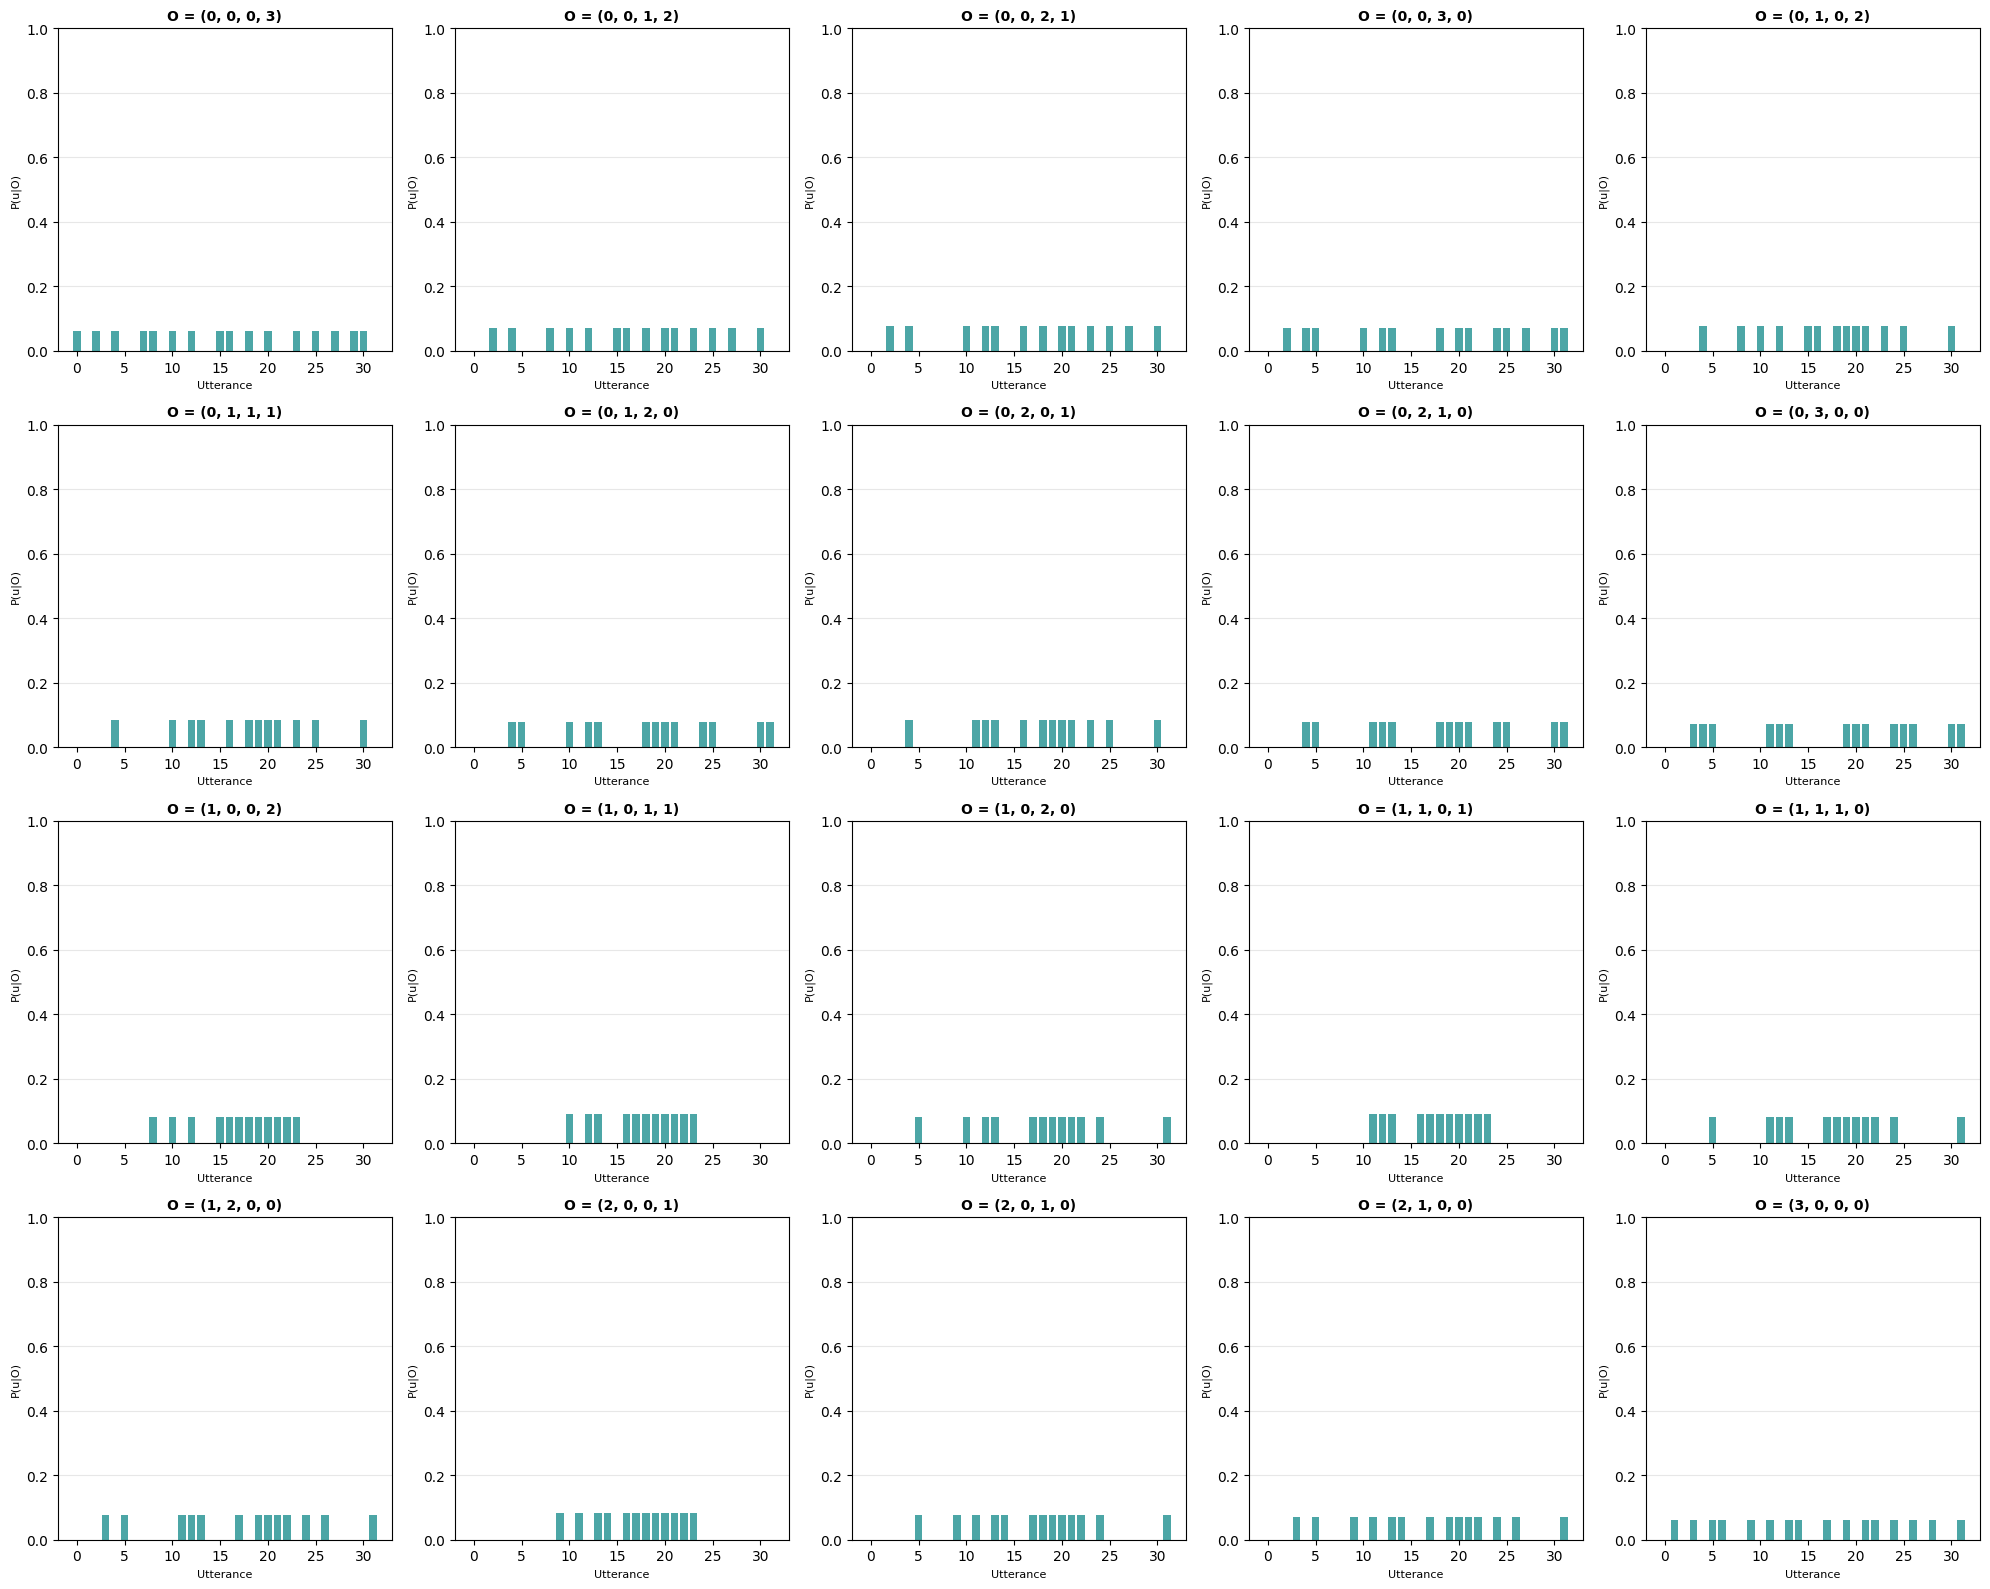

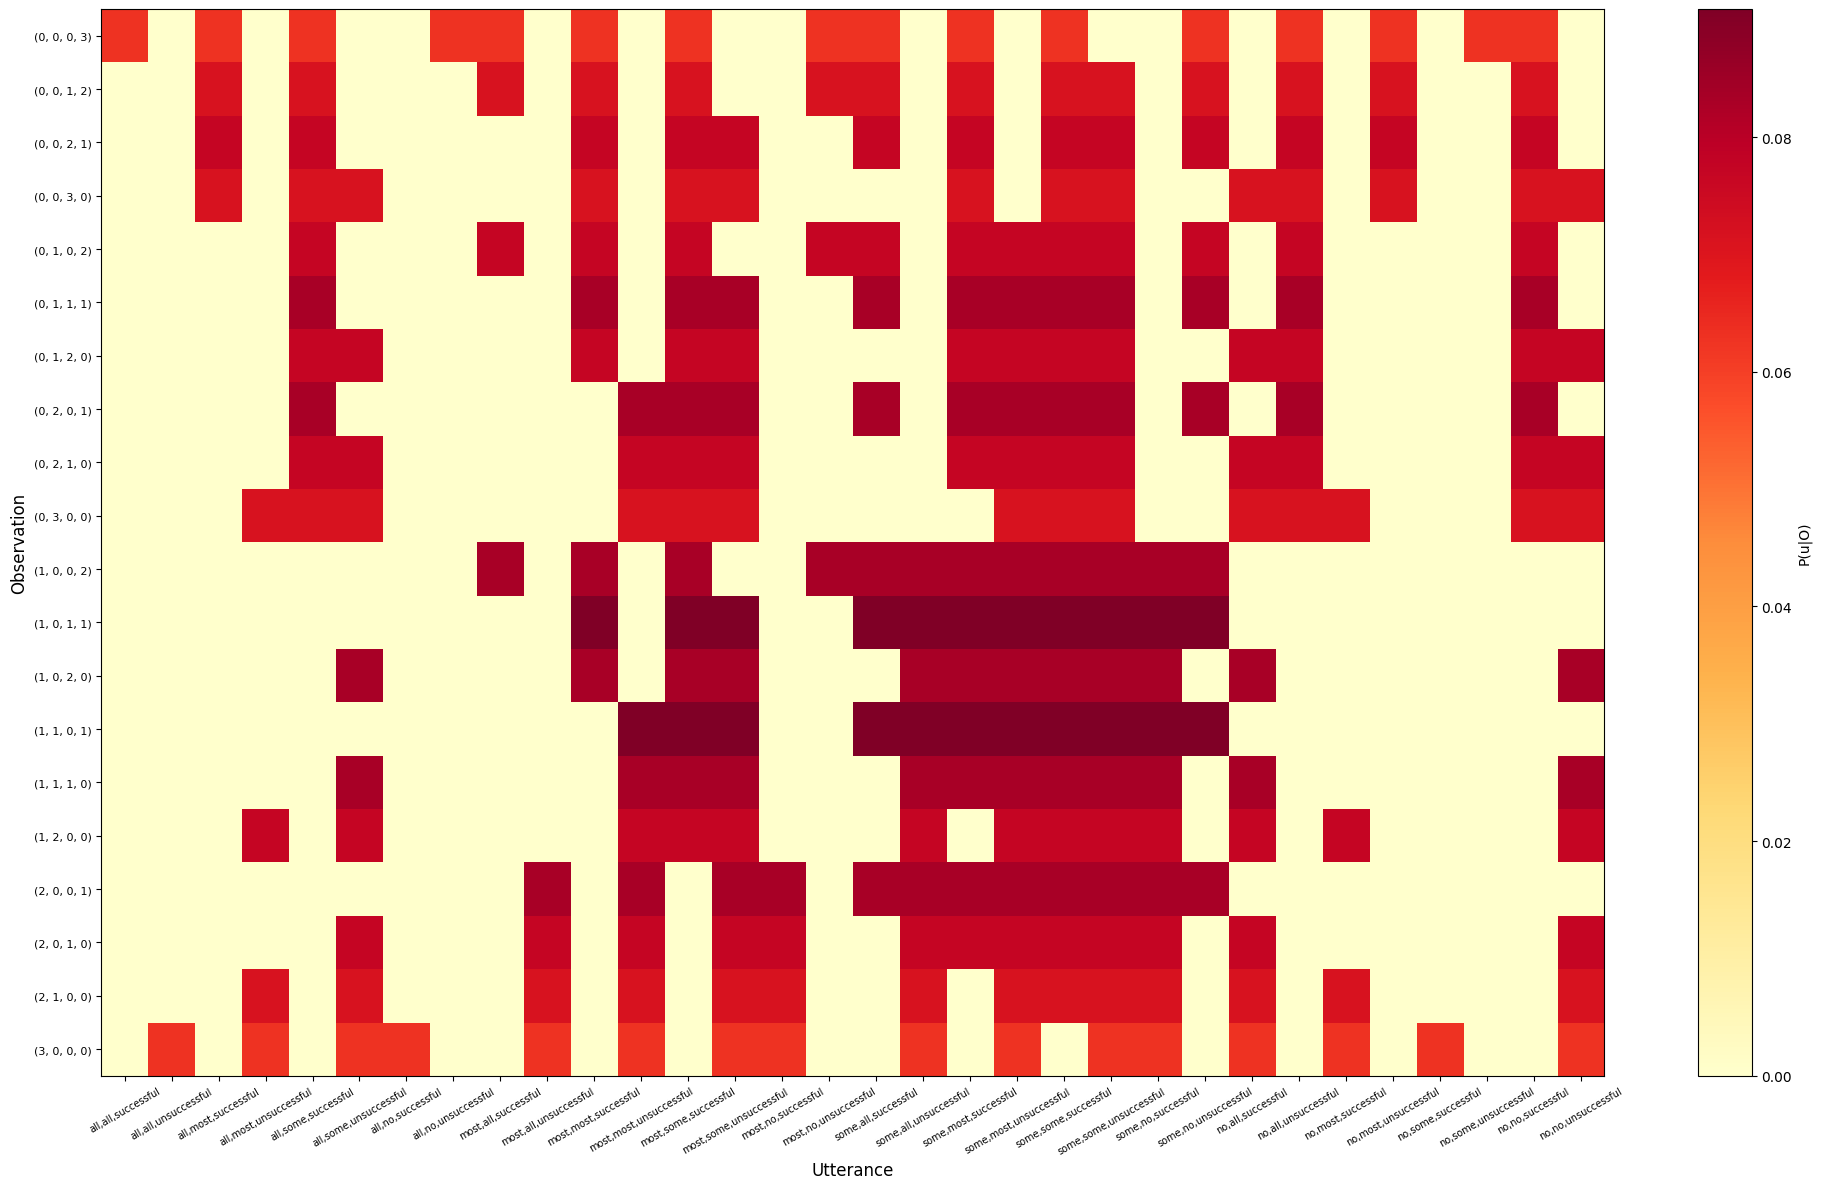

In [3]:
# save P(u|O)
p_u_given_o_s0 = np.zeros((n_obs, n_utt))
for i, obs in enumerate(observations):
    p_u_given_o_s0[i, :] = np.exp(speaker.utterance_log_prob_obs[obs].values)

create_bar_plots(p_u_given_o_s0, observations, n_utt)

create_heat_map(p_u_given_o_s0, observations, utterances)

#### Test B: comprehensive P(theta|u)

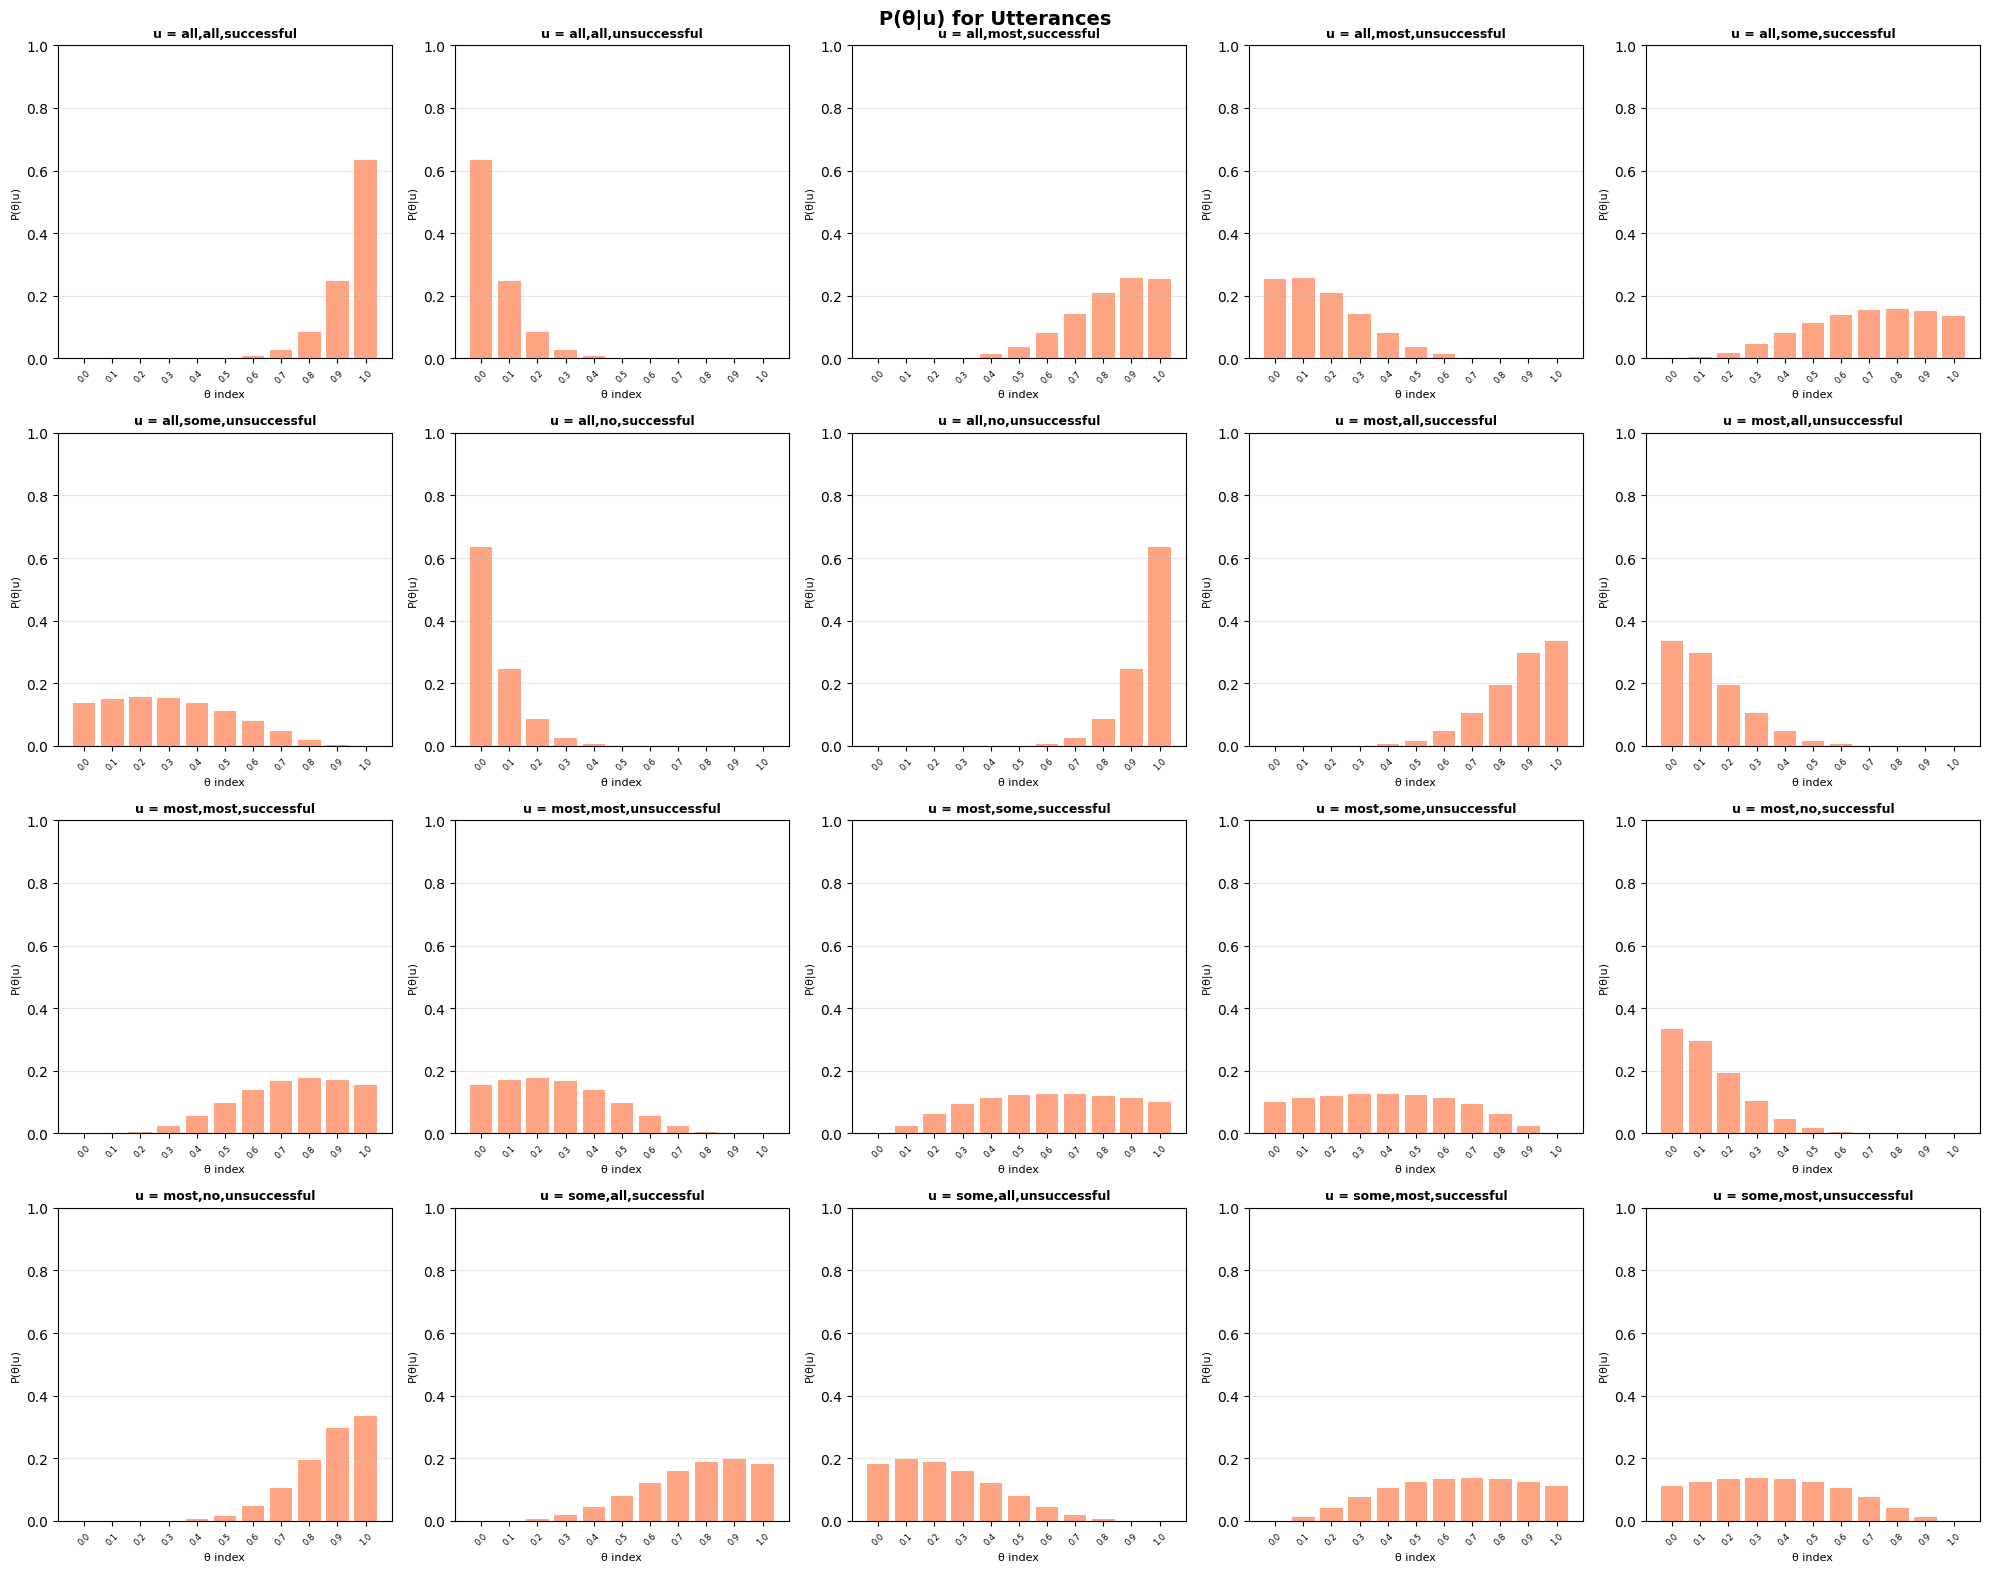

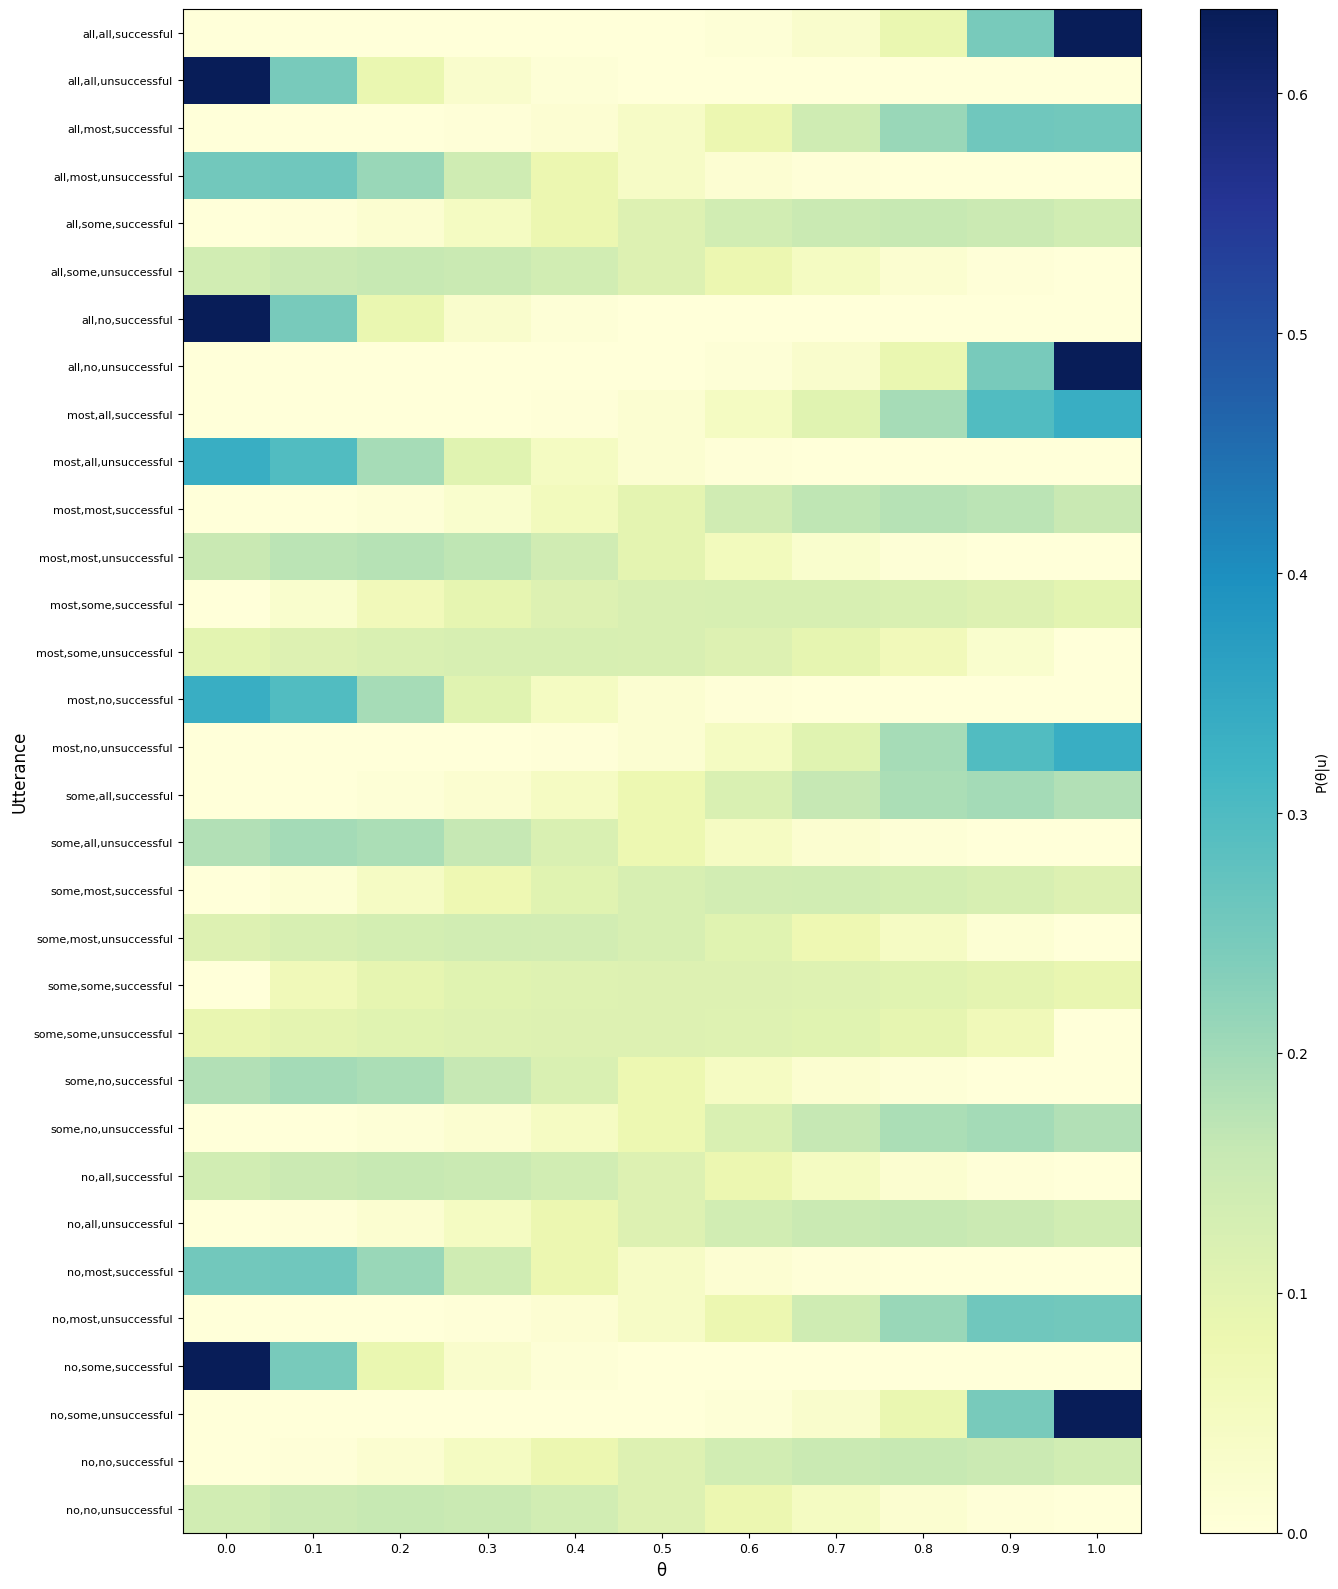

In [4]:
theta_values = world.theta_values
n_theta = len(theta_values)

p_theta_given_u_l0 = np.zeros((n_utt, n_theta))

for i, utt in enumerate(utterances):
    log_post = listener.theta_log_post_utterance[utt].values
    log_post_normalized = log_post - np.logaddexp.reduce(log_post)
    p_theta_given_u_l0[i, :] = np.exp(log_post_normalized)

create_bar_l(p_theta_given_u_l0, theta_values, utterances)
create_heat_l(p_theta_given_u_l0, theta_values, utterances)

#### Test C: interaction simulation

In [5]:
# fix the observation set  
n_rounds = 10
true_theta = 0.7

np.random.seed(42)  
theta_idx = np.argmin(np.abs(world.theta_values - true_theta))
obs_probs = np.exp(world.obs_log_likelihood_theta.iloc[:, theta_idx].values)

observations_history = []
for _ in range(n_rounds):
    obs_idx = np.random.choice(len(world.possible_outcomes), p=obs_probs)
    observations_history.append(world.possible_outcomes[obs_idx])

for i, obs in enumerate(observations_history):
    print(f"  Round {i+1}: {obs}")

  Round 1: (0, 0, 2, 1)
  Round 2: (1, 0, 1, 1)
  Round 3: (0, 1, 2, 0)
  Round 4: (0, 1, 1, 1)
  Round 5: (0, 0, 1, 2)
  Round 6: (0, 0, 1, 2)
  Round 7: (0, 0, 1, 2)
  Round 8: (0, 2, 0, 1)
  Round 9: (0, 1, 1, 1)
  Round 10: (0, 1, 1, 1)


Round 1: O=(0, 0, 2, 1), u='some,all,successful'
  Speaker E[θ]=0.7264, Listener E[θ]=0.7602
Round 2: O=(1, 0, 1, 1), u='some,all,unsuccessful'
  Speaker E[θ]=0.6500, Listener E[θ]=0.5000
Round 3: O=(0, 1, 2, 0), u='all,some,unsuccessful'
  Speaker E[θ]=0.6207, Listener E[θ]=0.4437
Round 4: O=(0, 1, 1, 1), u='some,some,successful'
  Speaker E[θ]=0.6316, Listener E[θ]=0.4487
Round 5: O=(0, 0, 1, 2), u='no,all,unsuccessful'
  Speaker E[θ]=0.6807, Listener E[θ]=0.5012
Round 6: O=(0, 0, 1, 2), u='no,no,successful'
  Speaker E[θ]=0.7142, Listener E[θ]=0.5356
Round 7: O=(0, 0, 1, 2), u='most,no,unsuccessful'
  Speaker E[θ]=0.7395, Listener E[θ]=0.6345
Round 8: O=(0, 2, 0, 1), u='most,most,unsuccessful'
  Speaker E[θ]=0.7146, Listener E[θ]=0.5749
Round 9: O=(0, 1, 1, 1), u='no,no,successful'
  Speaker E[θ]=0.7082, Listener E[θ]=0.5879
Round 10: O=(0, 1, 1, 1), u='some,all,successful'
  Speaker E[θ]=0.7035, Listener E[θ]=0.6115


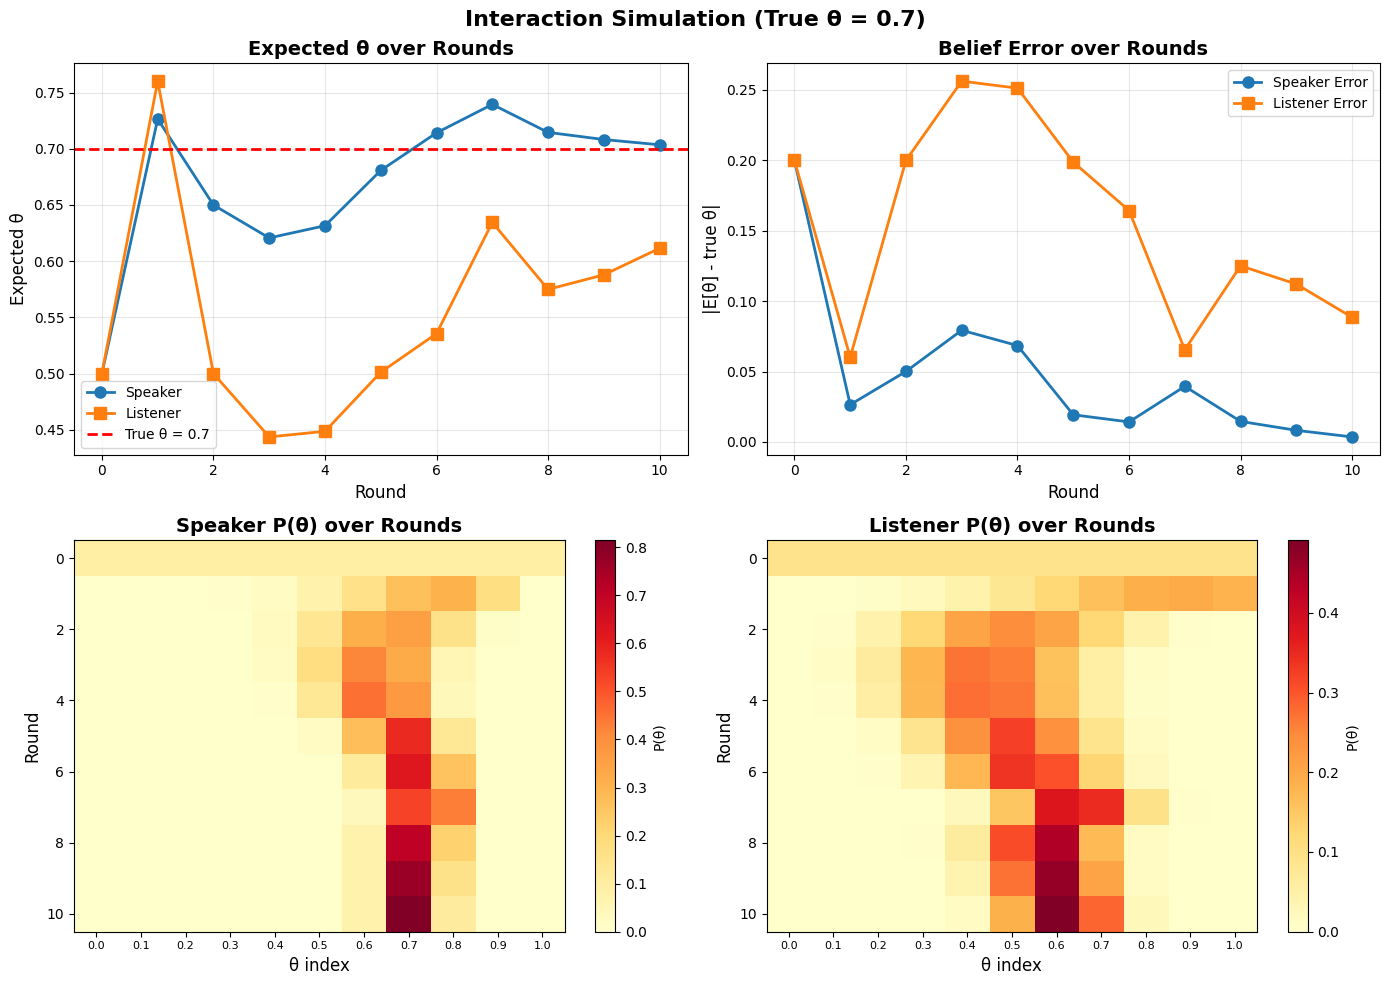

=== Summary ===
Initial Speaker Error: 0.2000
Final Speaker Error: 0.0035
Initial Listener Error: 0.2000
Final Listener Error: 0.0885


In [6]:
speaker = LiteralSpeaker(world)
listener = LiteralListener(world)

#track each run's data
speaker_beliefs_history = []
listener_beliefs_history = []
speaker_expected_theta = []
listener_expected_theta = []
speaker_errors = []
listener_errors = []
utterances_history = []

#track original belief
speaker_beliefs_history.append(speaker.current_belief_theta.copy())
listener_beliefs_history.append(listener.current_belief_theta.copy())
speaker_expected_theta.append(speaker.current_belief_theta @ world.theta_values)
listener_expected_theta.append(listener.current_belief_theta @ world.theta_values)
speaker_errors.append(np.abs(speaker_expected_theta[0] - true_theta))
listener_errors.append(np.abs(listener_expected_theta[0] - true_theta))

theta_idx = np.argmin(np.abs(world.theta_values - true_theta))

for round_idx in range(n_rounds):
    observation = observations_history[round_idx]
    
    # Speaker 
    utterance = speaker.update_and_speak(observation)
    utterances_history.append(utterance)
    
    # track speaker belief
    speaker_belief = speaker.current_belief_theta
    speaker_beliefs_history.append(speaker_belief.copy())
    speaker_exp = speaker_belief @ world.theta_values
    speaker_expected_theta.append(speaker_exp)
    speaker_errors.append(np.abs(speaker_exp - true_theta))
    
    # Listener 
    listener.listen_and_update(utterance)
    listener_belief = listener.current_belief_theta
    listener_beliefs_history.append(listener_belief.copy())
    listener_exp = listener_belief @ world.theta_values
    listener_expected_theta.append(listener_exp)
    listener_errors.append(np.abs(listener_exp - true_theta))
    
    print(f"Round {round_idx+1}: O={observation}, u='{utterance}'")
    print(f"  Speaker E[θ]={speaker_exp:.4f}, Listener E[θ]={listener_exp:.4f}")


fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Expected theta over rounds
ax = axes[0, 0]
ax.plot(range(n_rounds+1), speaker_expected_theta, 'o-', label='Speaker', linewidth=2, markersize=8)
ax.plot(range(n_rounds+1), listener_expected_theta, 's-', label='Listener', linewidth=2, markersize=8)
ax.axhline(y=true_theta, color='r', linestyle='--', linewidth=2, label=f'True θ = {true_theta}')
ax.set_xlabel('Round', fontsize=12)
ax.set_ylabel('Expected θ', fontsize=12)
ax.set_title('Expected θ over Rounds', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Belief error over rounds
ax = axes[0, 1]
ax.plot(range(n_rounds+1), speaker_errors, 'o-', label='Speaker Error', linewidth=2, markersize=8)
ax.plot(range(n_rounds+1), listener_errors, 's-', label='Listener Error', linewidth=2, markersize=8)
ax.set_xlabel('Round', fontsize=12)
ax.set_ylabel('|E[θ] - true θ|', fontsize=12)
ax.set_title('Belief Error over Rounds', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Speaker belief distribution heatmap
ax = axes[1, 0]
speaker_beliefs_matrix = np.array(speaker_beliefs_history)
im = ax.imshow(speaker_beliefs_matrix, aspect='auto', cmap='YlOrRd')
ax.set_xlabel('θ index', fontsize=12)
ax.set_ylabel('Round', fontsize=12)
ax.set_xticks(range(len(world.theta_values)))
ax.set_xticklabels([f'{t:.1f}' for t in world.theta_values], fontsize=8)
ax.set_title('Speaker P(θ) over Rounds', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='P(θ)')

# 4. Listener belief distribution heatmap
ax = axes[1, 1]
listener_beliefs_matrix = np.array(listener_beliefs_history)
im = ax.imshow(listener_beliefs_matrix, aspect='auto', cmap='YlOrRd')
ax.set_xlabel('θ index', fontsize=12)
ax.set_ylabel('Round', fontsize=12)
ax.set_xticks(range(len(world.theta_values)))
ax.set_xticklabels([f'{t:.1f}' for t in world.theta_values], fontsize=8)
ax.set_title('Listener P(θ) over Rounds', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='P(θ)')

plt.suptitle(f'Interaction Simulation (True θ = {true_theta})', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"=== Summary ===")
print(f"Initial Speaker Error: {speaker_errors[0]:.4f}")
print(f"Final Speaker Error: {speaker_errors[-1]:.4f}")
print(f"Initial Listener Error: {listener_errors[0]:.4f}")
print(f"Final Listener Error: {listener_errors[-1]:.4f}")

### 【memo version

In [7]:
worldJAX = WorldJAX(
    n=3,  # 3 independent binomial experiments
    m=3,  # each experiment has 3 Bernoulli trials
    theta_values=jnp.linspace(0, 1, 11)  # theta from 0 to 1, 11 points
)


Theta = jnp.arange(len(worldJAX.theta_values))
U = jnp.arange(len(worldJAX.utterances))
Obs = jnp.arange(len(worldJAX.observations))

utterance_log_prob_obs = literal_semantics_uniform(
    jnp.array(worldJAX.utterance_truth.values)
)
obs_log_likelihood_theta = jnp.array(
    worldJAX.obs_log_likelihood_theta.values
)
utterance_truth_matrix = jnp.array(worldJAX.utterance_truth.values)

def is_utt_true_for_obs(u, obs):
    return utterance_truth_matrix[u, obs] > 0
def get_obs_prob(obs, theta):
    return jnp.exp(obs_log_likelihood_theta[obs, theta])
def get_utt_prob(u, obs):
    return jnp.exp(utterance_log_prob_obs[u, obs])



#A bit different: 
#   #base version uses  P(θ | S) ∝ P(S | θ) × P(θ)
#   #while memo version uses  P(θ | obs) ∝ P(obs | θ) × P(θ)
@memo
def L0[_u: U, _theta: Theta](prior: ...):
    listener: knows(_u, _theta)
    listener: thinks[
        world: chooses(theta in Theta, wpp=array_index(prior, theta)),
        world: chooses(obs in Obs, wpp=get_obs_prob(obs, theta)),
        world: chooses(u in U, wpp=get_utt_prob(u, obs))
    ]
    listener: observes [world.u] is _u
    return listener[Pr[world.theta == _theta]]  

@memo
def S0[_obs: Obs, _u: U]():
    speaker: knows(_obs)
    speaker: chooses(u in U, wpp=is_utt_true_for_obs(u, _obs))
    return Pr[speaker.u == _u]

@memo
def S0_belief[_obs: Obs, _u: U, _theta: Theta](prior: ...):
    speaker: knows(_obs, _theta, _u)
    speaker: thinks[
        world: chooses(theta in Theta, wpp=array_index(prior, theta)),
        world: chooses(obs in Obs, wpp=get_obs_prob(obs, theta))
    ]
    speaker: observes [world.obs] is _obs
    speaker: chooses(u in U, wpp=is_utt_true_for_obs(u, _obs)) 
    return E[speaker[Pr[world.theta == _theta]]]
    return Pr[speaker.u == _u]

##### Test A: comprehensive P(u|O)

###### S0

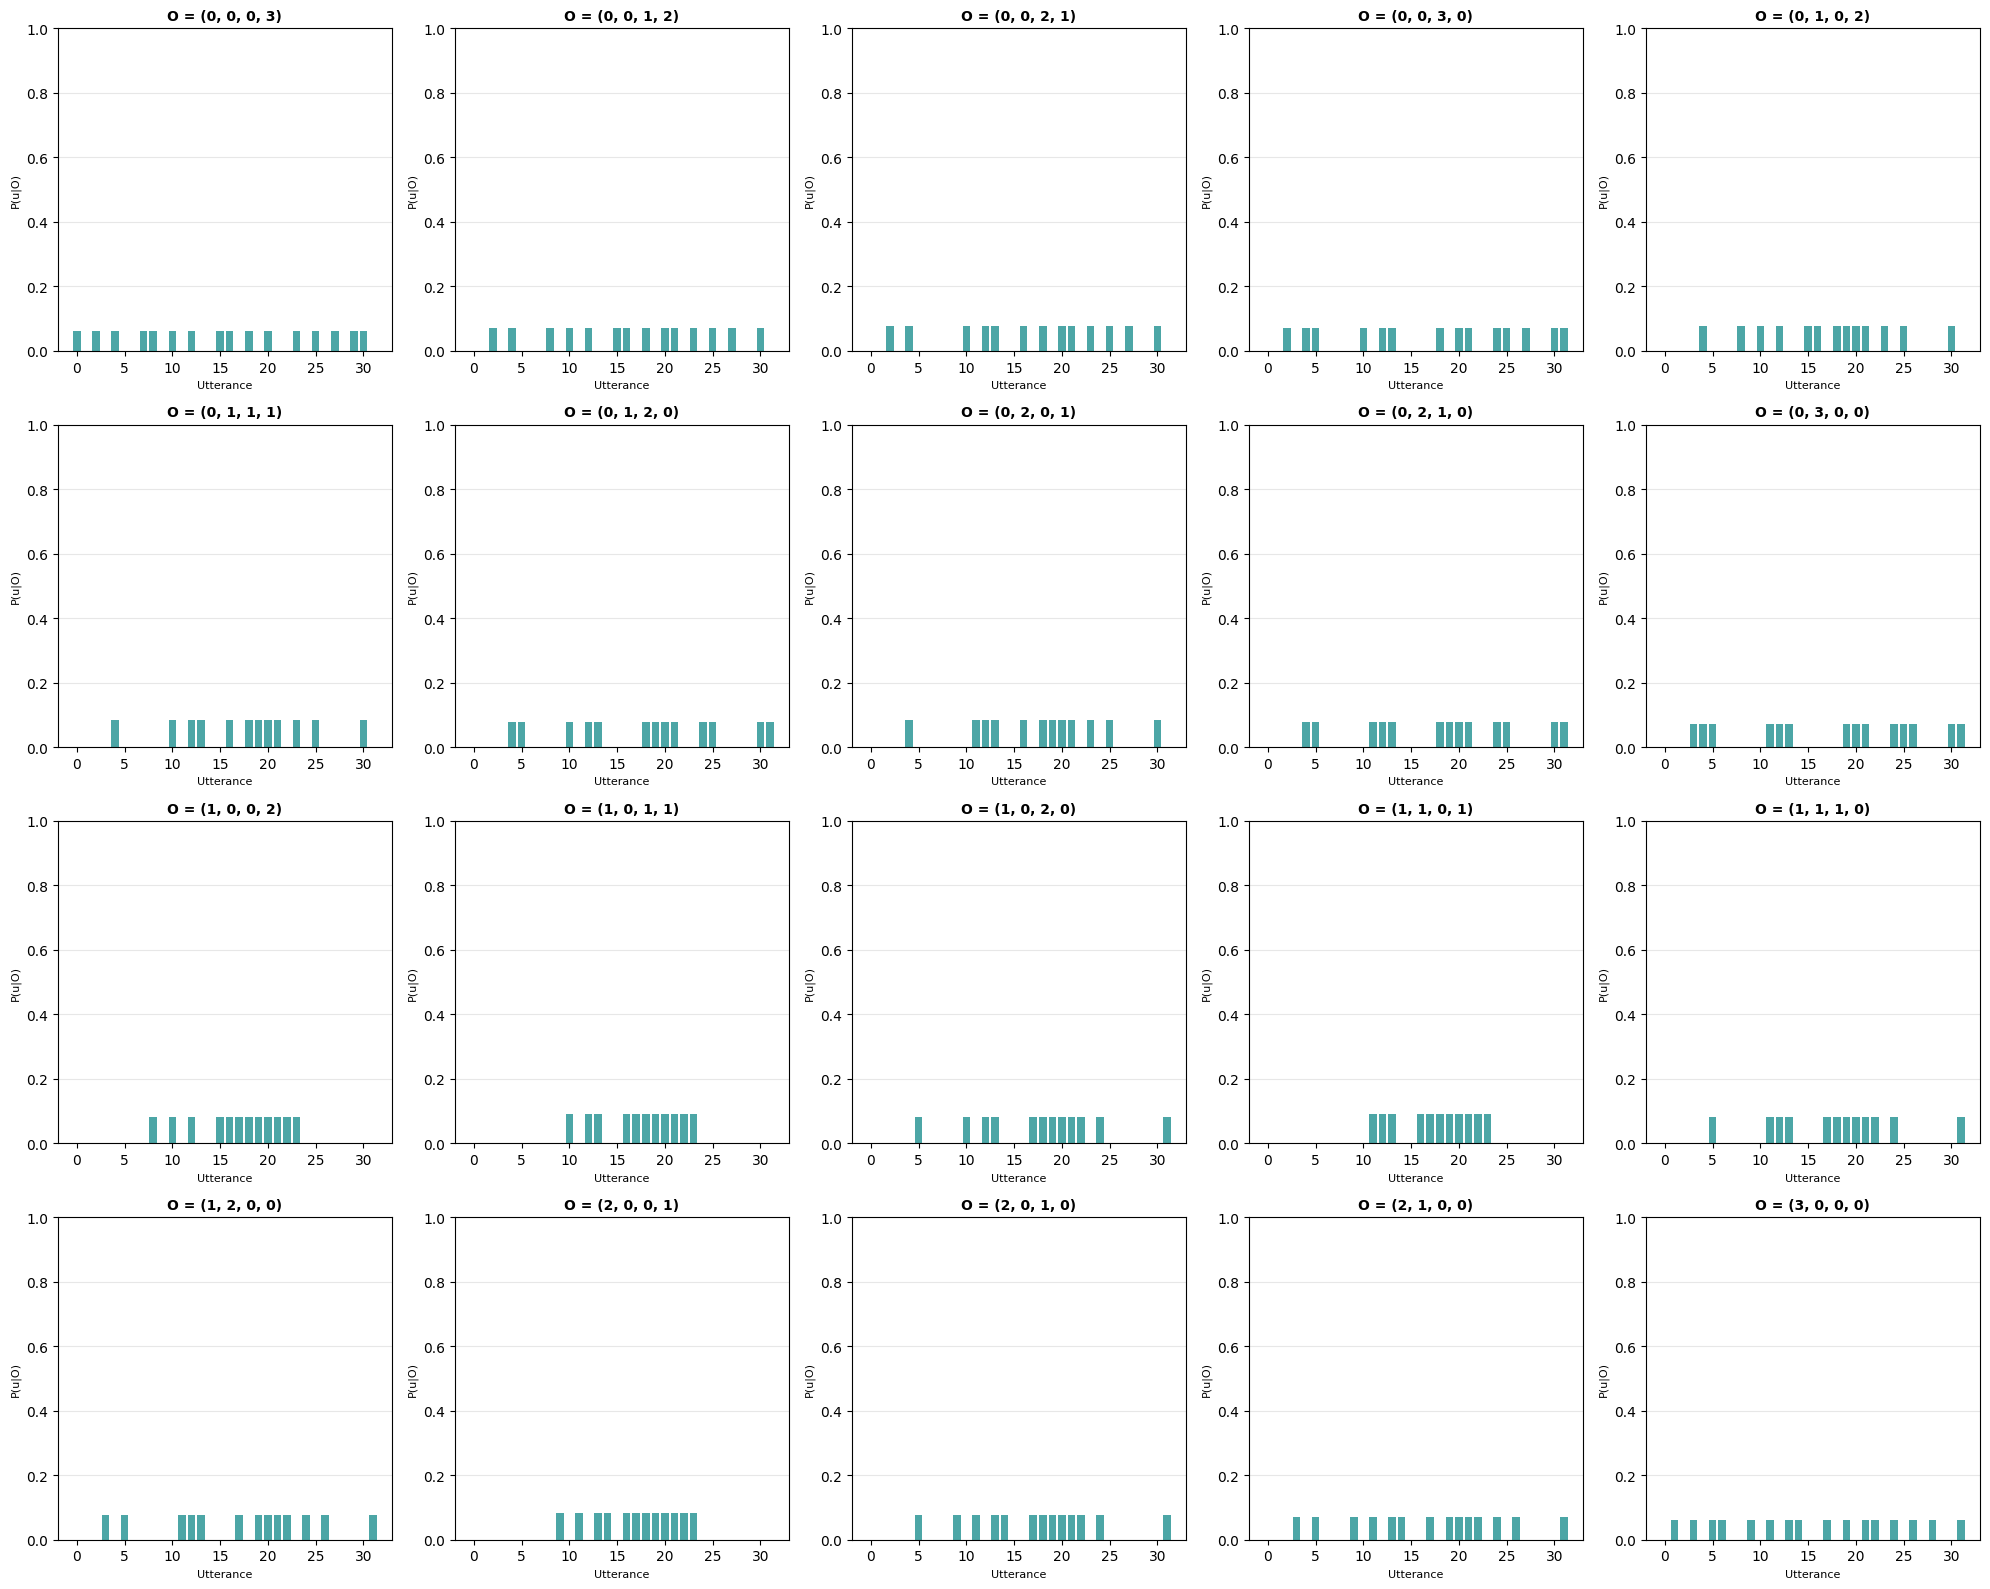

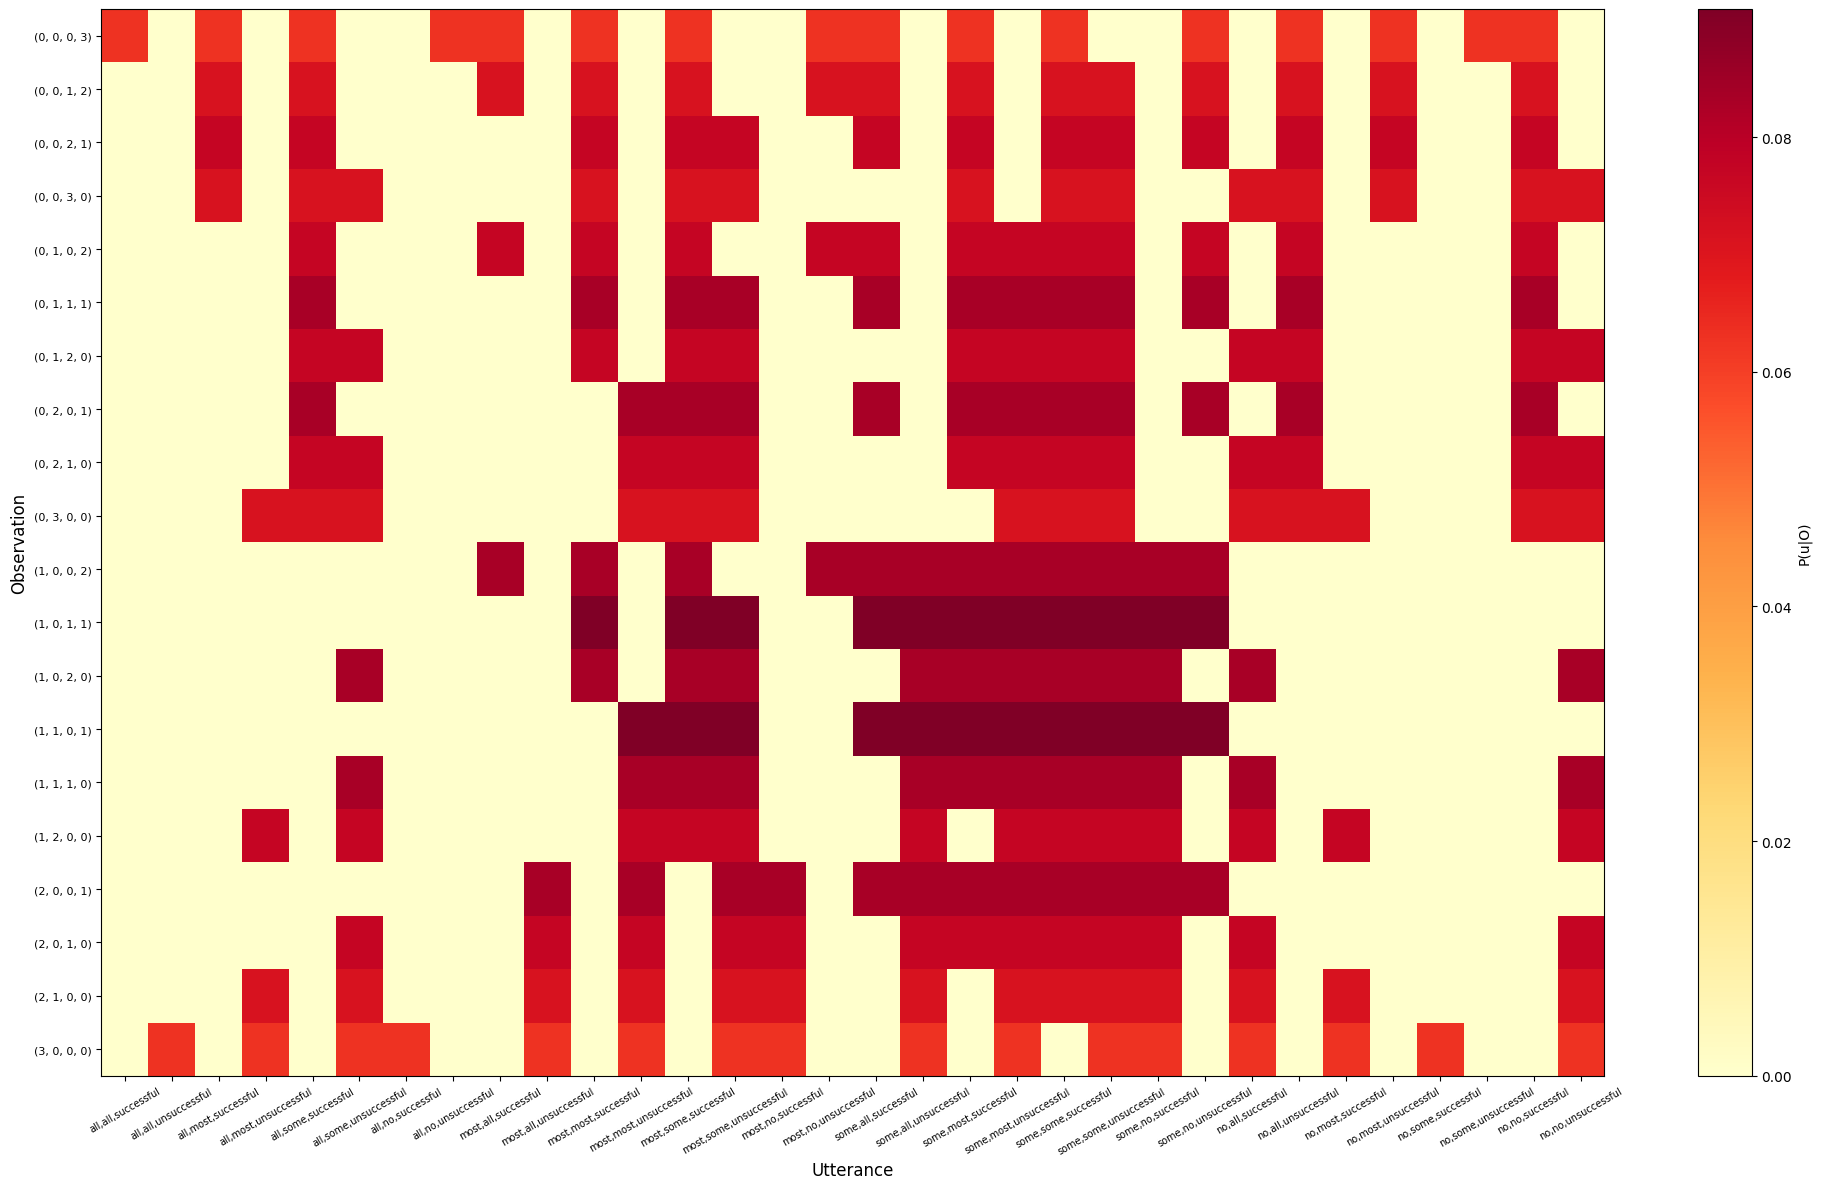

In [8]:
observations = worldJAX.observations
utterances = worldJAX.utterances
n_obs = len(observations)
n_utt = len(utterances)

s0_dist = S0() 

# s0_dist is already P(u|O) 
p_u_given_o_s0m = np.array(s0_dist)  

create_bar_plots(p_u_given_o_s0m, observations,n_utt)
create_heat_map(p_u_given_o_s0m, observations, utterances)

compare with base

In [9]:
compare_two_matrix(p_u_given_o_s0, p_u_given_o_s0m)

Total num of entries: 640
Entry with differences: 228,  35.62%
Statistics of differences:
  biggest difference: 3.193106e-09
  smallest non-zero difference: 2.483527e-09
  average differences (non-zero ones): 2.810307e-09

BIGGEST DIFFERENCE at: observation 1, utterance 2
  The difference number: -3.193106e-09
  base version: 0.071429
  memo version: 0.071429



###### S0_belief

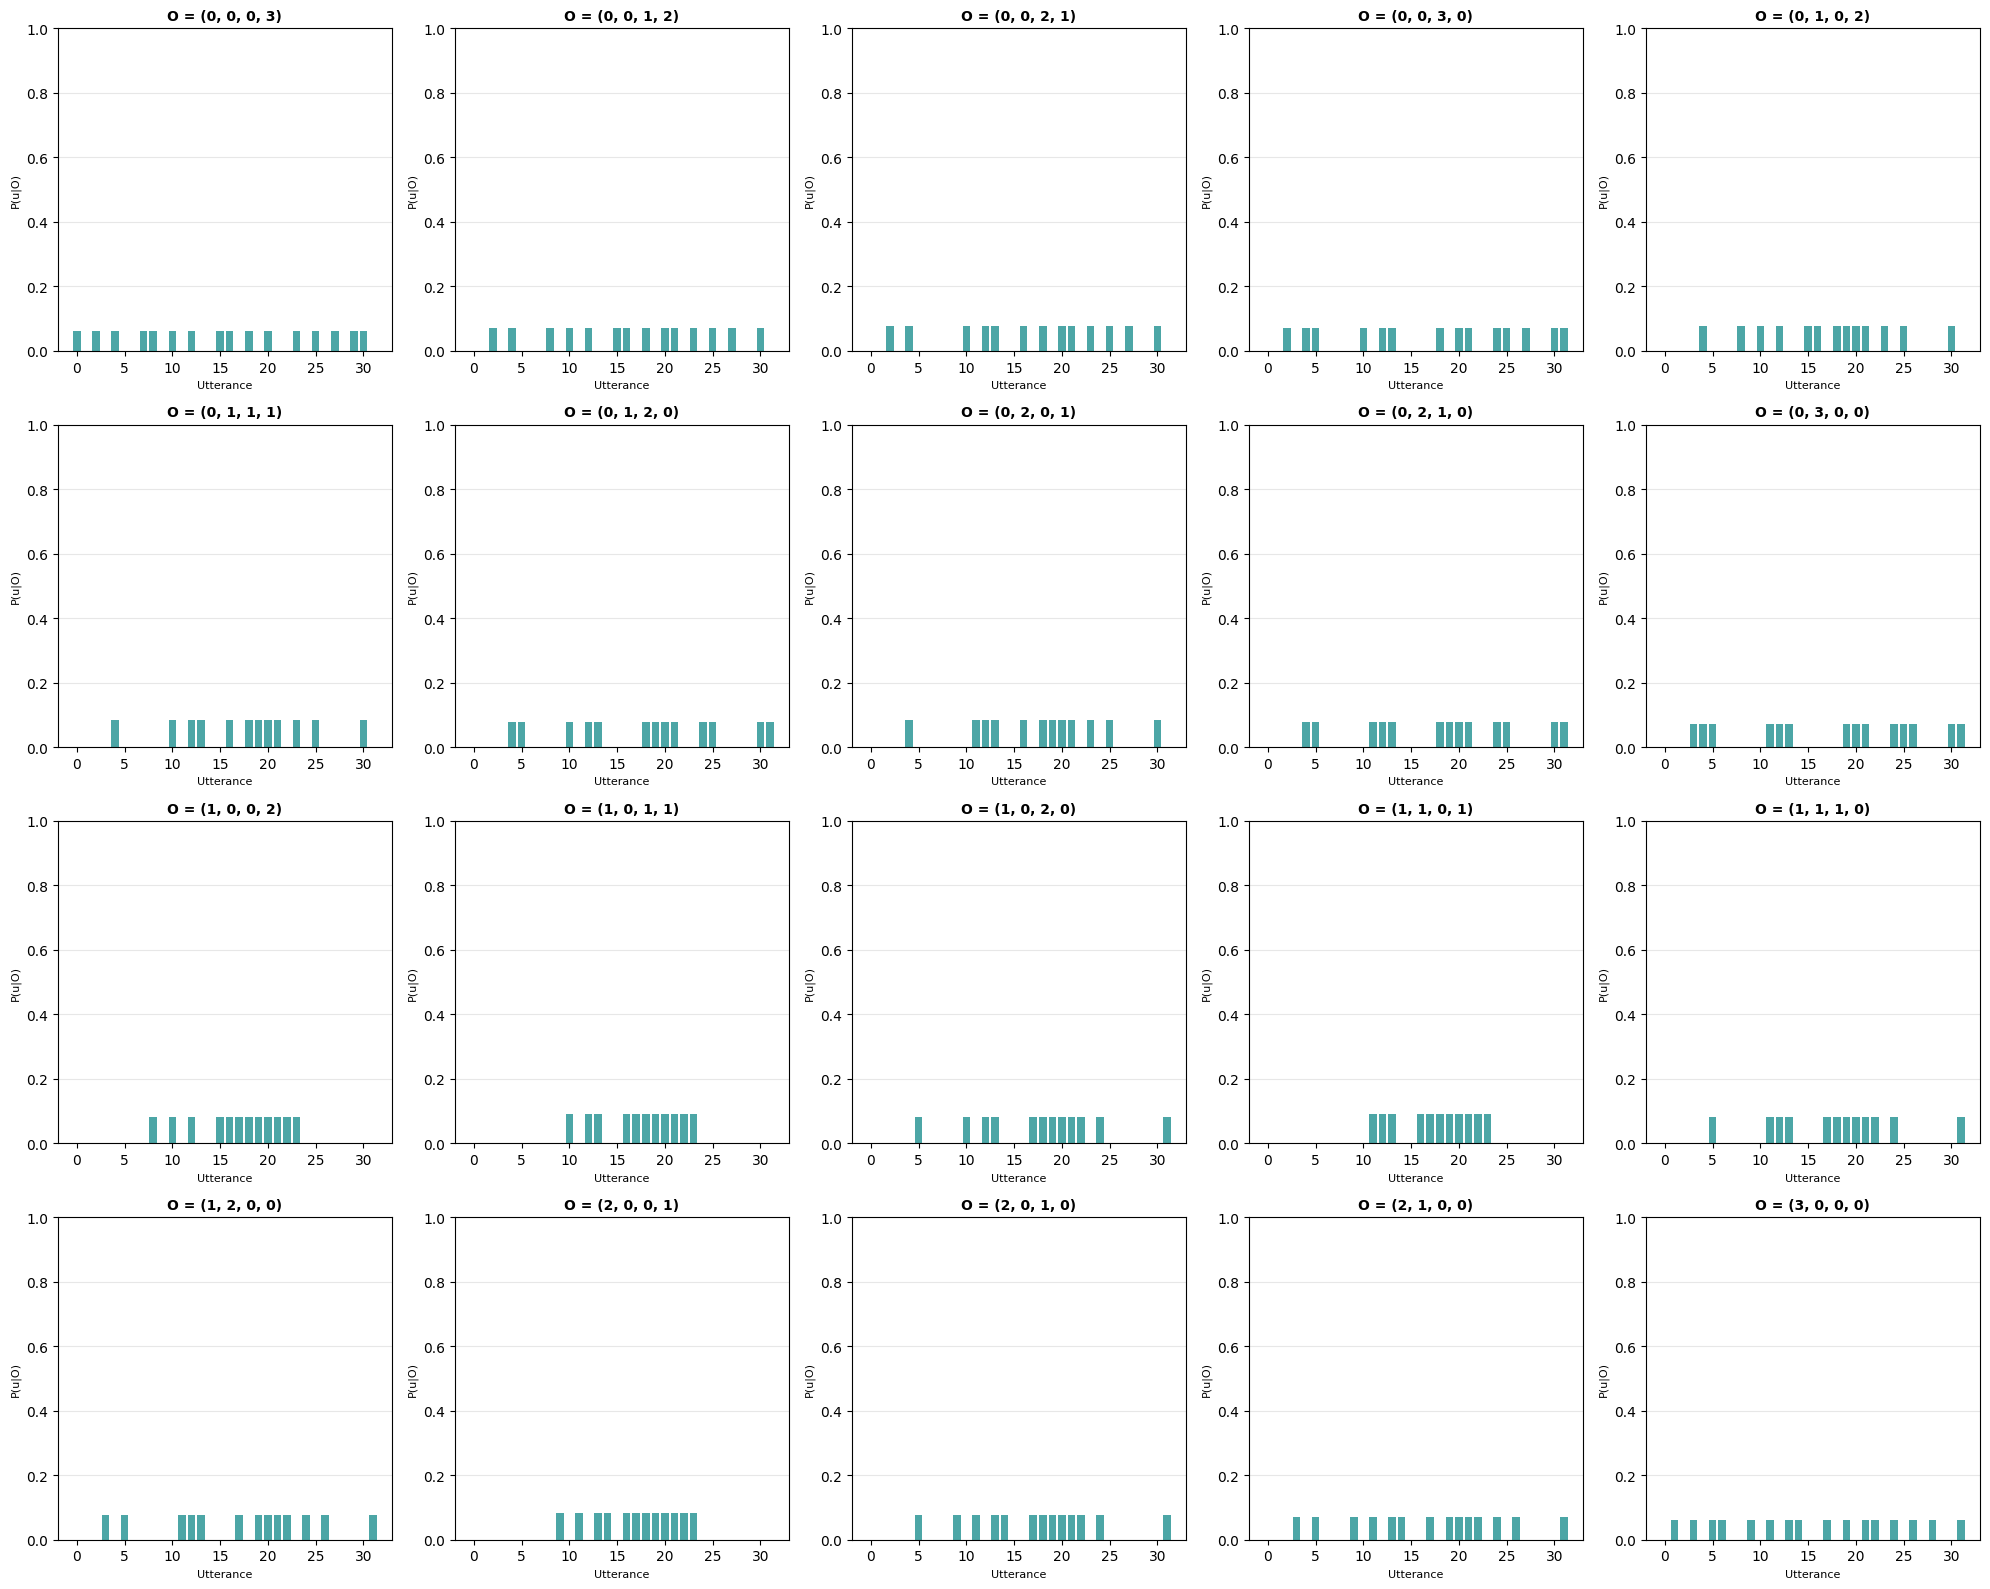

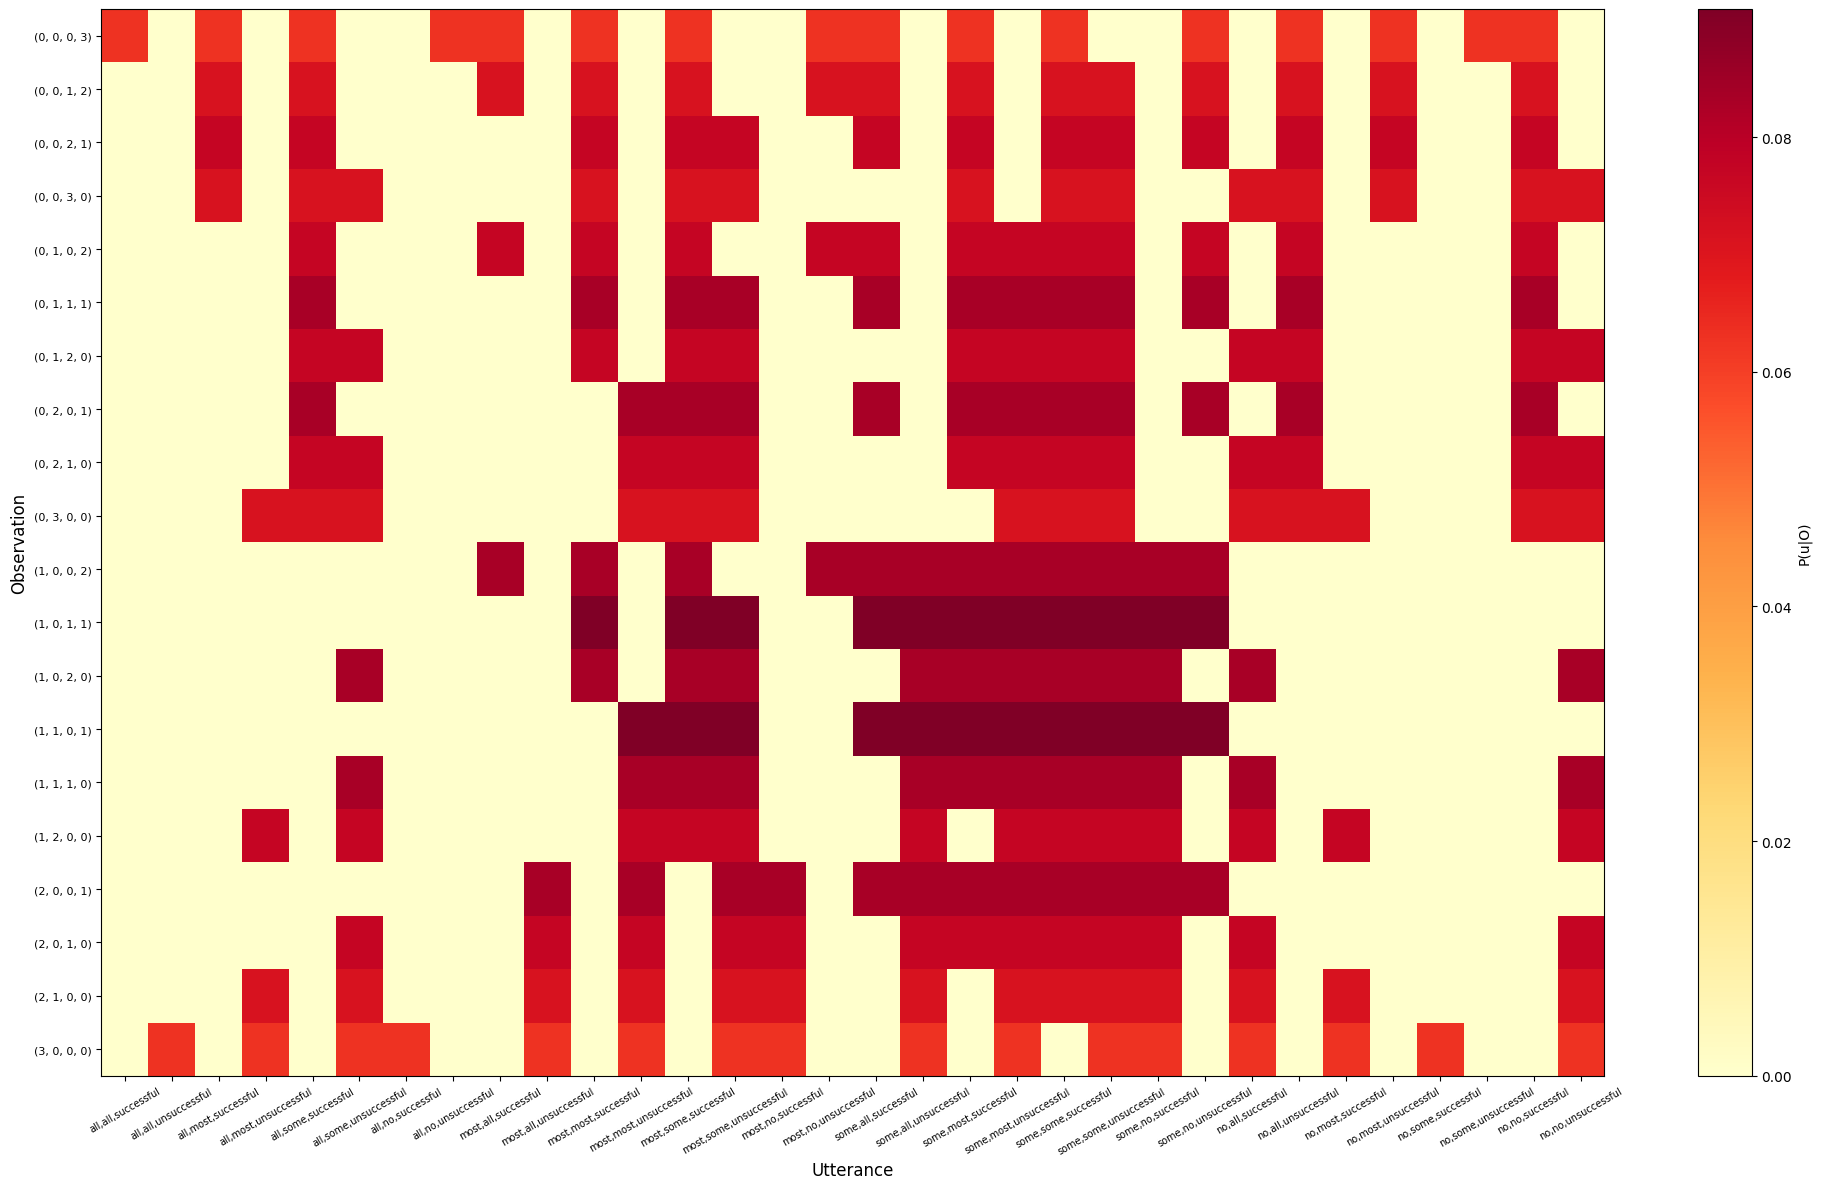

In [10]:
s0_dist_belief  = S0_belief(prior=uniform_prior_log(len(worldJAX.theta_values)))
theta_belief, u_prob = extract_distributions_from_s0_belief(s0_dist_belief)

p_u_given_o_s0mb = np.array(u_prob)  

create_bar_plots(p_u_given_o_s0mb, observations,n_utt)
create_heat_map(p_u_given_o_s0mb, observations, utterances)

In [11]:
compare_two_matrix(p_u_given_o_s0, p_u_given_o_s0mb)

Total num of entries: 640
Entry with differences: 228,  35.62%
Statistics of differences:
  biggest difference: 9.934107e-09
  smallest non-zero difference: 2.865608e-09
  average differences (non-zero ones): 5.620613e-09

BIGGEST DIFFERENCE at: observation 5, utterance 4
  The difference number: -9.934107e-09
  base version: 0.083333
  memo version: 0.083333



##### Test B: comprehensive P(theta|u)

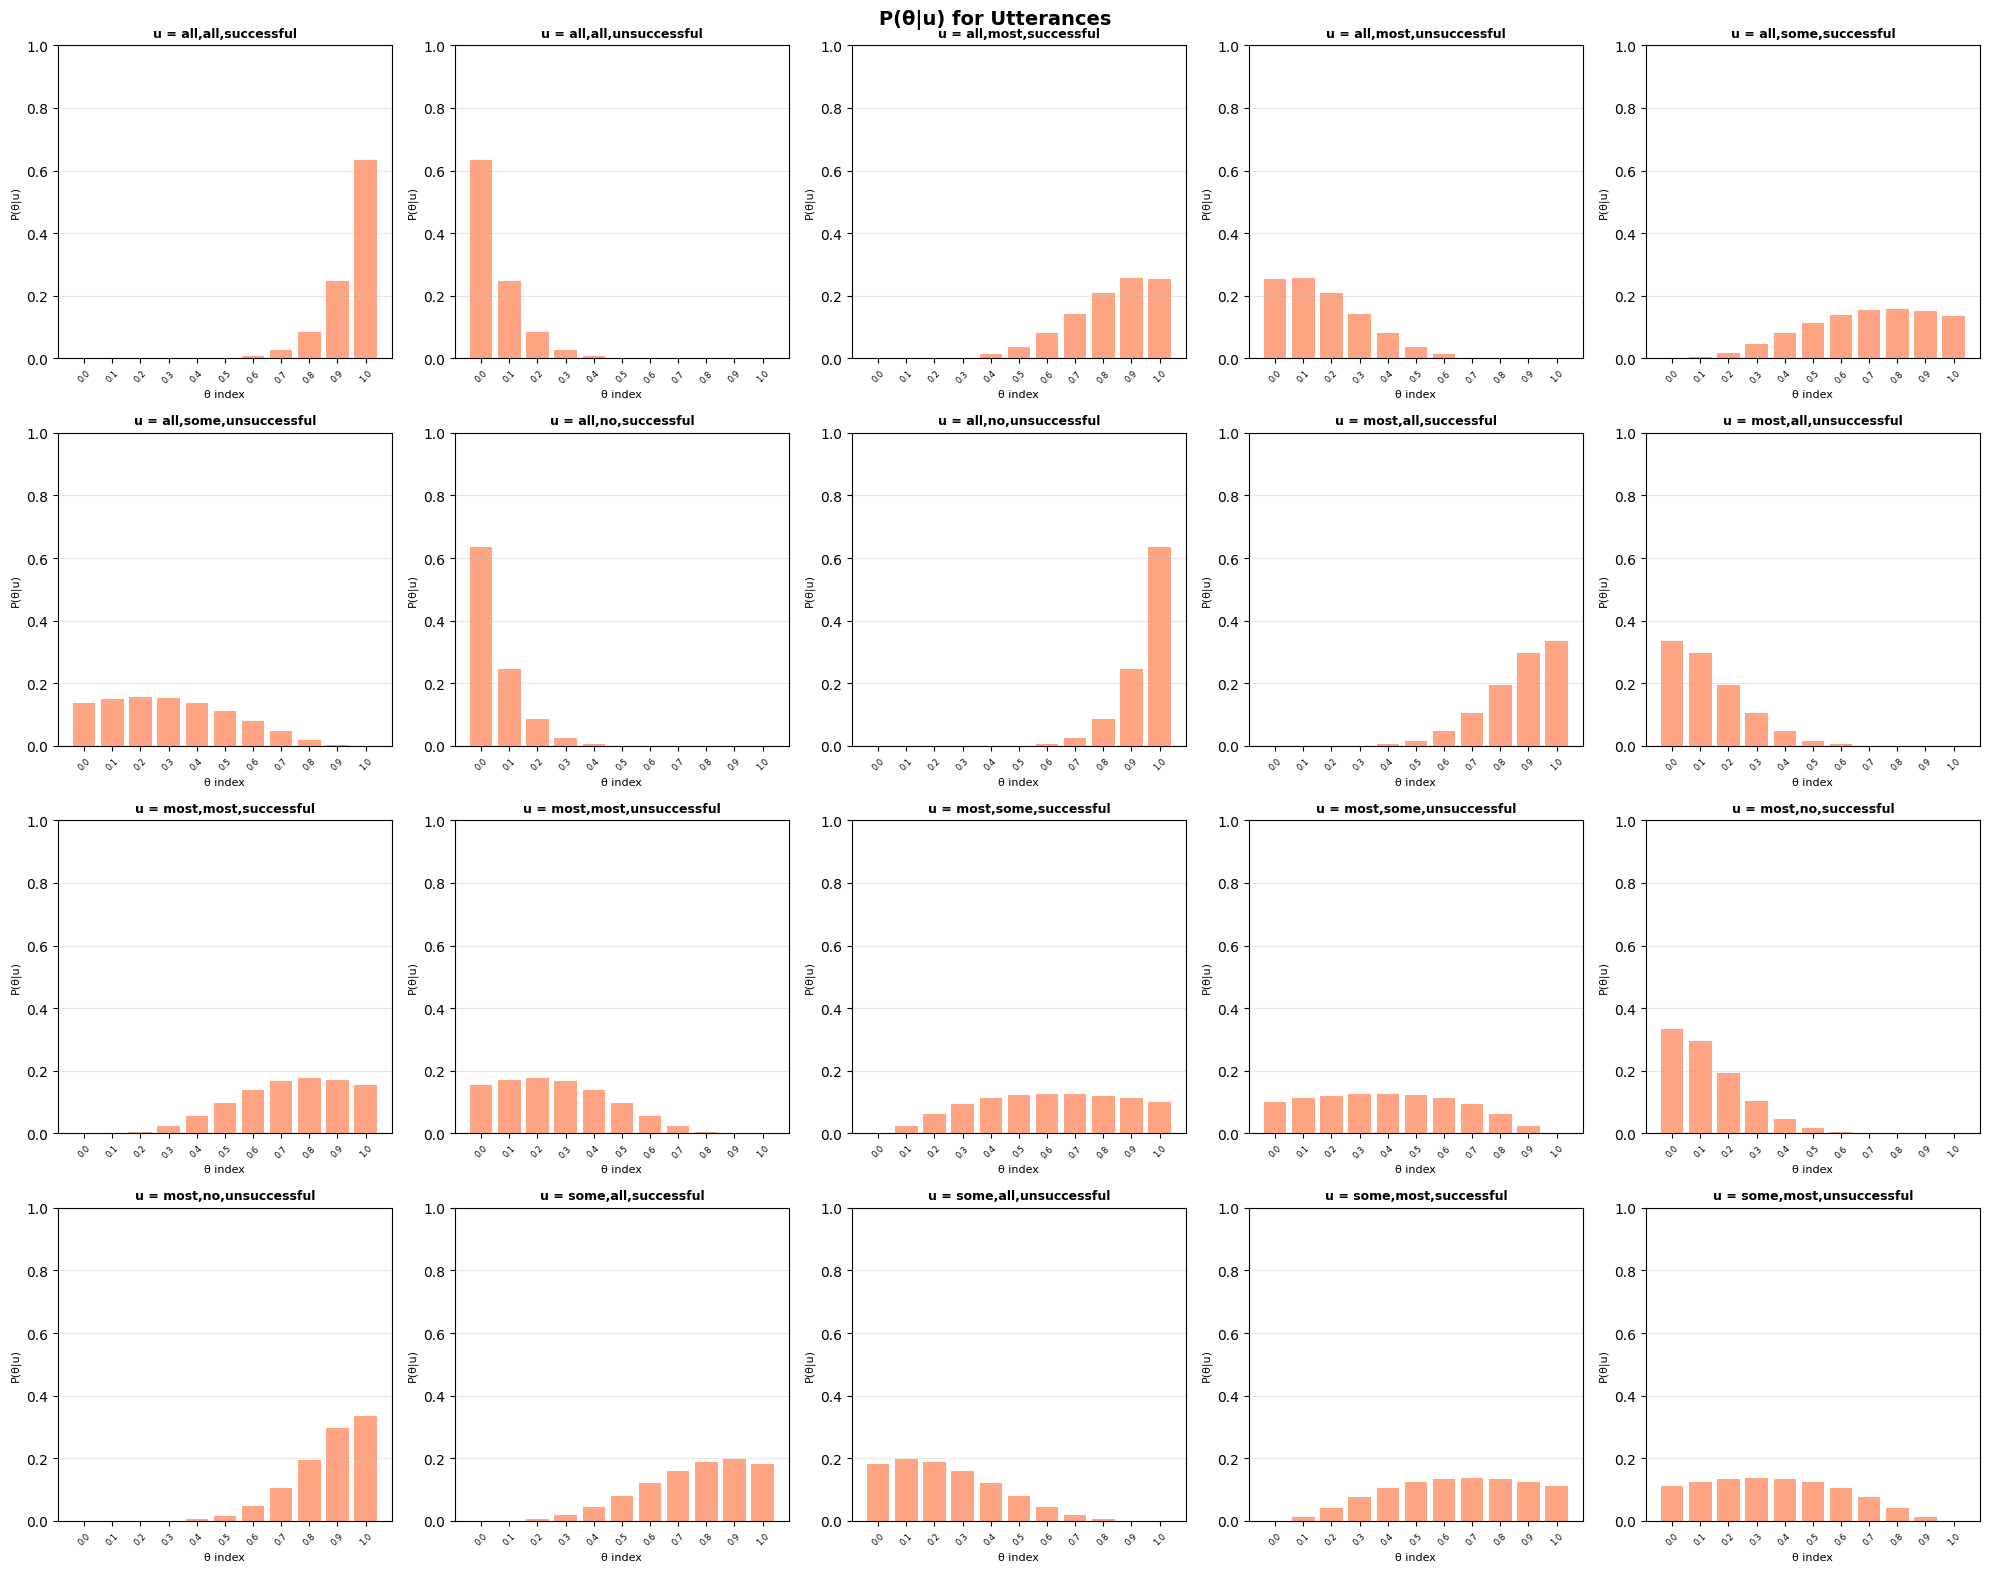

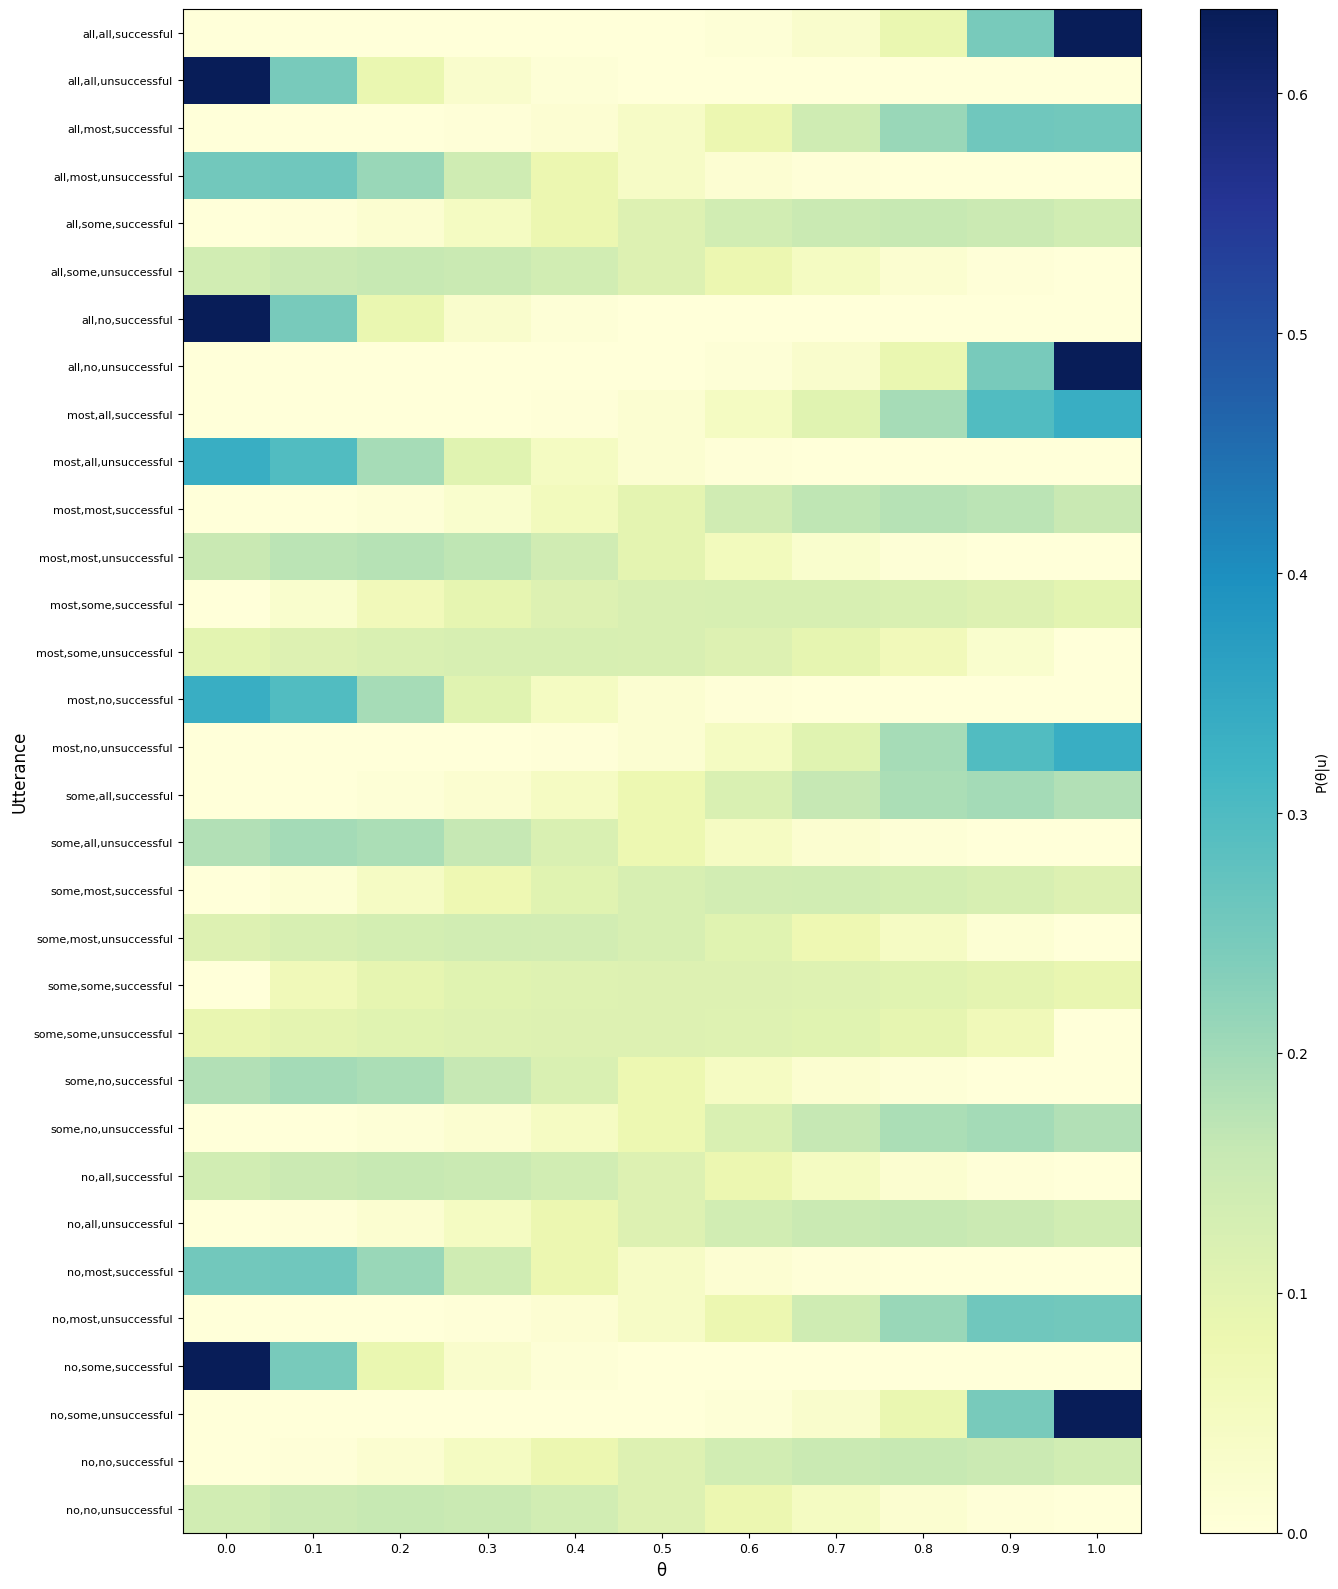

In [12]:
n_theta = len(worldJAX.theta_values)
n_utt = len(worldJAX.utterances)

# Compute L0 distribution
l0_dist = L0(uniform_prior_log(len(worldJAX.theta_values))) 
p_theta_given_u_l0m = np.array(l0_dist)

for i in range(n_utt):
    row_sum = np.sum(p_theta_given_u_l0m[i, :])
    if row_sum > 0:
        p_theta_given_u_l0m[i, :] = p_theta_given_u_l0m[i, :] / row_sum

create_bar_l(p_theta_given_u_l0m, theta_values, utterances)
create_heat_l(p_theta_given_u_l0m, theta_values, utterances)

compare with base version

In [13]:
compare_two_matrix(p_theta_given_u_l0, p_theta_given_u_l0m)

Total num of entries: 352
Entry with differences: 292,  82.95%
Statistics of differences:
  biggest difference: 5.181762e-07
  smallest non-zero difference: 1.052962e-10
  average differences (non-zero ones): 3.525457e-08

BIGGEST DIFFERENCE at: observation 1, utterance 0
  The difference number: -5.181762e-07
  base version: 0.635201
  memo version: 0.635201



##### Test C: interaction simulation

Round 1: O=(0, 0, 2, 1) u='some,some,successful'
Speaker E[θ]=0.637, Listener E[θ]=0.563
Round 2: O=(1, 0, 1, 1) u='all,all,successful'
Speaker E[θ]=0.801, Listener E[θ]=0.942
Round 3: O=(0, 1, 2, 0) u='some,all,successful'
Speaker E[θ]=0.794, Listener E[θ]=0.942
Round 4: O=(0, 1, 1, 1) u='no,no,successful'
Speaker E[θ]=0.817, Listener E[θ]=0.938
Round 5: O=(0, 0, 1, 2) u='all,some,successful'
Speaker E[θ]=0.807, Listener E[θ]=0.934
Round 6: O=(0, 0, 1, 2) u='some,all,successful'
Speaker E[θ]=0.784, Listener E[θ]=0.934
Round 7: O=(0, 0, 1, 2) u='some,most,successful'
Speaker E[θ]=0.723, Listener E[θ]=0.929
Round 8: O=(0, 2, 0, 1) u='some,some,unsuccessful'
Speaker E[θ]=0.701, Listener E[θ]=0.847
Round 9: O=(0, 1, 1, 1) u='all,most,successful'
Speaker E[θ]=0.697, Listener E[θ]=0.858
Round 10: O=(0, 1, 1, 1) u='some,most,unsuccessful'
Speaker E[θ]=0.686, Listener E[θ]=0.811


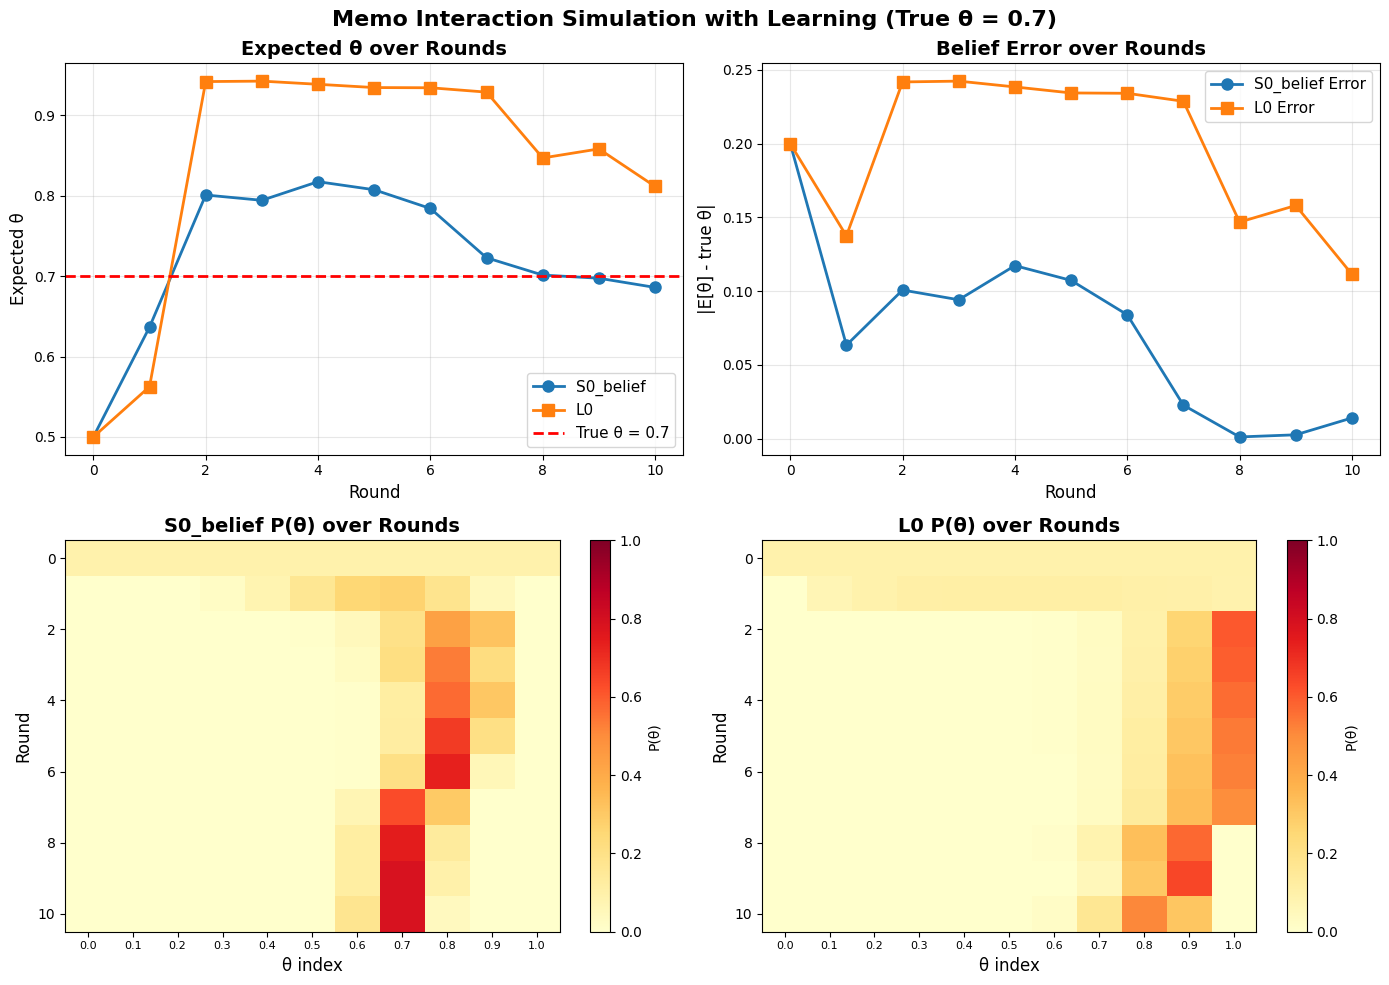

=== Summary ===
Initial S0_belief Error: 0.2000
Final S0_belief Error: 0.0141
Initial L0 Error: 0.2000
Final L0 Error: 0.1115


In [14]:
# Full simulation with memo-based L0 and S0-belief
        #use the fixed set of observations compared with the base version
n_rounds = 10
true_theta = 0.7

prior = jnp.ones(len(worldJAX.theta_values)) / len(worldJAX.theta_values)
s0_dist = S0_belief(prior)  
l0_dist = L0(prior) 

speaker_beliefs_history = []
listener_beliefs_history = []
speaker_expected_theta = []
listener_expected_theta = []
speaker_errors = []
listener_errors = []
# from S0's Test: observations_history
utterances_history = []

#track original. 
speaker_prior = prior
listener_prior = prior
speaker_beliefs_history.append(prior)
listener_beliefs_history.append(prior)
speaker_exp_initial = jnp.sum(worldJAX.theta_values * prior)
listener_exp_initial = jnp.sum(worldJAX.theta_values * prior)
speaker_expected_theta.append(float(speaker_exp_initial))
listener_expected_theta.append(float(listener_exp_initial))
speaker_errors.append(float(jnp.abs(speaker_exp_initial - true_theta)))
listener_errors.append(float(jnp.abs(listener_exp_initial - true_theta)))

# Find true theta index
theta_idx = jnp.argmin(jnp.abs(world.theta_values - true_theta))

for round_idx in range(n_rounds):
# 1. Sample observation from true theta
    obs_probs = jnp.exp(obs_log_likelihood_theta[:, theta_idx])
    obs_probs = obs_probs / jnp.sum(obs_probs)
    
    obs_idx = np.random.choice(len(world.observations), p=np.array(obs_probs))
    observation = observations_history[round_idx]
    
    # 2. S0_belief: speaker observes and updates belief, then produces utterance
    s0_belief_dist = S0_belief(prior=speaker_prior)
    theta_belief_all, u_prob_all = extract_distributions_from_s0_belief(s0_belief_dist)
    
    # Get speaker's updated belief for this observation
    speaker_belief = theta_belief_all[obs_idx]  # Shape: (11,)
    speaker_belief = speaker_belief / jnp.sum(speaker_belief)  # Normalize
    
    # Speaker produces utterance based on observation
    u_probs = u_prob_all[obs_idx]  # Shape: (32,)
    utt_idx = np.random.choice(len(world.utterances), p=np.array(u_probs))
    utterance = world.utterances[utt_idx]
    utterances_history.append(utterance)
    print(f"Round {round_idx + 1}: O={observation} u='{utterance}'")
    
    # Update speaker's prior for next round
    speaker_prior = speaker_belief
    
    # Track speaker belief
    speaker_beliefs_history.append(np.array(speaker_belief))
    speaker_exp = jnp.sum(world.theta_values * speaker_belief)
    speaker_error = jnp.abs(speaker_exp - true_theta)
    
    speaker_expected_theta.append(float(speaker_exp))
    speaker_errors.append(float(speaker_error))
    
    # 3. L0 updates belief based on utterance
    l0_dist = L0(listener_prior)  # Shape: (n_u, n_theta)
    listener_belief = l0_dist[utt_idx]
    listener_belief = listener_belief / jnp.sum(listener_belief)  # Normalize
    
    # Update listener's prior for next round
    listener_prior = listener_belief
    
    # Track listener belief
    listener_beliefs_history.append(np.array(listener_belief))
    listener_exp = jnp.sum(world.theta_values * listener_belief)
    listener_error = jnp.abs(listener_exp - true_theta)
    
    listener_expected_theta.append(float(listener_exp))
    listener_errors.append(float(listener_error))
    
    print(f"Speaker E[θ]={speaker_exp:.3f}, Listener E[θ]={listener_exp:.3f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Expected theta over rounds
ax = axes[0, 0]
ax.plot(range(n_rounds+1), speaker_expected_theta, 'o-', 
        label='S0_belief', linewidth=2, markersize=8)
ax.plot(range(n_rounds+1), listener_expected_theta, 's-', 
        label='L0', linewidth=2, markersize=8)
ax.axhline(y=true_theta, color='r', linestyle='--', 
           linewidth=2, label=f'True θ = {true_theta}')
ax.set_xlabel('Round', fontsize=12)
ax.set_ylabel('Expected θ', fontsize=12)
ax.set_title('Expected θ over Rounds', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# 2. Belief error over rounds
ax = axes[0, 1]
ax.plot(range(n_rounds+1), speaker_errors, 'o-', 
        label='S0_belief Error', linewidth=2, markersize=8)
ax.plot(range(n_rounds+1), listener_errors, 's-', 
        label='L0 Error', linewidth=2, markersize=8)
ax.set_xlabel('Round', fontsize=12)
ax.set_ylabel('|E[θ] - true θ|', fontsize=12)
ax.set_title('Belief Error over Rounds', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# 3. Speaker belief distribution heatmap
ax = axes[1, 0]
speaker_beliefs_matrix = np.array(speaker_beliefs_history)
im = ax.imshow(speaker_beliefs_matrix, aspect='auto', cmap='YlOrRd', vmin=0, vmax=1)
ax.set_xlabel('θ index', fontsize=12)
ax.set_ylabel('Round', fontsize=12)
ax.set_xticks(range(len(world.theta_values)))
ax.set_xticklabels([f'{t:.1f}' for t in world.theta_values], fontsize=8)
ax.set_title('S0_belief P(θ) over Rounds', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='P(θ)')

# 4. Listener belief distribution heatmap
ax = axes[1, 1]
listener_beliefs_matrix = np.array(listener_beliefs_history)
im = ax.imshow(listener_beliefs_matrix, aspect='auto', cmap='YlOrRd', vmin=0, vmax=1)
ax.set_xlabel('θ index', fontsize=12)
ax.set_ylabel('Round', fontsize=12)
ax.set_xticks(range(len(world.theta_values)))
ax.set_xticklabels([f'{t:.1f}' for t in world.theta_values], fontsize=8)
ax.set_title('L0 P(θ) over Rounds', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='P(θ)')

plt.suptitle(f'Memo Interaction Simulation with Learning (True θ = {true_theta})', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary
print(f"=== Summary ===")
print(f"Initial S0_belief Error: {speaker_errors[0]:.4f}")
print(f"Final S0_belief Error: {speaker_errors[-1]:.4f}")
print(f"Initial L0 Error: {listener_errors[0]:.4f}")
print(f"Final L0 Error: {listener_errors[-1]:.4f}")

## 2. S1 & L1

#### 【base (Coop & Inform)

In [15]:
world_2 = World(
    n=3,
    m=3,
    theta_values=np.linspace(0, 1, 11)
)

speaker_s1 = create_speaker(
    world=world_2,
    level=1,
    omega="coop",          # cooperative world
    psi="inf",             # informative goal
    update_internal=True,  # update internal listener model
    alpha=5.0,             # rationality parameter
    beta=1.0               # pure informativeness
)


listener_l1 = create_listener(
    world=world_2,
    level=1,
    omega="coop",          # same world type as speaker
    update_internal=True,
    alpha=5.0
)

observations = world_2.observations
utterances = world_2.utterances
n_obs = len(observations)
n_utt = len(utterances)

##### Test A: comprehensive P(u|O)

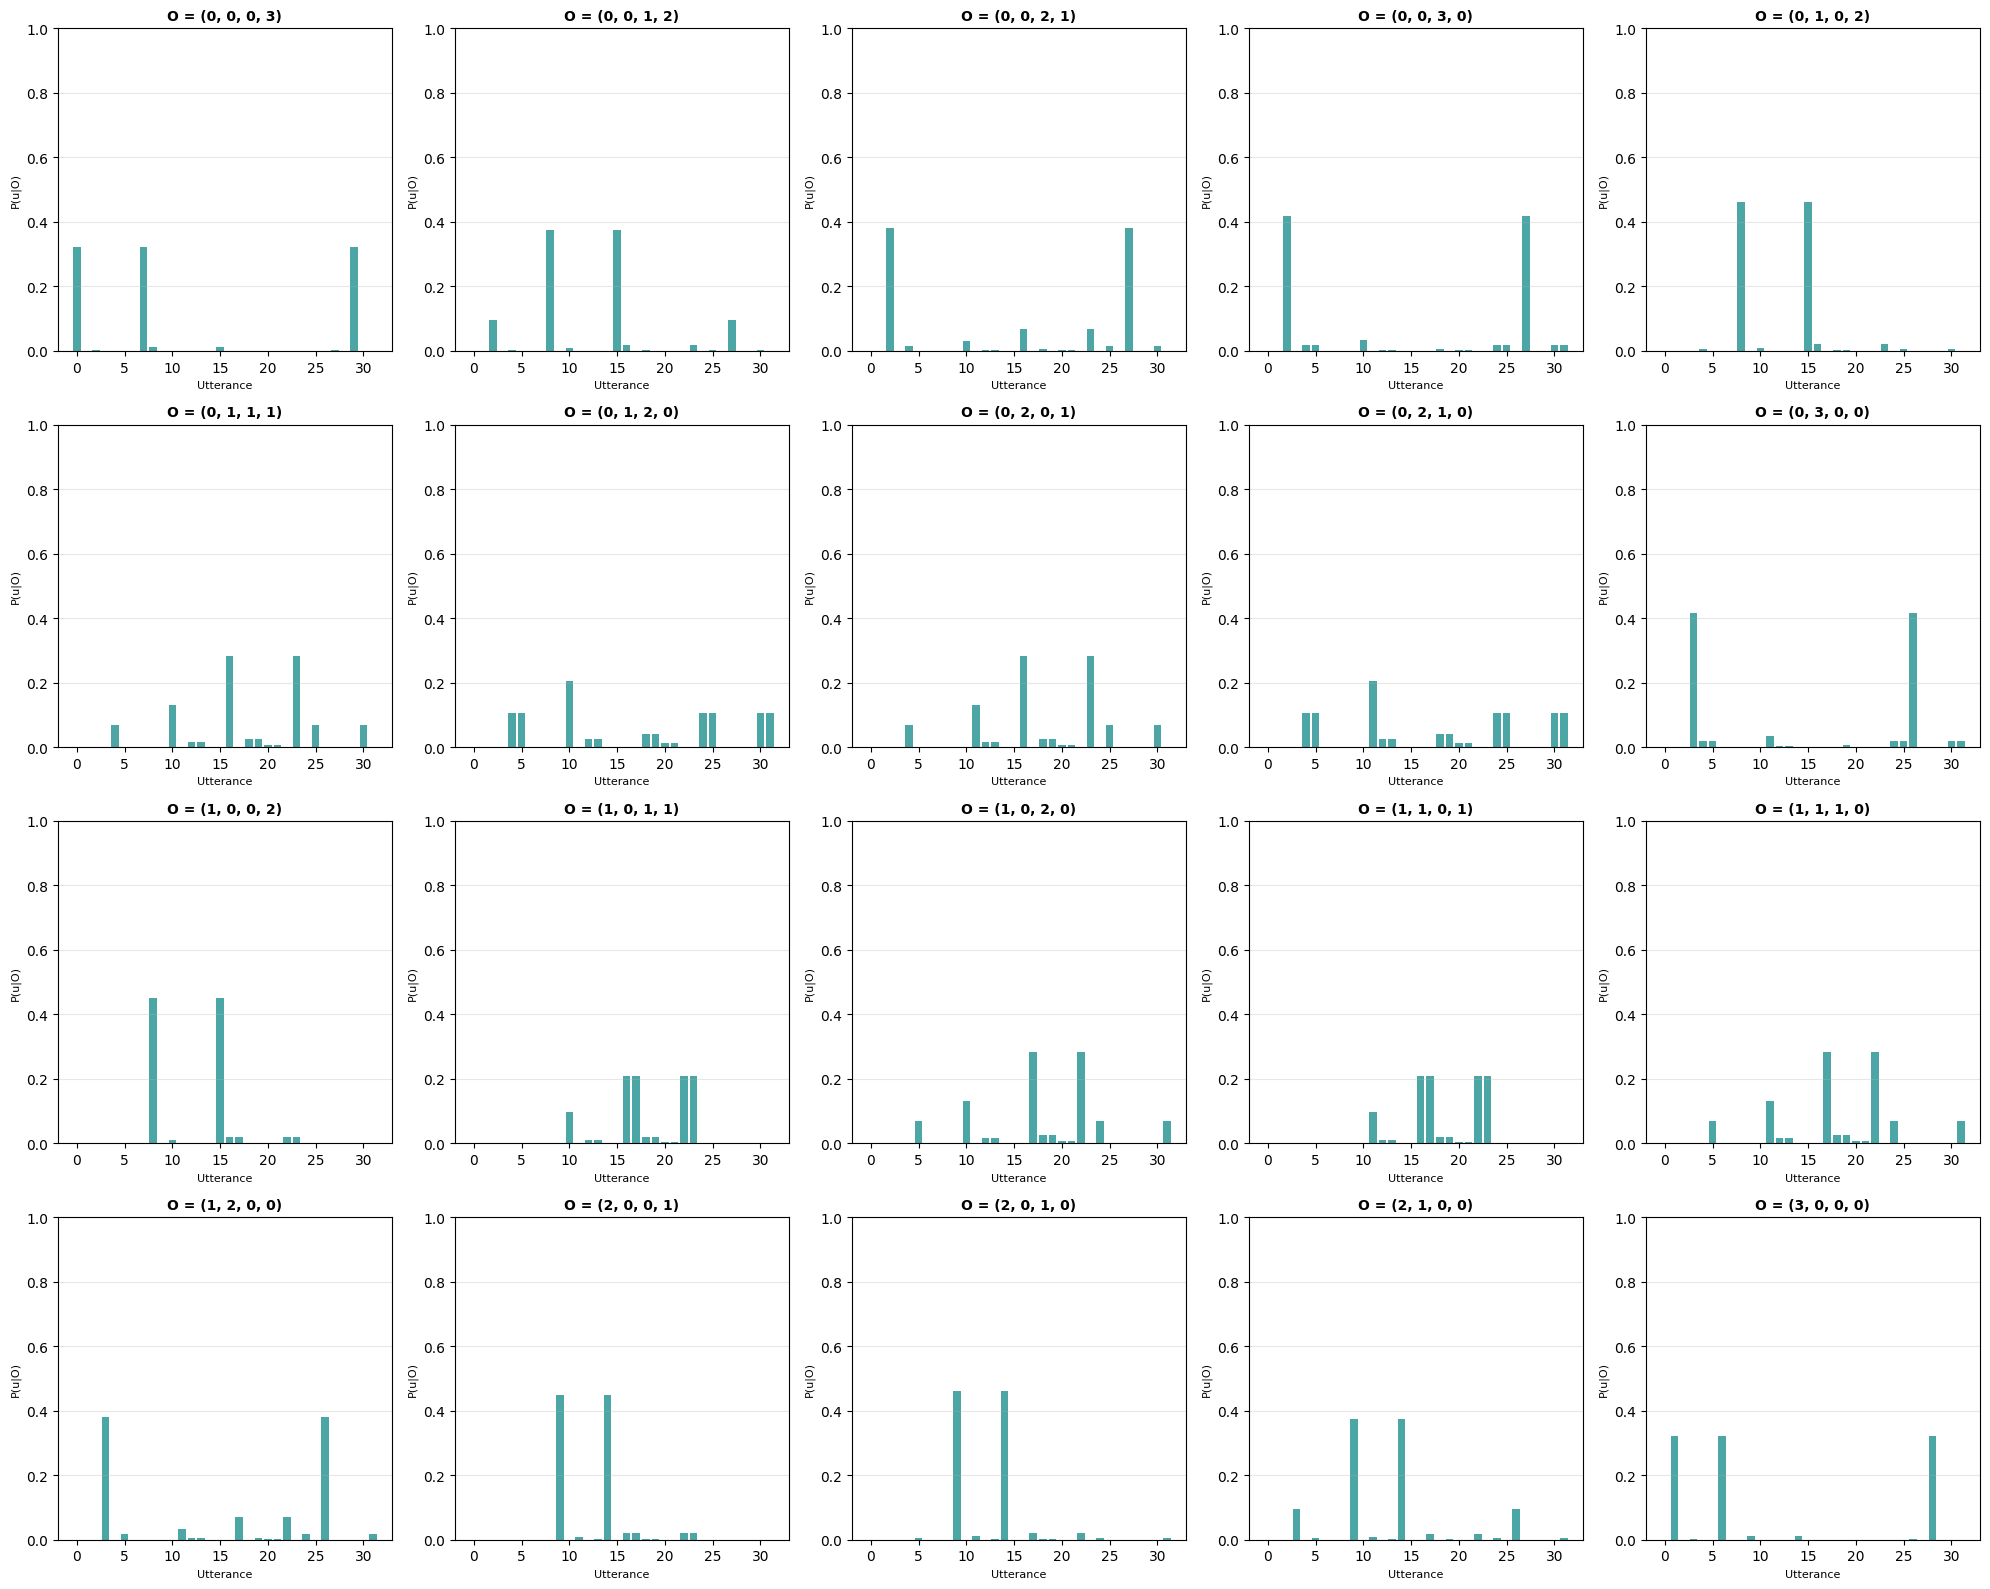

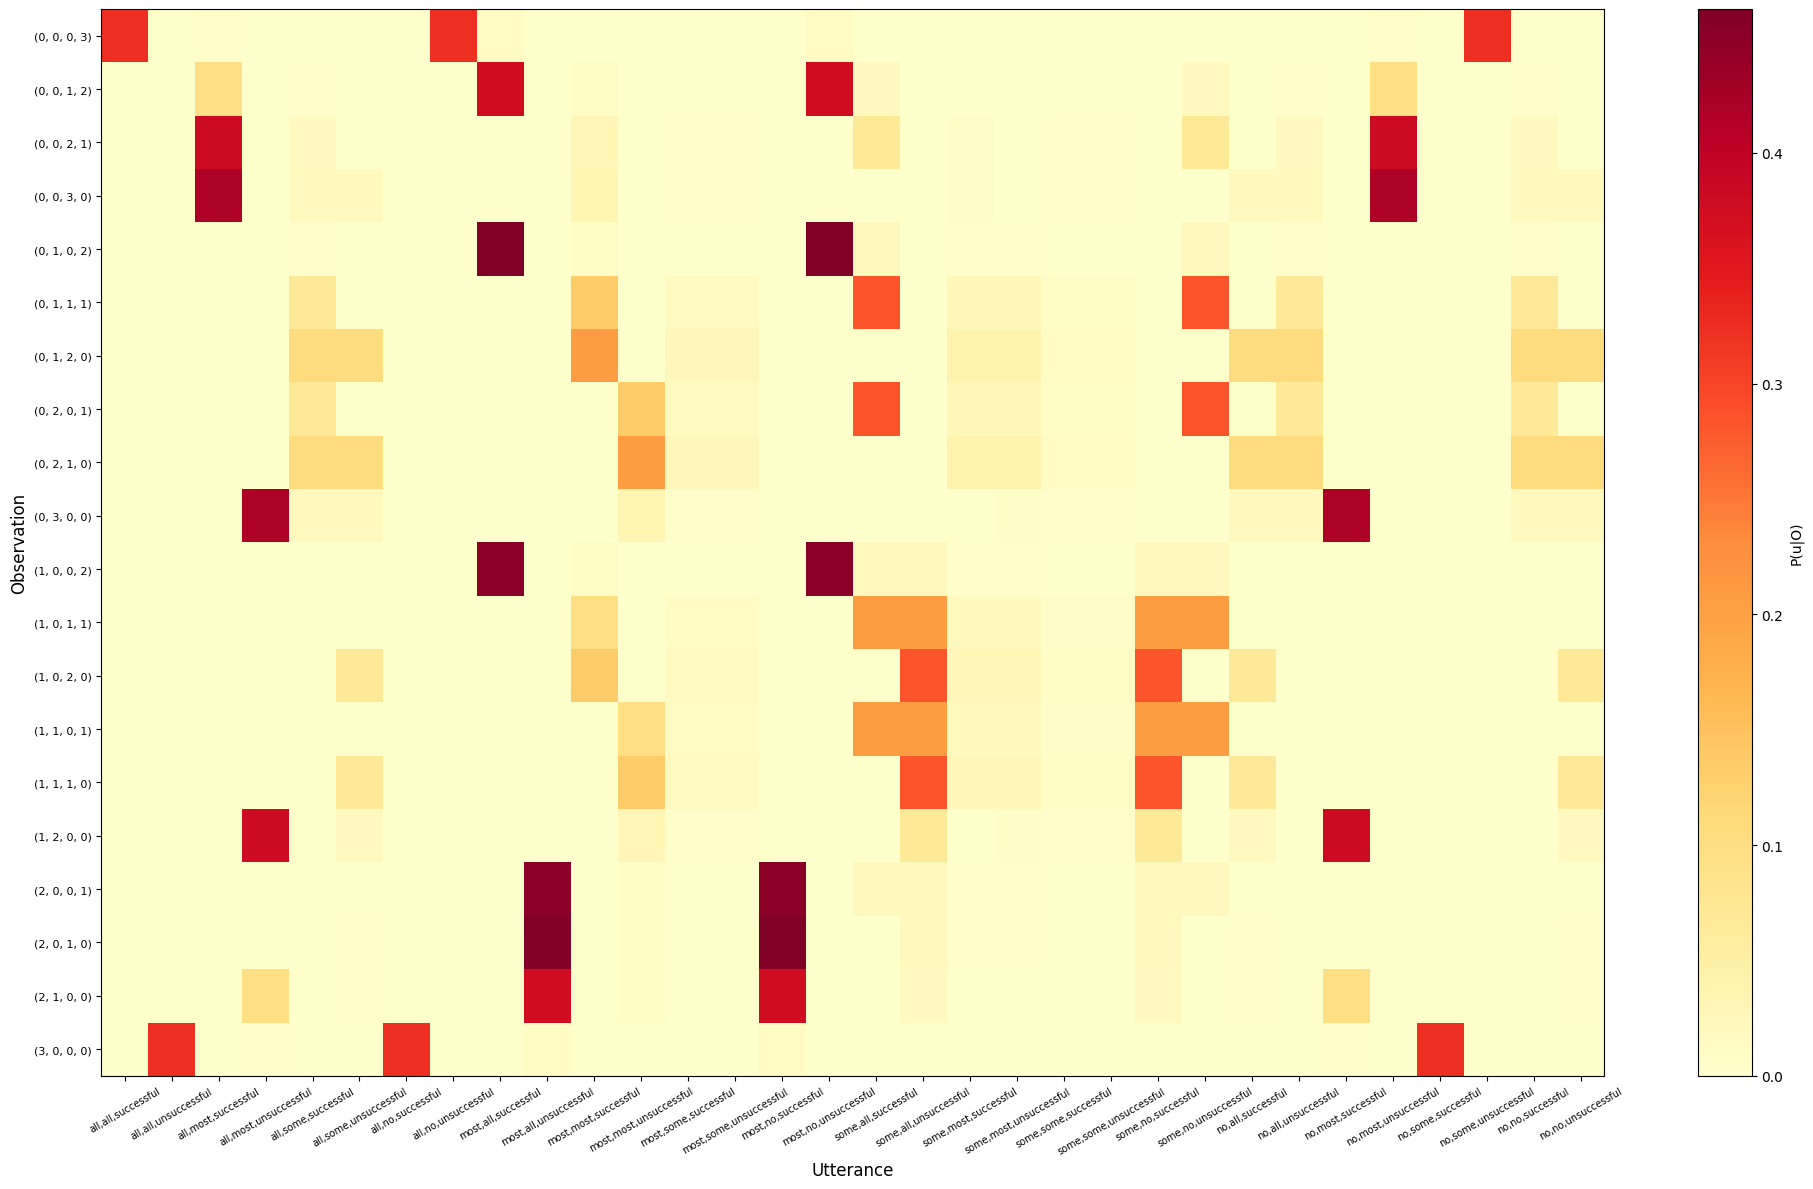

In [16]:
p_u_given_o_s1inform = np.exp(speaker_s1.utterance_log_prob_obs.T.values)

create_bar_plots(p_u_given_o_s1inform, observations, n_utt)
create_heat_map(p_u_given_o_s1inform, observations, utterances)

##### Test B: comprehensive P(theta|u)

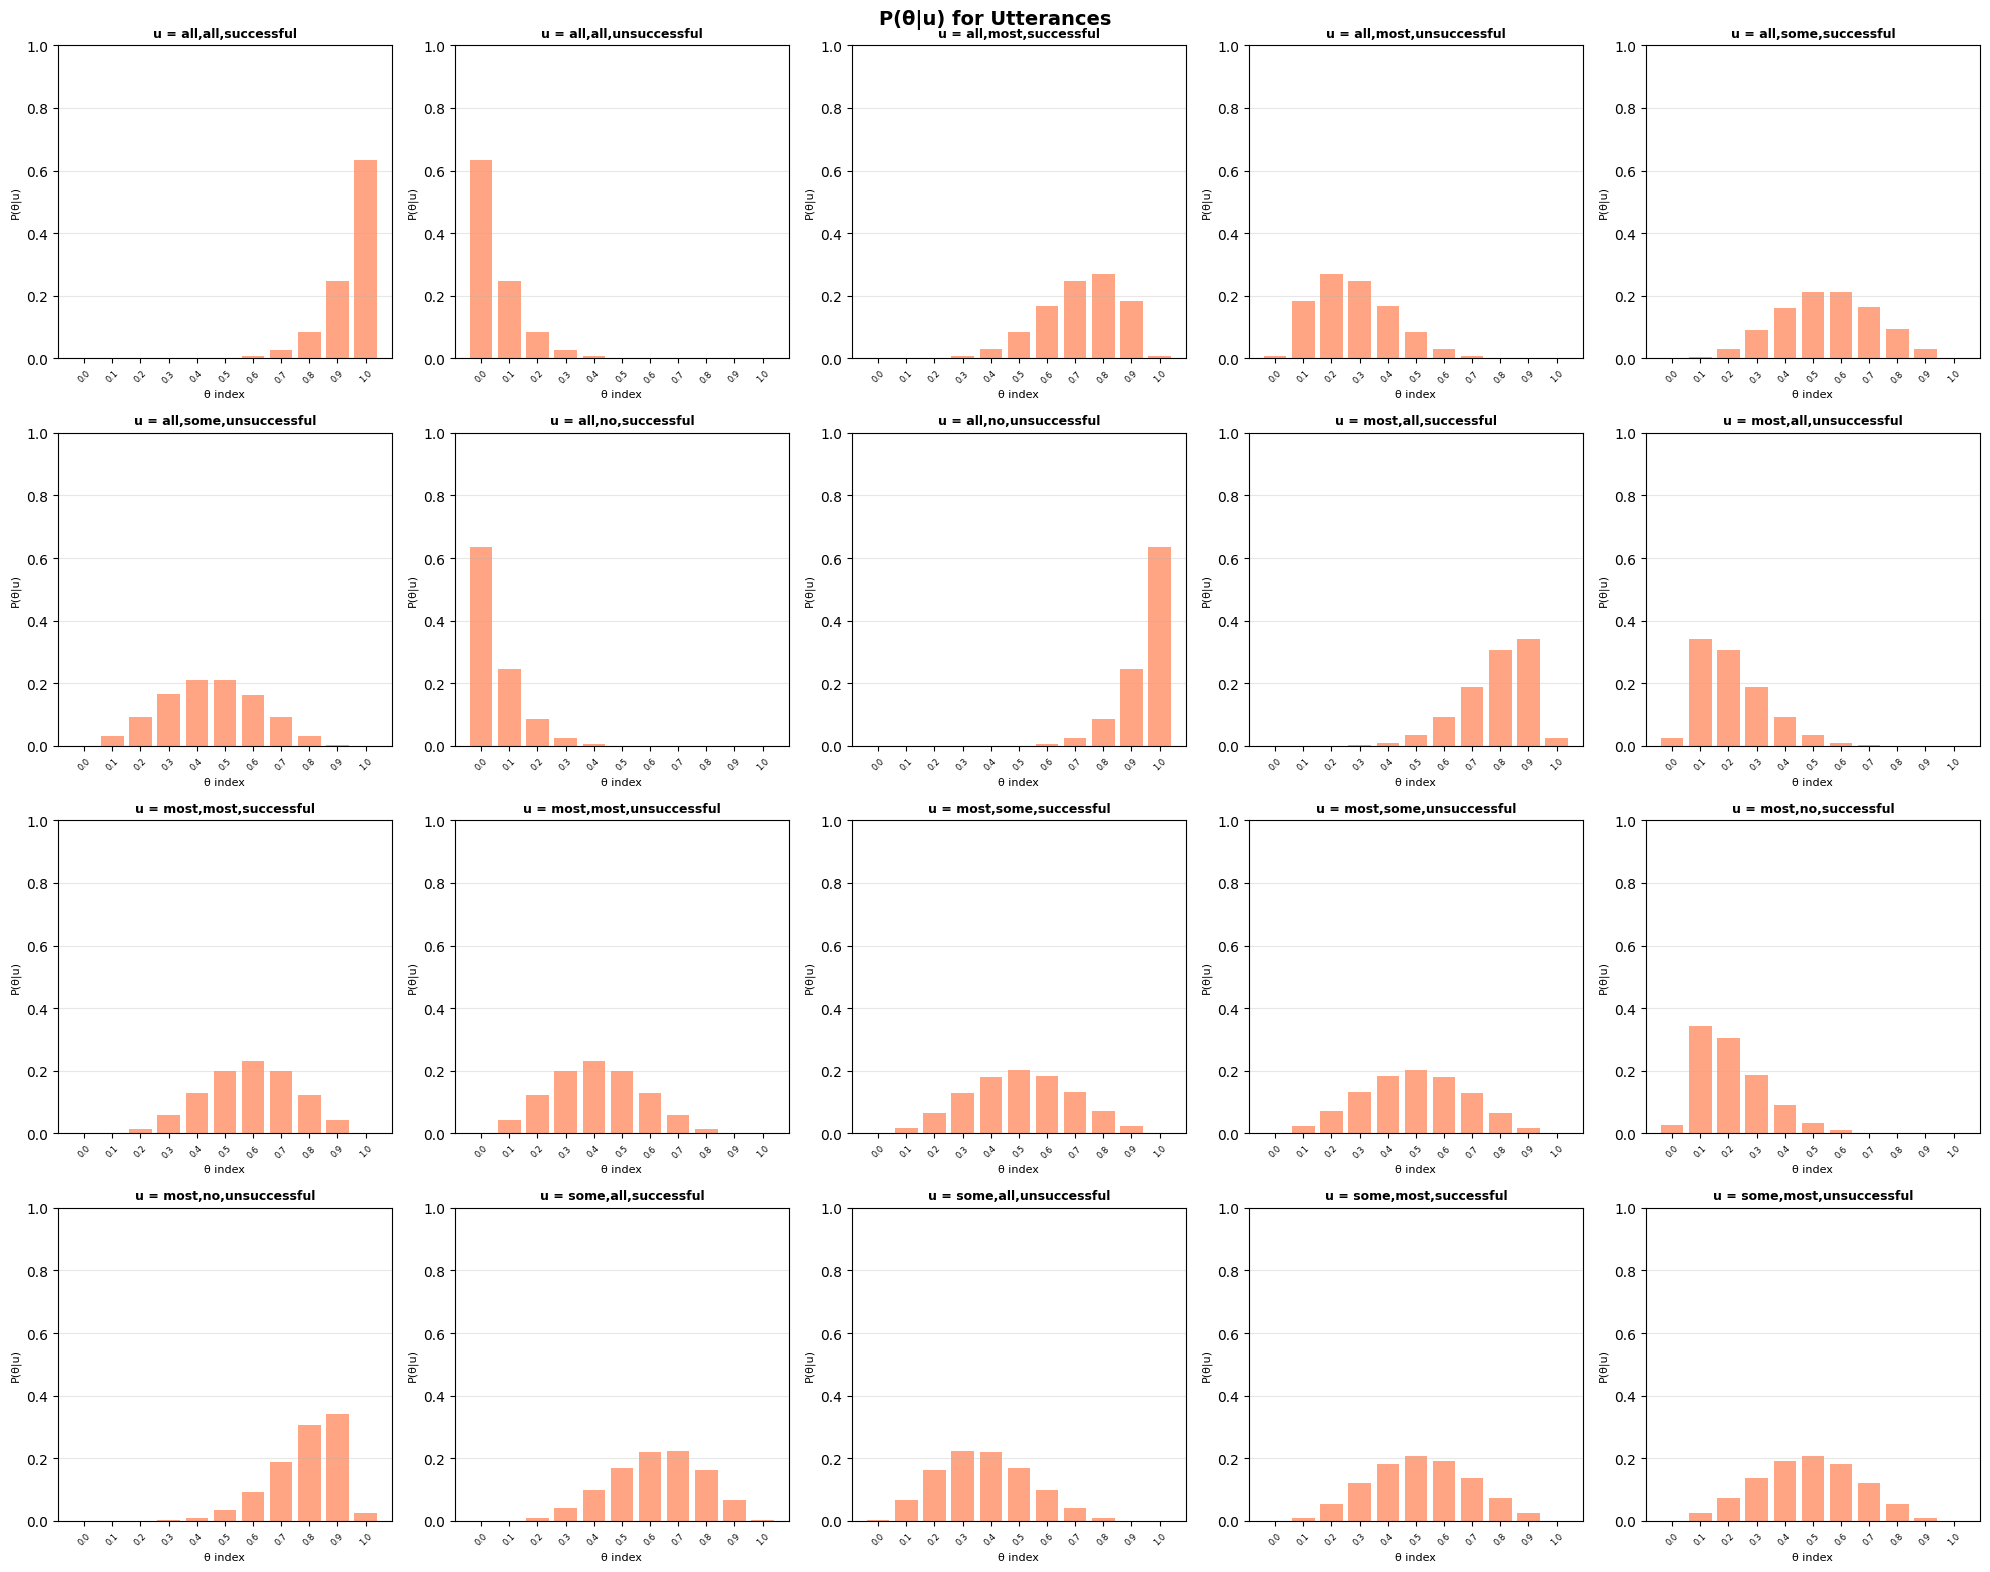

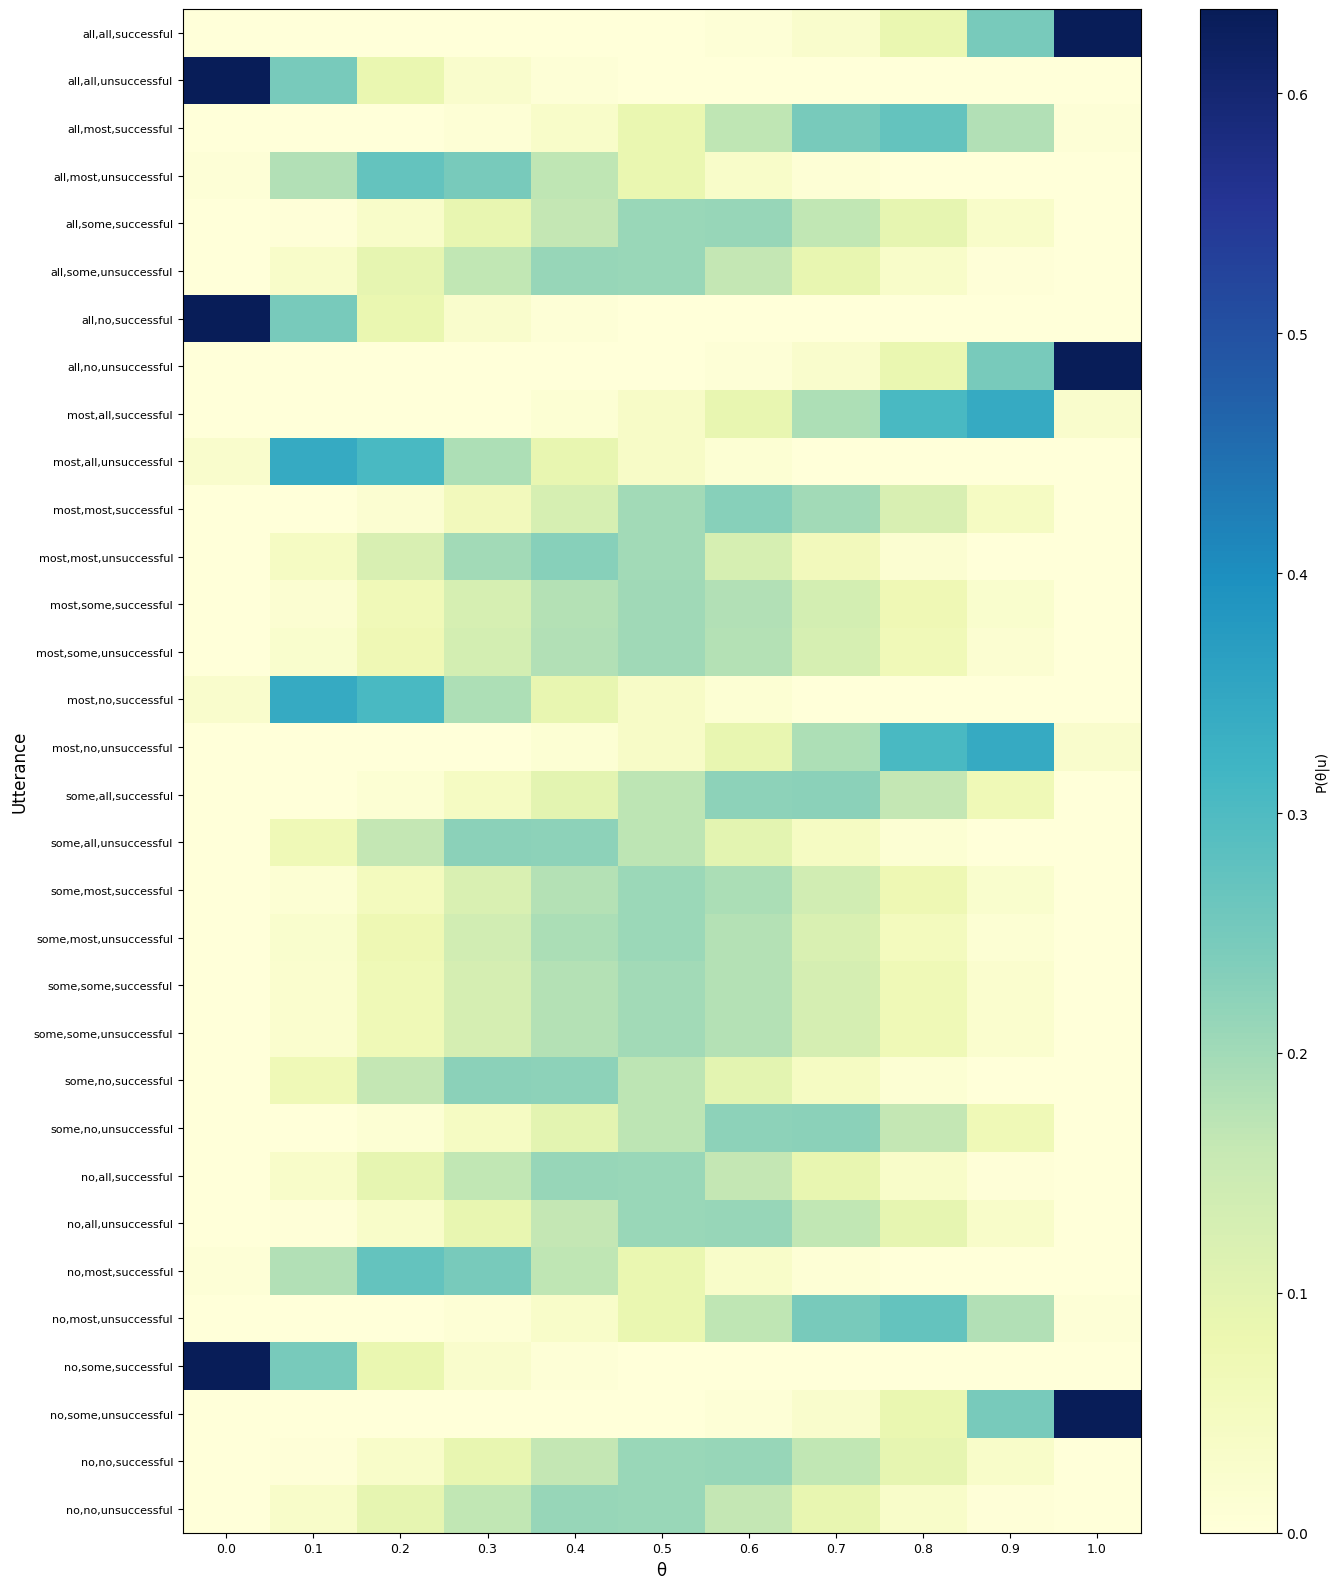

In [17]:
theta_values = world_2.theta_values
n_theta = len(theta_values)

# L1's posterior over theta given utterance
# P_L1(theta | u) is stored in listener_l1_test's internal structures
p_theta_given_u_l1 = np.zeros((n_utt, n_theta))

for i, utt in enumerate(utterances):
    listener_l1_temp = create_listener(
        world=world_2,
        level=1,
        omega="coop",
        update_internal=False,  # Don't update internal models
        alpha=5.0
    )
    # Let L1 hear this utterance
    listener_l1_temp.listen_and_update(utt)
    p_theta_given_u_l1[i, :] = listener_l1_temp.current_belief_theta


create_bar_l(p_theta_given_u_l1, theta_values, utterances)
create_heat_l(p_theta_given_u_l1, theta_values, utterances)

##### Test C: interaction simulation


True theta: 0.7
Initial S1 belief: E[theta] = 0.500
Initial L1 belief: E[theta] = 0.500
Initial errors - S1: 0.2000, L1: 0.2000

Round 1: O=(0, 0, 2, 1), u='all,most,successful'
  S1 E[θ]=0.7264, L1 E[θ]=0.7188
Round 2: O=(0, 1, 1, 1), u='most,some,unsuccessful'
  S1 E[θ]=0.7000, L1 E[θ]=0.7410
Round 3: O=(0, 1, 0, 2), u='most,no,unsuccessful'
  S1 E[θ]=0.7239, L1 E[θ]=0.7834
Round 4: O=(0, 0, 2, 1), u='some,some,unsuccessful'
  S1 E[θ]=0.7368, L1 E[θ]=0.7903
Round 5: O=(0, 0, 3, 0), u='no,all,successful'
  S1 E[θ]=0.7238, L1 E[θ]=0.7500
Round 6: O=(0, 0, 1, 2), u='most,no,unsuccessful'
  S1 E[θ]=0.7511, L1 E[θ]=0.7702
Round 7: O=(1, 0, 1, 1), u='some,no,successful'
  S1 E[θ]=0.7228, L1 E[θ]=0.7297
Round 8: O=(1, 0, 0, 2), u='some,no,successful'
  S1 E[θ]=0.7146, L1 E[θ]=0.6943
Round 9: O=(0, 1, 0, 2), u='most,no,unsuccessful'
  S1 E[θ]=0.7205, L1 E[θ]=0.7150
Round 10: O=(0, 1, 2, 0), u='no,all,successful'
  S1 E[θ]=0.7035, L1 E[θ]=0.6998


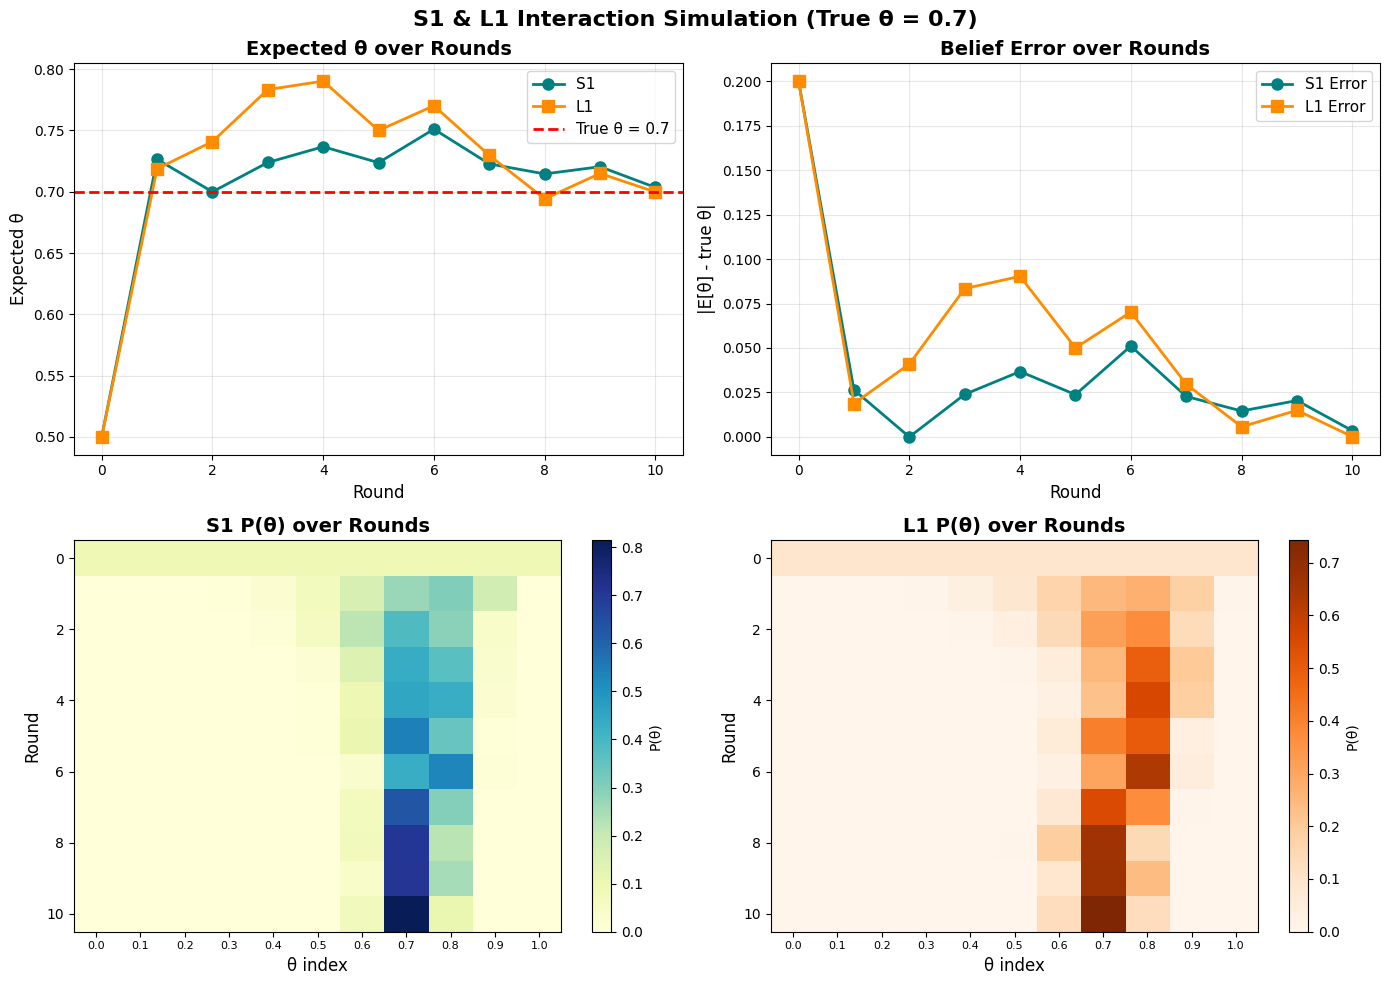

=== Summary ===
Initial S1 Error: 0.2000
Final S1 Error: 0.0035
Initial L1 Error: 0.2000
Final L1 Error: 0.0002


In [18]:
n_rounds = 10
true_theta = 0.7

speaker_s1_sim = create_speaker(
    world=world_2,
    level=1,
    omega="coop",
    psi="inf",
    update_internal=True,
    alpha=5.0,
    beta=1.0
)

# 创建 L1 listener
listener_l1_sim = create_listener(
    world=world_2,
    level=1,
    omega="coop",
    update_internal=True,
    alpha=5.0
)

speaker_beliefs_history = []
listener_beliefs_history = []
speaker_expected_theta = []
listener_expected_theta = []
speaker_errors = []
listener_errors = []
observations_history = []
utterances_history = []

# Record initial beliefs (Round 0 - before any observation)
speaker_beliefs_history.append(speaker_s1_sim.current_belief_theta.copy())
listener_beliefs_history.append(listener_l1_sim.current_belief_theta.copy())

speaker_exp_initial = speaker_s1_sim.current_belief_theta @ world_2.theta_values
listener_exp_initial = listener_l1_sim.current_belief_theta @ world_2.theta_values

speaker_expected_theta.append(speaker_exp_initial)
listener_expected_theta.append(listener_exp_initial)

speaker_errors.append(np.abs(speaker_exp_initial - true_theta))
listener_errors.append(np.abs(listener_exp_initial - true_theta))

print(f"\nTrue theta: {true_theta}")
print(f"Initial S1 belief: E[theta] = {speaker_exp_initial:.3f}")
print(f"Initial L1 belief: E[theta] = {listener_exp_initial:.3f}")
print(f"Initial errors - S1: {speaker_errors[0]:.4f}, L1: {listener_errors[0]:.4f}\n")

# Find true theta index
theta_idx = np.argmin(np.abs(world_2.theta_values - true_theta))

for round_idx in range(n_rounds):
    # Sample observation from true theta
    obs_probs = np.exp(world_2.obs_log_likelihood_theta.iloc[:, theta_idx].values)
    obs_idx = np.random.choice(len(world_2.possible_outcomes), p=obs_probs)
    observation = world_2.possible_outcomes[obs_idx]
    observations_history.append(observation)
    
    # S1 observes and speaks
    utterance = speaker_s1_sim.update_and_speak(observation)
    utterances_history.append(utterance)
    
    # Track speaker belief (AFTER seeing observation)
    speaker_belief = speaker_s1_sim.current_belief_theta
    speaker_beliefs_history.append(speaker_belief.copy())
    speaker_exp = speaker_belief @ world_2.theta_values
    speaker_expected_theta.append(speaker_exp)
    speaker_errors.append(np.abs(speaker_exp - true_theta))
    
    # L1 listens and updates
    listener_l1_sim.listen_and_update(utterance)
    listener_belief = listener_l1_sim.current_belief_theta
    listener_beliefs_history.append(listener_belief.copy())
    listener_exp = listener_belief @ world_2.theta_values
    listener_expected_theta.append(listener_exp)
    listener_errors.append(np.abs(listener_exp - true_theta))
    
    print(f"Round {round_idx+1}: O={observation}, u='{utterance}'")
    print(f"  S1 E[θ]={speaker_exp:.4f}, L1 E[θ]={listener_exp:.4f}")

# Visualization of S1 & L1 interaction results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Expected theta over rounds
ax = axes[0, 0]
ax.plot(range(n_rounds+1), speaker_expected_theta, 'o-', 
        label='S1', linewidth=2, markersize=8, color='teal')
ax.plot(range(n_rounds+1), listener_expected_theta, 's-', 
        label='L1', linewidth=2, markersize=8, color='darkorange')
ax.axhline(y=true_theta, color='r', linestyle='--', 
           linewidth=2, label=f'True θ = {true_theta}')
ax.set_xlabel('Round', fontsize=12)
ax.set_ylabel('Expected θ', fontsize=12)
ax.set_title('Expected θ over Rounds', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# 2. Belief error over rounds
ax = axes[0, 1]
ax.plot(range(n_rounds+1), speaker_errors, 'o-', 
        label='S1 Error', linewidth=2, markersize=8, color='teal')
ax.plot(range(n_rounds+1), listener_errors, 's-', 
        label='L1 Error', linewidth=2, markersize=8, color='darkorange')
ax.set_xlabel('Round', fontsize=12)
ax.set_ylabel('|E[θ] - true θ|', fontsize=12)
ax.set_title('Belief Error over Rounds', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# 3. Speaker belief distribution heatmap
ax = axes[1, 0]
speaker_beliefs_matrix = np.array(speaker_beliefs_history)
im = ax.imshow(speaker_beliefs_matrix, aspect='auto', cmap='YlGnBu')
ax.set_xlabel('θ index', fontsize=12)
ax.set_ylabel('Round', fontsize=12)
ax.set_xticks(range(len(world_2.theta_values)))
ax.set_xticklabels([f'{t:.1f}' for t in world_2.theta_values], fontsize=8)
ax.set_title('S1 P(θ) over Rounds', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='P(θ)')

# 4. Listener belief distribution heatmap
ax = axes[1, 1]
listener_beliefs_matrix = np.array(listener_beliefs_history)
im = ax.imshow(listener_beliefs_matrix, aspect='auto', cmap='Oranges')
ax.set_xlabel('θ index', fontsize=12)
ax.set_ylabel('Round', fontsize=12)
ax.set_xticks(range(len(world_2.theta_values)))
ax.set_xticklabels([f'{t:.1f}' for t in world_2.theta_values], fontsize=8)
ax.set_title('L1 P(θ) over Rounds', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='P(θ)')

plt.suptitle(f'S1 & L1 Interaction Simulation (True θ = {true_theta})', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"=== Summary ===")
print(f"Initial S1 Error: {speaker_errors[0]:.4f}")
print(f"Final S1 Error: {speaker_errors[-1]:.4f}")
print(f"Initial L1 Error: {listener_errors[0]:.4f}")
print(f"Final L1 Error: {listener_errors[-1]:.4f}")


#### 【base (Strat & Perss+)

In [19]:
world_3 = World(
    n=3,
    m=3,
    theta_values=np.linspace(0, 1, 11)
)

speaker_s1_strategic = create_speaker(
    world=world_3,
    level=1,
    omega="strat",         # strategic world
    psi="pers+",           # persuade listener to believe higher theta
    update_internal=True,
    alpha=5.0,
    beta=0               # balance between info and persuasion
)

listener_l1_strategic = create_listener(
    world=world_3,
    level=1,
    omega="strat",         # listener knows it's strategic
    update_internal=True,
    alpha=5.0,
    # L1 will infer which psi the speaker has
    initial_beliefs_psi=np.array([1/3, 1/3, 1/3])  # uniform over pers-, inf, pers+
)

observations = world_3.observations
utterances = world_3.utterances
n_obs = len(observations)
n_utt = len(utterances)

##### Test A: comprehensive P(u|O)

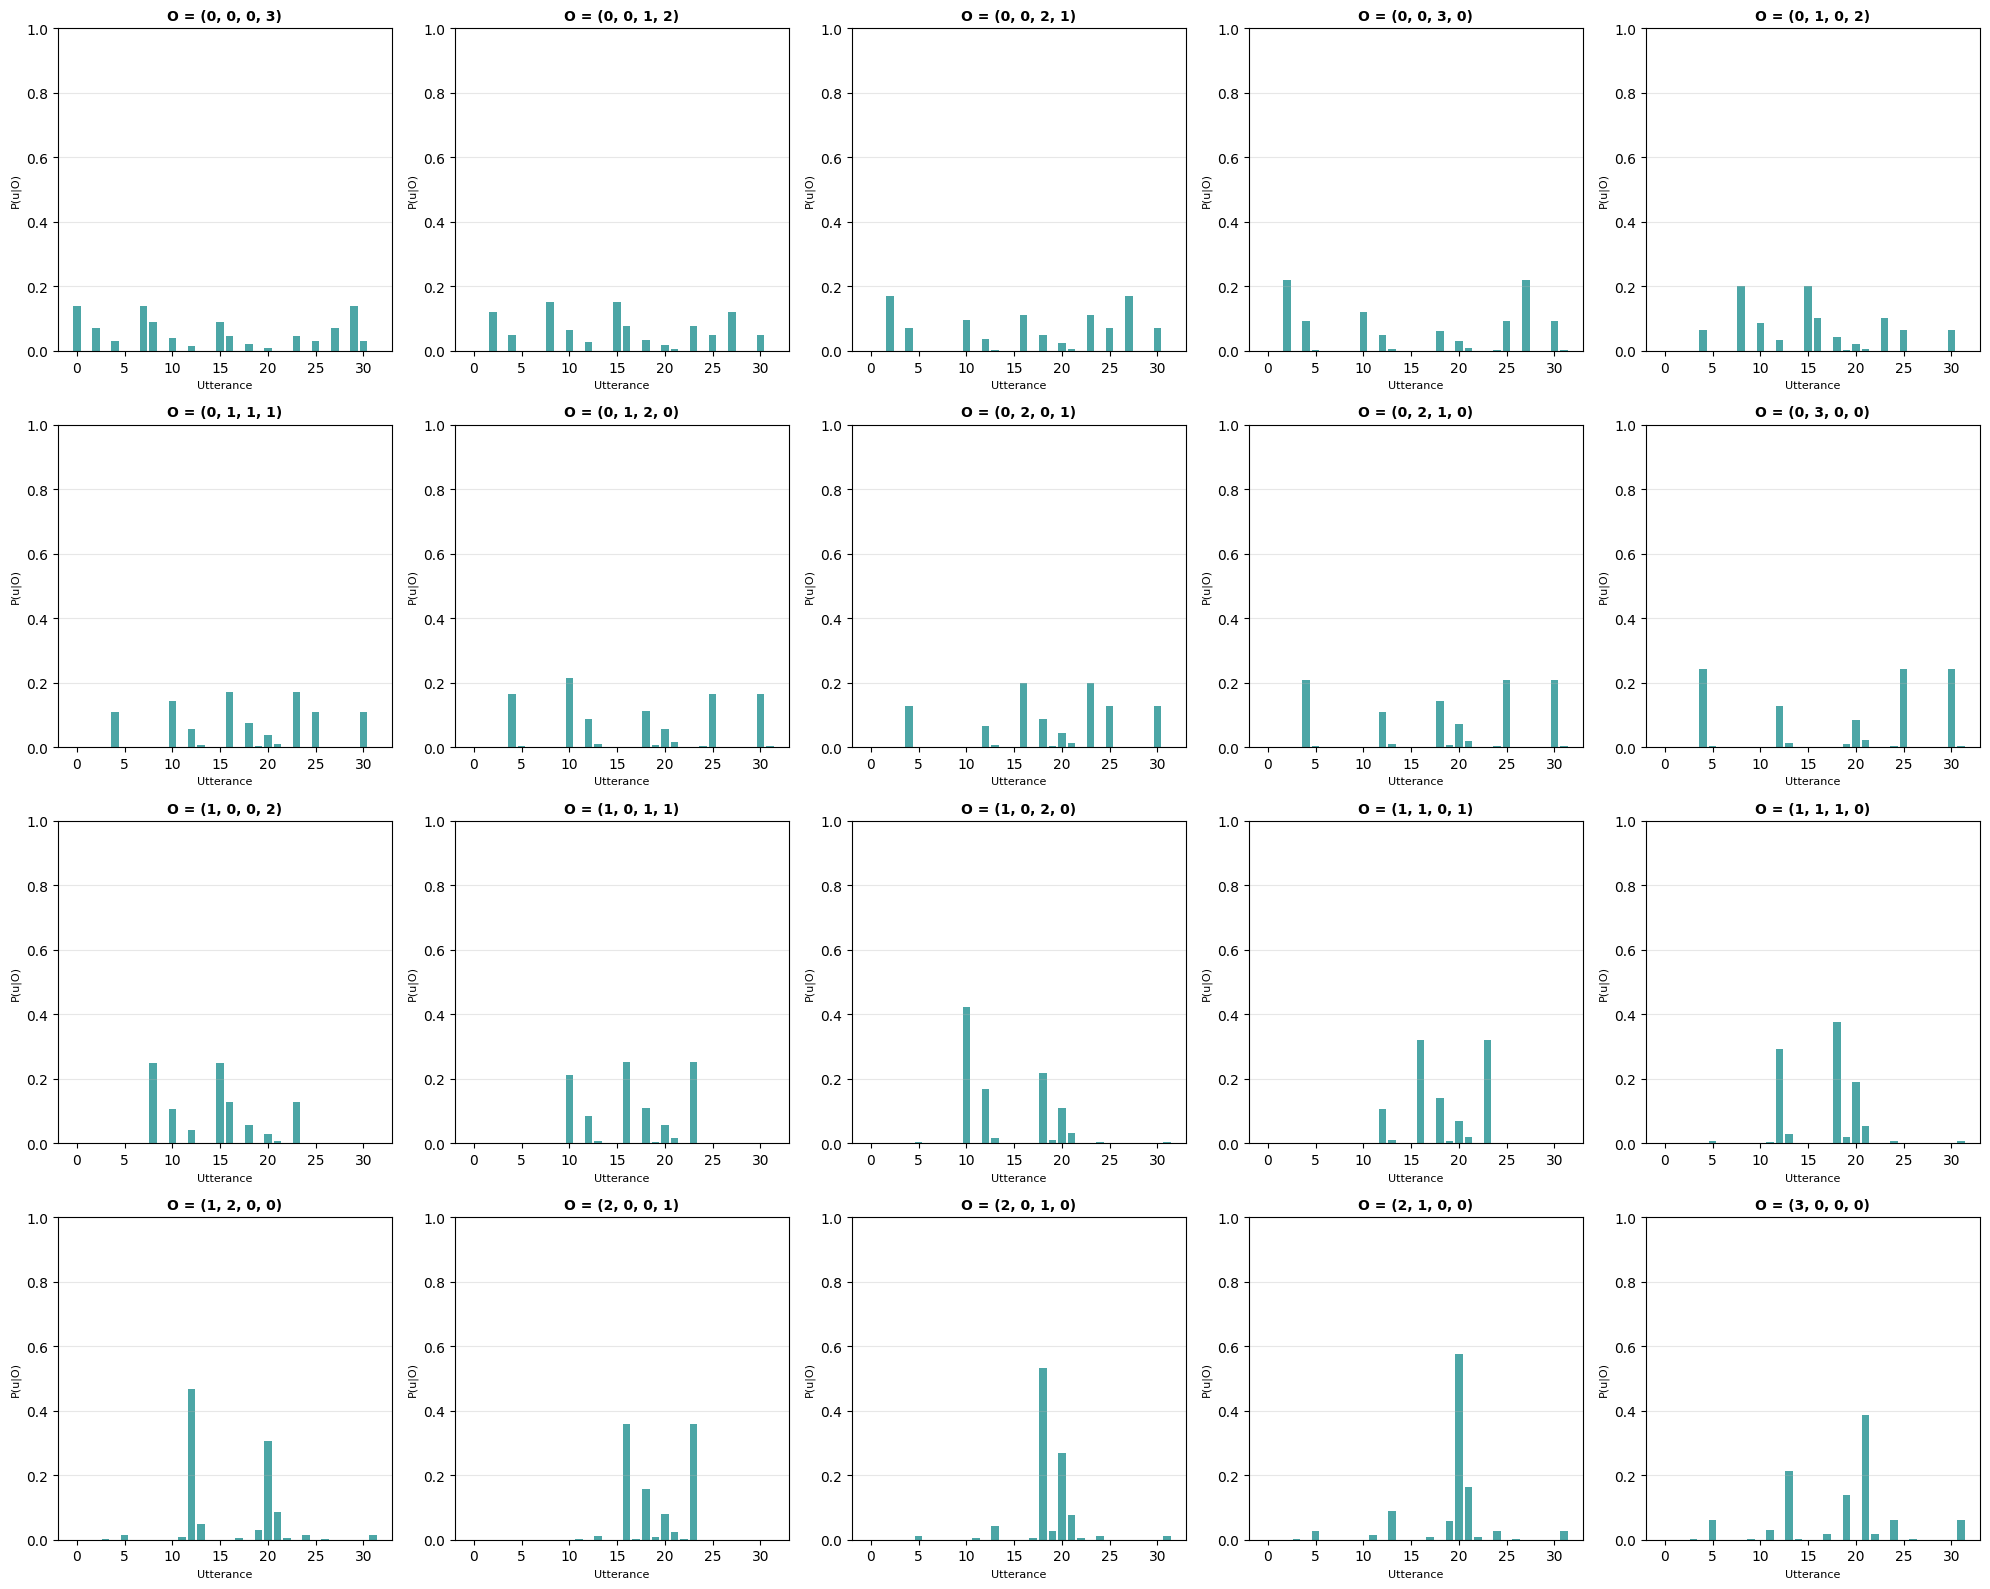

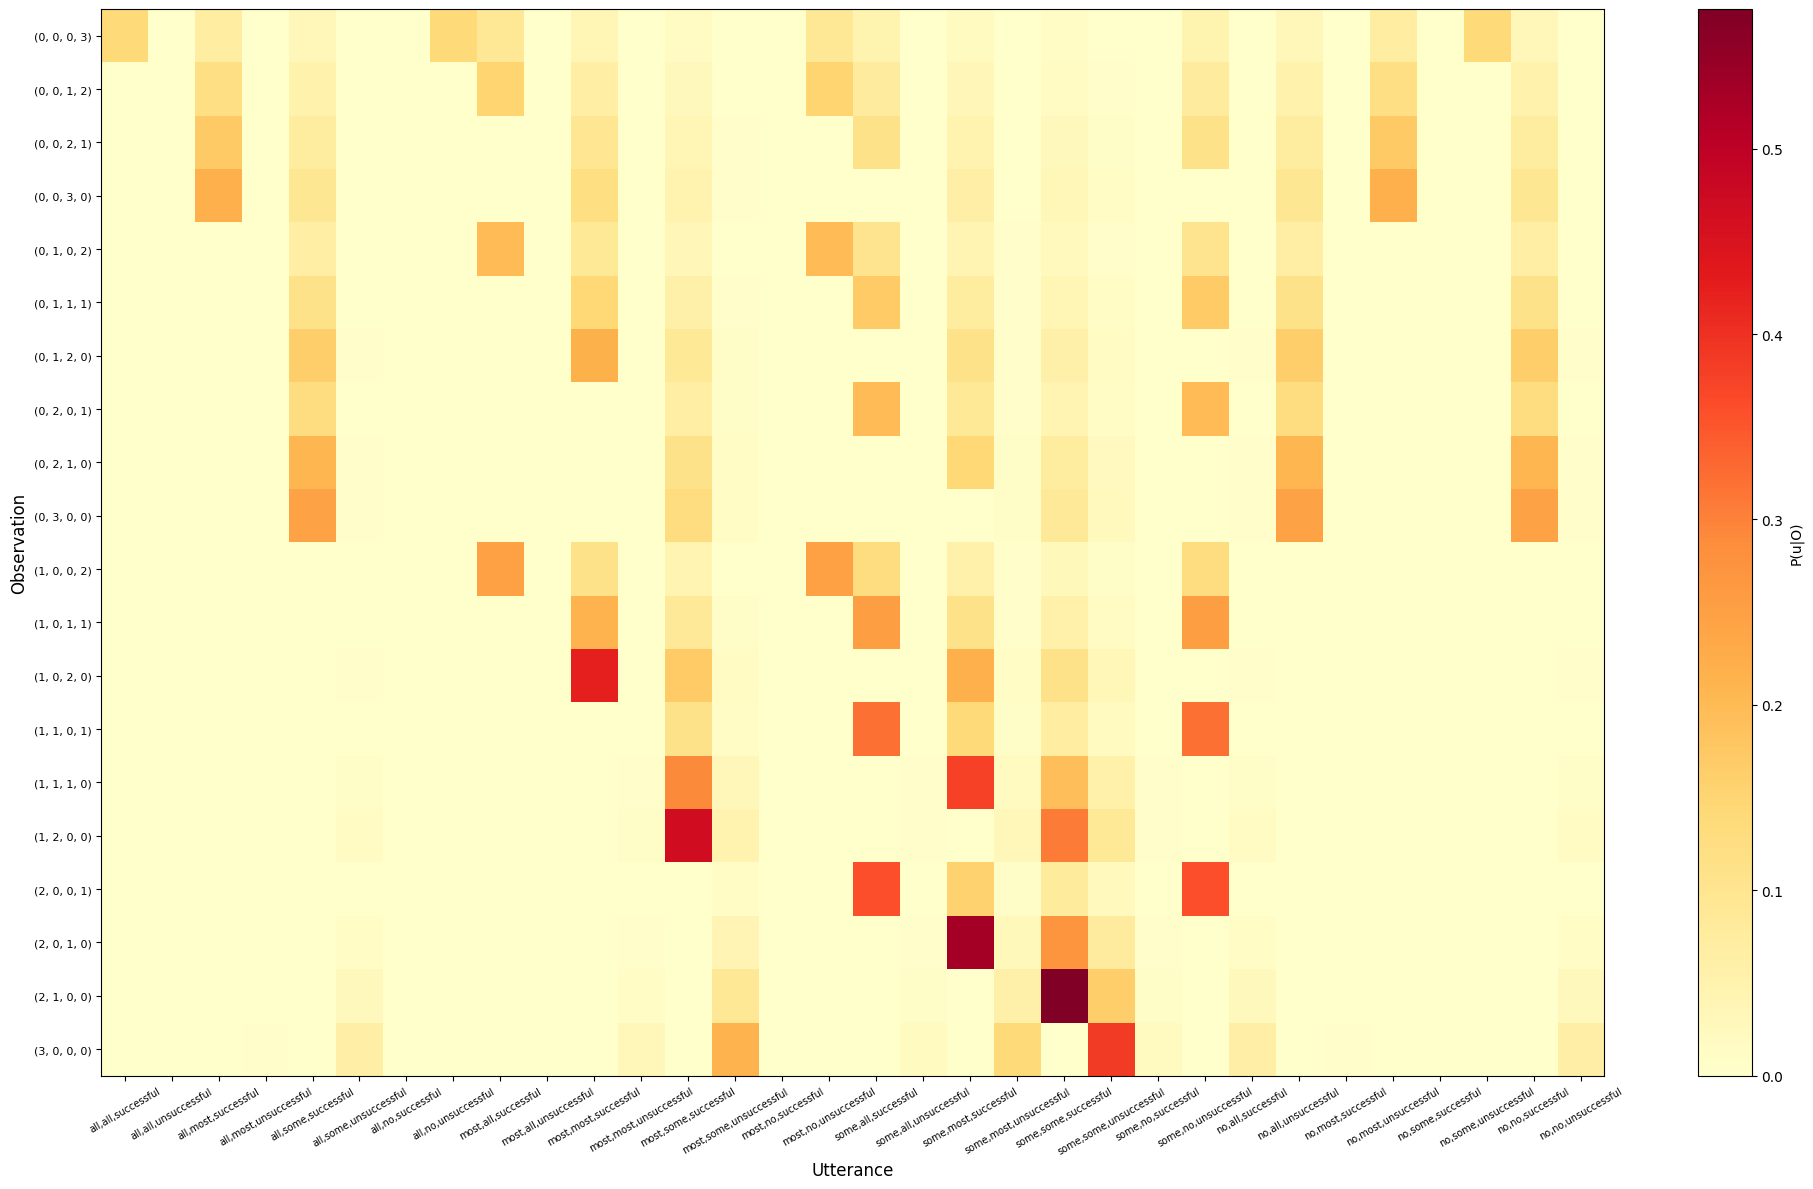

In [20]:
p_u_given_o_s1pu = np.exp(speaker_s1_strategic.utterance_log_prob_obs.T.values)

create_bar_plots(p_u_given_o_s1pu, observations, n_utt)
create_heat_map(p_u_given_o_s1pu, observations, utterances)

##### Test B: comprehensive P(theta|u)

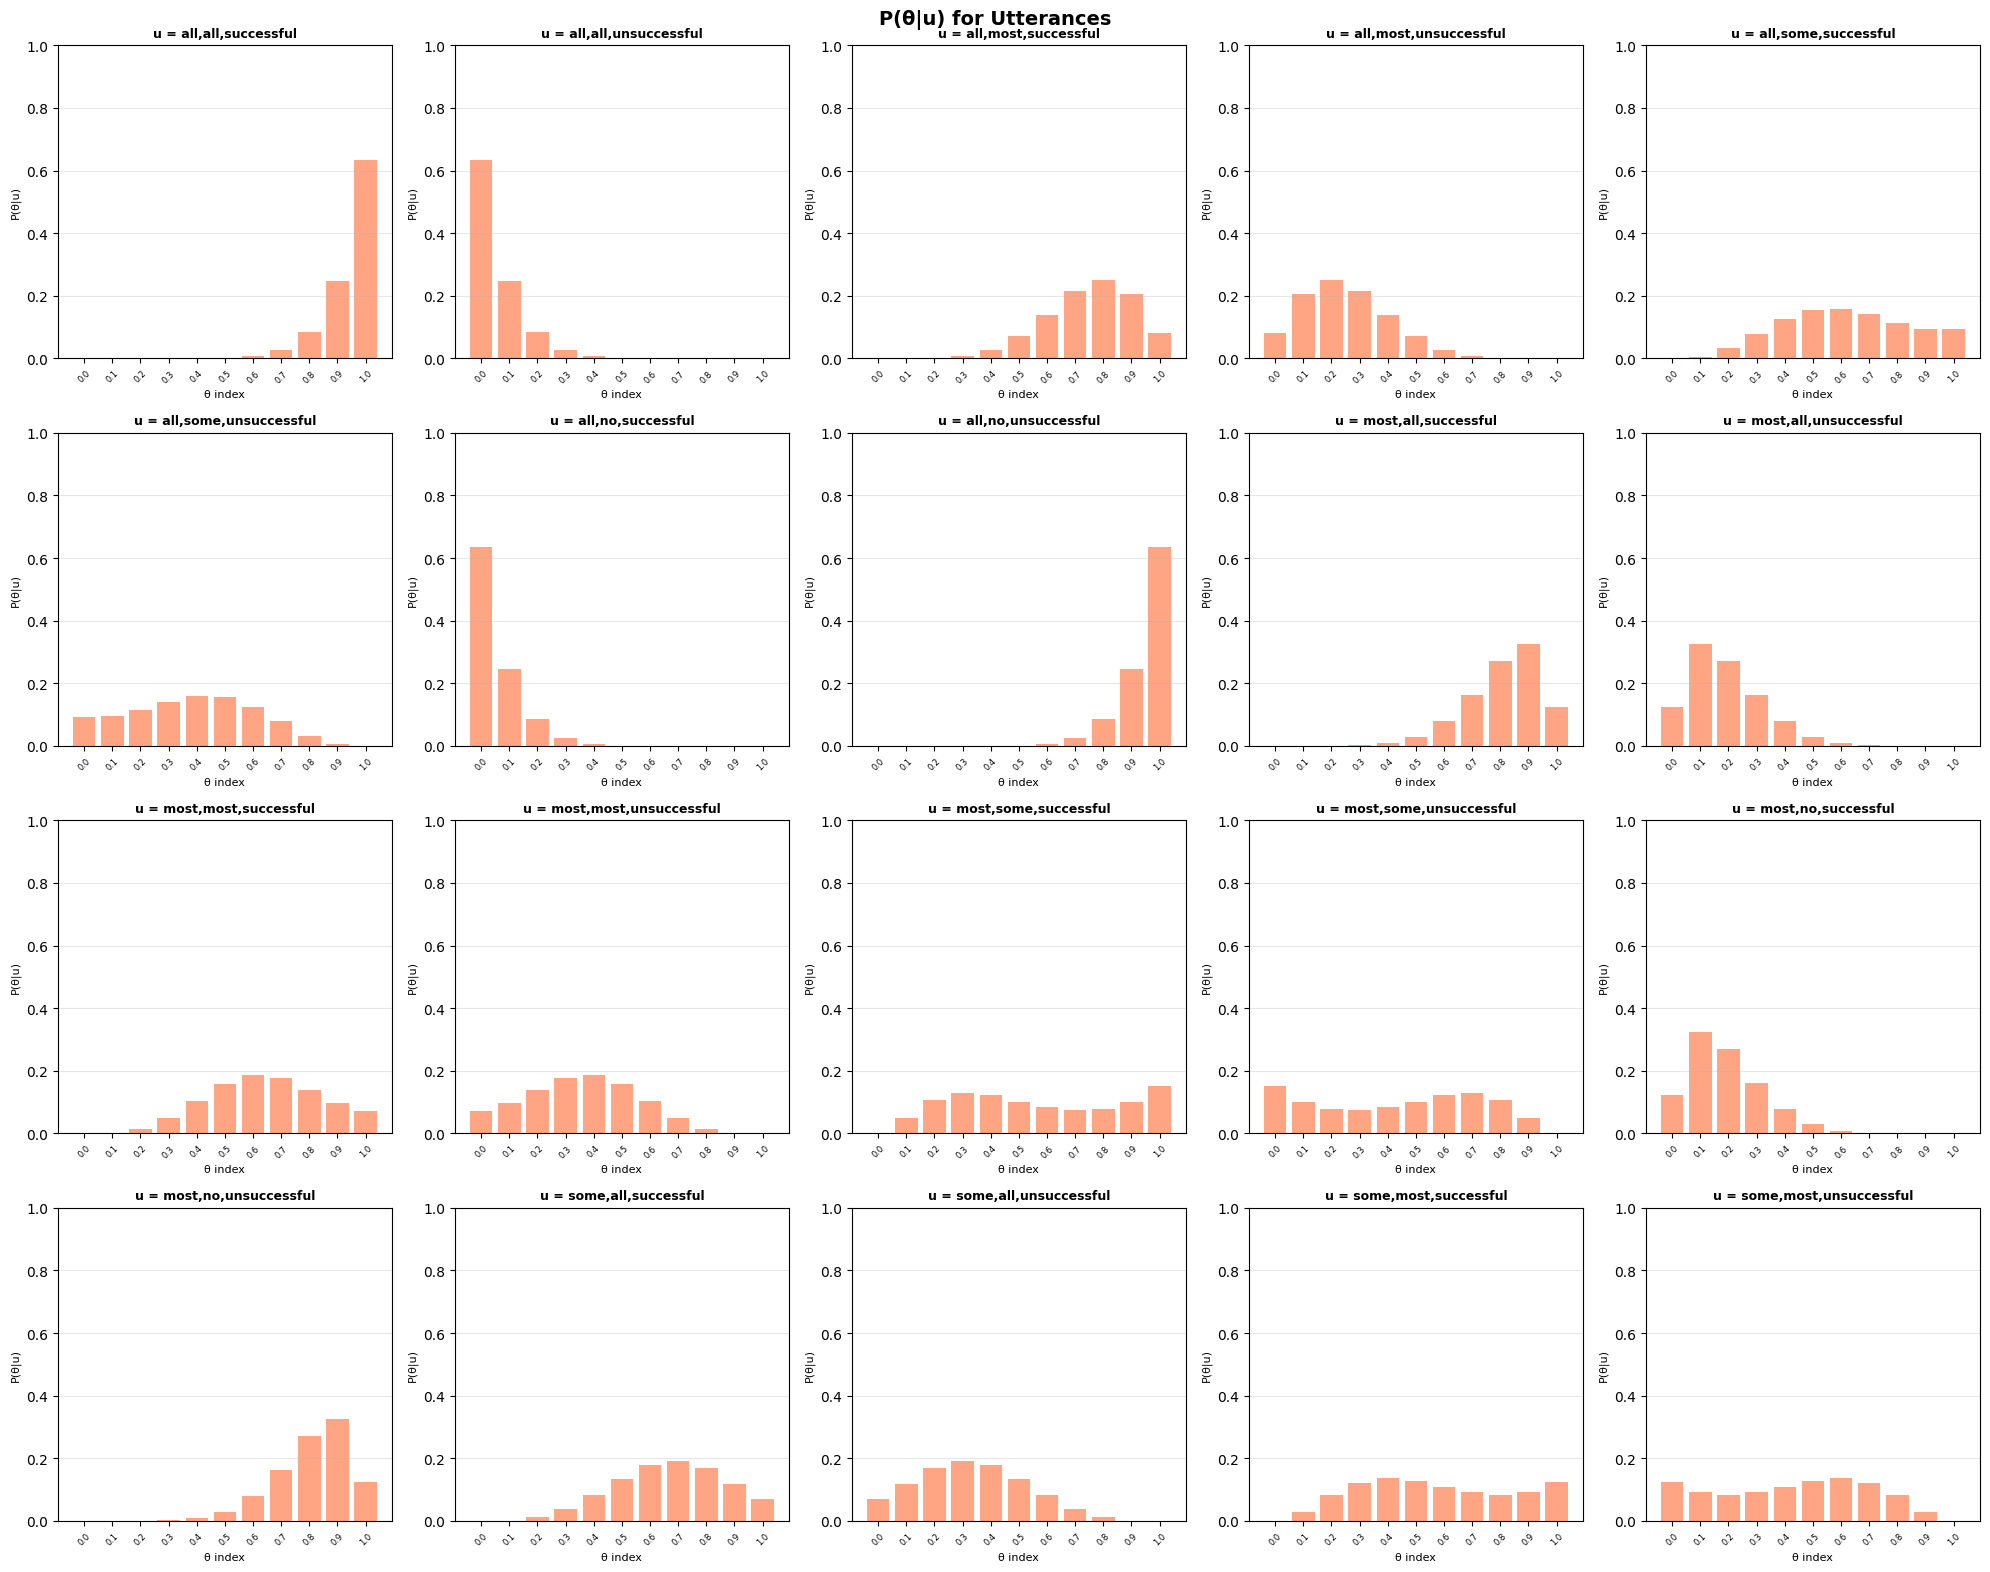

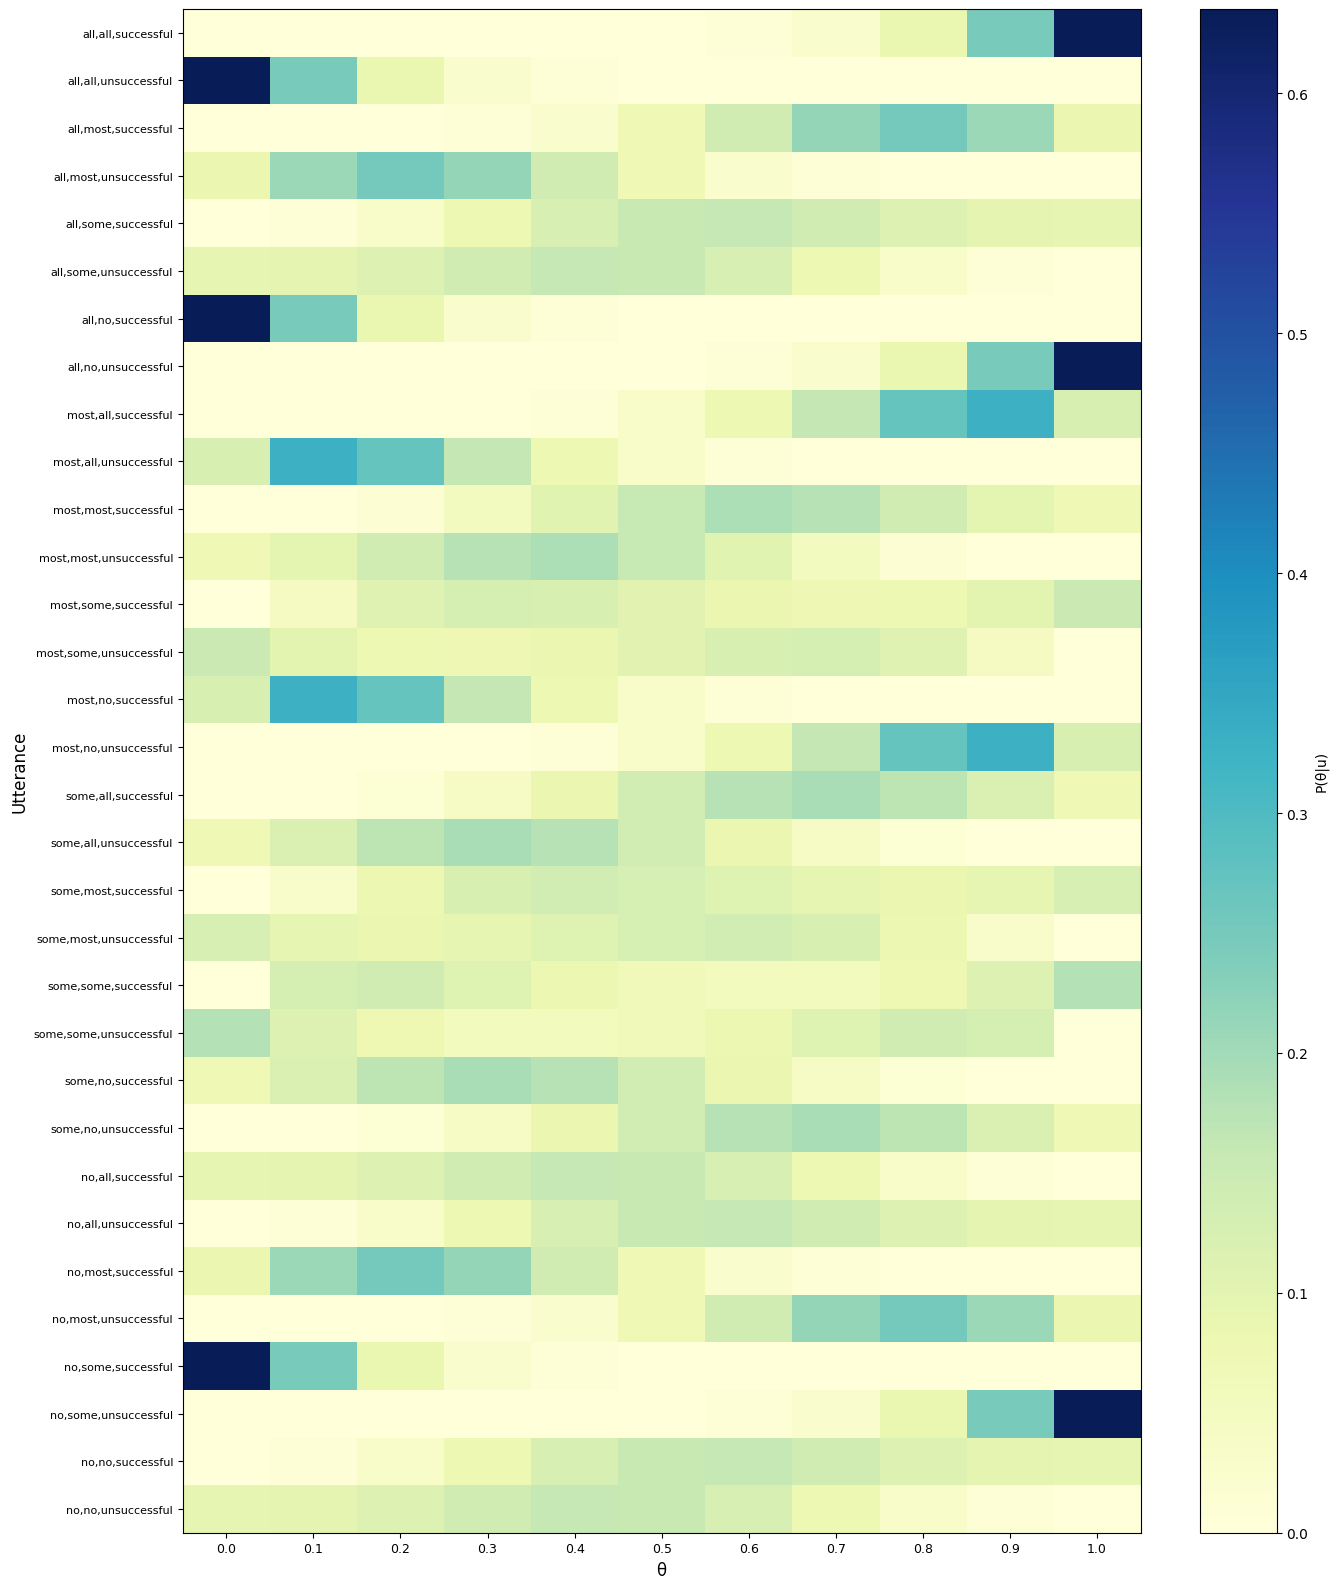

In [21]:
theta_values = world_3.theta_values
n_theta = len(theta_values)

# L1's posterior over theta given utterance
# P_L1(theta | u) is stored in listener_l1_test's internal structures
p_theta_given_u_l1_preU = np.zeros((n_utt, n_theta))

for i, utt in enumerate(utterances):
    listener_l1_temp = create_listener(
        world=world_3,
        level=1,
        omega="strat",         # listener knows it's strategic
        update_internal=True,
        alpha=5.0,
        # L1 will infer which psi the speaker has
        initial_beliefs_psi=np.array([1/3, 1/3, 1/3])  # uniform over pers-, inf, pers+
    )
    # Let L1 hear this utterance
    listener_l1_temp.listen_and_update(utt)
    p_theta_given_u_l1_preU[i, :] = listener_l1_temp.current_belief_theta


create_bar_l(p_theta_given_u_l1_preU, theta_values, utterances)
create_heat_l(p_theta_given_u_l1_preU, theta_values, utterances)

##### Test C: interaction simulation


True theta: 0.7
Initial S1 belief: E[theta] = 0.500
Initial L1 belief: E[theta] = 0.500
Initial errors - S1: 0.2000, L1: 0.2000

Round 1: O=(1, 0, 2, 0), u='most,some,successful'
  S1 E[θ]=0.4545, L1 E[θ]=0.5723
Round 2: O=(0, 0, 1, 2), u='all,most,successful'
  S1 E[θ]=0.6500, L1 E[θ]=0.7038
Round 3: O=(1, 1, 1, 0), u='some,most,successful'
  S1 E[θ]=0.5517, L1 E[θ]=0.7009
Round 4: O=(0, 0, 2, 1), u='most,most,successful'
  S1 E[θ]=0.6053, L1 E[θ]=0.7269
Round 5: O=(0, 1, 1, 1), u='some,no,unsuccessful'
  S1 E[θ]=0.6170, L1 E[θ]=0.7552
Round 6: O=(0, 0, 1, 2), u='some,some,successful'
  S1 E[θ]=0.6608, L1 E[θ]=0.7547
Round 7: O=(0, 3, 0, 0), u='some,some,unsuccessful'
  S1 E[θ]=0.6152, L1 E[θ]=0.6712
Round 8: O=(0, 0, 2, 1), u='most,some,successful'
  S1 E[θ]=0.6351, L1 E[θ]=0.6633
Round 9: O=(0, 0, 2, 1), u='some,some,successful'
  S1 E[θ]=0.6516, L1 E[θ]=0.6536
Round 10: O=(0, 0, 2, 1), u='some,most,successful'
  S1 E[θ]=0.6655, L1 E[θ]=0.6530


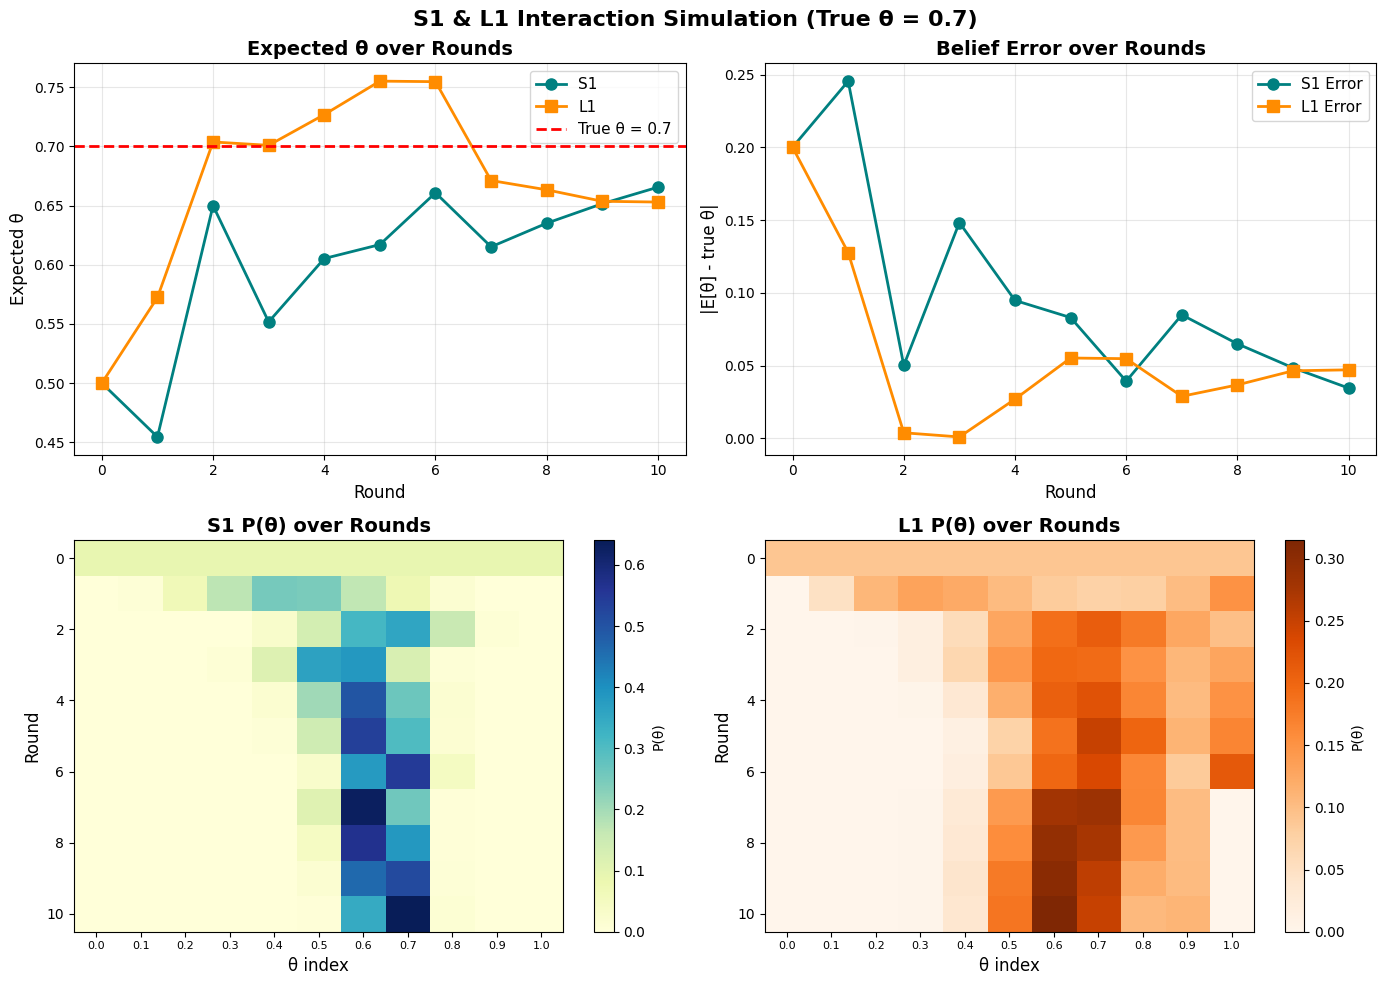

=== Summary ===
Initial S1 Error: 0.2000
Final S1 Error: 0.0345
Initial L1 Error: 0.2000
Final L1 Error: 0.0470


In [22]:
n_rounds = 10
true_theta = 0.7

speaker_s1_strategic = create_speaker(
    world=world_3,
    level=1,
    omega="strat",         # strategic world
    psi="pers+",           # persuade listener to believe higher theta
    update_internal=True,
    alpha=5.0,
    beta=0               # 0.5 to balance between info and persuasion
)

listener_l1_strategic = create_listener(
    world=world_3,
    level=1,
    omega="strat",         # listener knows it's strategic
    update_internal=True,
    alpha=5.0,
    # L1 will infer which psi the speaker has
    initial_beliefs_psi=np.array([1/3, 1/3, 1/3])  # uniform over pers-, inf, pers+
)

speaker_beliefs_history = []
listener_beliefs_history = []
speaker_expected_theta = []
listener_expected_theta = []
speaker_errors = []
listener_errors = []
observations_history = []
utterances_history = []

# Record initial beliefs (Round 0 - before any observation)
speaker_beliefs_history.append(speaker_s1_strategic.current_belief_theta.copy())
listener_beliefs_history.append(listener_l1_strategic.current_belief_theta.copy())

speaker_exp_initial = speaker_s1_strategic.current_belief_theta @ world_3.theta_values
listener_exp_initial = listener_l1_strategic.current_belief_theta @ world_3.theta_values

speaker_expected_theta.append(speaker_exp_initial)
listener_expected_theta.append(listener_exp_initial)

speaker_errors.append(np.abs(speaker_exp_initial - true_theta))
listener_errors.append(np.abs(listener_exp_initial - true_theta))

print(f"\nTrue theta: {true_theta}")
print(f"Initial S1 belief: E[theta] = {speaker_exp_initial:.3f}")
print(f"Initial L1 belief: E[theta] = {listener_exp_initial:.3f}")
print(f"Initial errors - S1: {speaker_errors[0]:.4f}, L1: {listener_errors[0]:.4f}\n")

# Find true theta index
theta_idx = np.argmin(np.abs(world_3.theta_values - true_theta))

for round_idx in range(n_rounds):
    # Sample observation from true theta
    obs_probs = np.exp(world_3.obs_log_likelihood_theta.iloc[:, theta_idx].values)
    obs_idx = np.random.choice(len(world_3.possible_outcomes), p=obs_probs)
    observation = world_3.possible_outcomes[obs_idx]
    observations_history.append(observation)
    
    # S1 observes and speaks
    utterance = speaker_s1_strategic.update_and_speak(observation)
    utterances_history.append(utterance)
    
    # Track speaker belief (AFTER seeing observation)
    speaker_belief = speaker_s1_strategic.current_belief_theta
    speaker_beliefs_history.append(speaker_belief.copy())
    speaker_exp = speaker_belief @ world_3.theta_values
    speaker_expected_theta.append(speaker_exp)
    speaker_errors.append(np.abs(speaker_exp - true_theta))
    
    # L1 listens and updates
    listener_l1_strategic.listen_and_update(utterance)
    listener_belief = listener_l1_strategic.current_belief_theta
    listener_beliefs_history.append(listener_belief.copy())
    listener_exp = listener_belief @ world_3.theta_values
    listener_expected_theta.append(listener_exp)
    listener_errors.append(np.abs(listener_exp - true_theta))
    
    print(f"Round {round_idx+1}: O={observation}, u='{utterance}'")
    print(f"  S1 E[θ]={speaker_exp:.4f}, L1 E[θ]={listener_exp:.4f}")

# Visualization of S1 & L1 interaction results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Expected theta over rounds
ax = axes[0, 0]
ax.plot(range(n_rounds+1), speaker_expected_theta, 'o-', 
        label='S1', linewidth=2, markersize=8, color='teal')
ax.plot(range(n_rounds+1), listener_expected_theta, 's-', 
        label='L1', linewidth=2, markersize=8, color='darkorange')
ax.axhline(y=true_theta, color='r', linestyle='--', 
           linewidth=2, label=f'True θ = {true_theta}')
ax.set_xlabel('Round', fontsize=12)
ax.set_ylabel('Expected θ', fontsize=12)
ax.set_title('Expected θ over Rounds', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# 2. Belief error over rounds
ax = axes[0, 1]
ax.plot(range(n_rounds+1), speaker_errors, 'o-', 
        label='S1 Error', linewidth=2, markersize=8, color='teal')
ax.plot(range(n_rounds+1), listener_errors, 's-', 
        label='L1 Error', linewidth=2, markersize=8, color='darkorange')
ax.set_xlabel('Round', fontsize=12)
ax.set_ylabel('|E[θ] - true θ|', fontsize=12)
ax.set_title('Belief Error over Rounds', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# 3. Speaker belief distribution heatmap
ax = axes[1, 0]
speaker_beliefs_matrix = np.array(speaker_beliefs_history)
im = ax.imshow(speaker_beliefs_matrix, aspect='auto', cmap='YlGnBu')
ax.set_xlabel('θ index', fontsize=12)
ax.set_ylabel('Round', fontsize=12)
ax.set_xticks(range(len(world_3.theta_values)))
ax.set_xticklabels([f'{t:.1f}' for t in world_3.theta_values], fontsize=8)
ax.set_title('S1 P(θ) over Rounds', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='P(θ)')

# 4. Listener belief distribution heatmap
ax = axes[1, 1]
listener_beliefs_matrix = np.array(listener_beliefs_history)
im = ax.imshow(listener_beliefs_matrix, aspect='auto', cmap='Oranges')
ax.set_xlabel('θ index', fontsize=12)
ax.set_ylabel('Round', fontsize=12)
ax.set_xticks(range(len(world_3.theta_values)))
ax.set_xticklabels([f'{t:.1f}' for t in world_3.theta_values], fontsize=8)
ax.set_title('L1 P(θ) over Rounds', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='P(θ)')

plt.suptitle(f'S1 & L1 Interaction Simulation (True θ = {true_theta})', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"=== Summary ===")
print(f"Initial S1 Error: {speaker_errors[0]:.4f}")
print(f"Final S1 Error: {speaker_errors[-1]:.4f}")
print(f"Initial L1 Error: {listener_errors[0]:.4f}")
print(f"Final L1 Error: {listener_errors[-1]:.4f}")


#### 【memo (Info)

In [23]:
"""
Compute P(obs | u) = Σ_θ P(obs|θ) × P(θ|u)

This marginalizes over theta:
1. First infer P(θ|u) using Bayesian update
2. Then compute P(obs|u) by marginalizing over θ
"""
# Return P(obs | u) - marginalized over theta

@memo
def L0_obs[_u: U, _obs: Obs](prior: ...):
    listener: knows(_u, _obs)
    listener: thinks[
        world: chooses(theta in Theta, wpp=array_index(prior, theta)),
        world: chooses(obs in Obs, wpp=get_obs_prob(obs, theta)),
        world: chooses(u in U, wpp=get_utt_prob(u, obs))
    ]
    listener: observes [world.u] is _u
    return listener[Pr[world.obs == _obs]]

"""
Informed speaker who knows the true observation.

Chooses utterances to maximize P(obs_true | u), where the listener uses L0_obs reasoning.
"""
@memo
def S1_inf[_obs: Obs, _u: U](prior: ..., alpha):
    speaker: knows(_obs, _u)
    speaker: chooses(
        u in U, 
        wpp=is_utt_true_for_obs(u, _obs) * exp(alpha * log(L0_obs[u, _obs](prior) + 1e-10))
    )
    return Pr[speaker.u == _u]

@memo
def L1_cred[_u: U, _theta: Theta](prior: ..., alpha):
    """
    L1 listener who infers theta from utterance u,
    assuming speaker is S1_inf (informed speaker)
    """
    listener: knows(_u, _theta)
    listener: thinks[
        world: chooses(theta in Theta, wpp=array_index(prior, theta)),
        world: chooses(obs in Obs, wpp=get_obs_prob(obs, theta)),
        speaker: knows(world.obs),
        speaker: chooses(
            u in U,
            wpp=is_utt_true_for_obs(u, world.obs) * exp(alpha * log(L0_obs[u, world.obs](prior) + 1e-10))
        )
    ]
    listener: observes[speaker.u] is _u
    return listener[Pr[world.theta == _theta]]

##### Test A: comprehensive P(u|O)

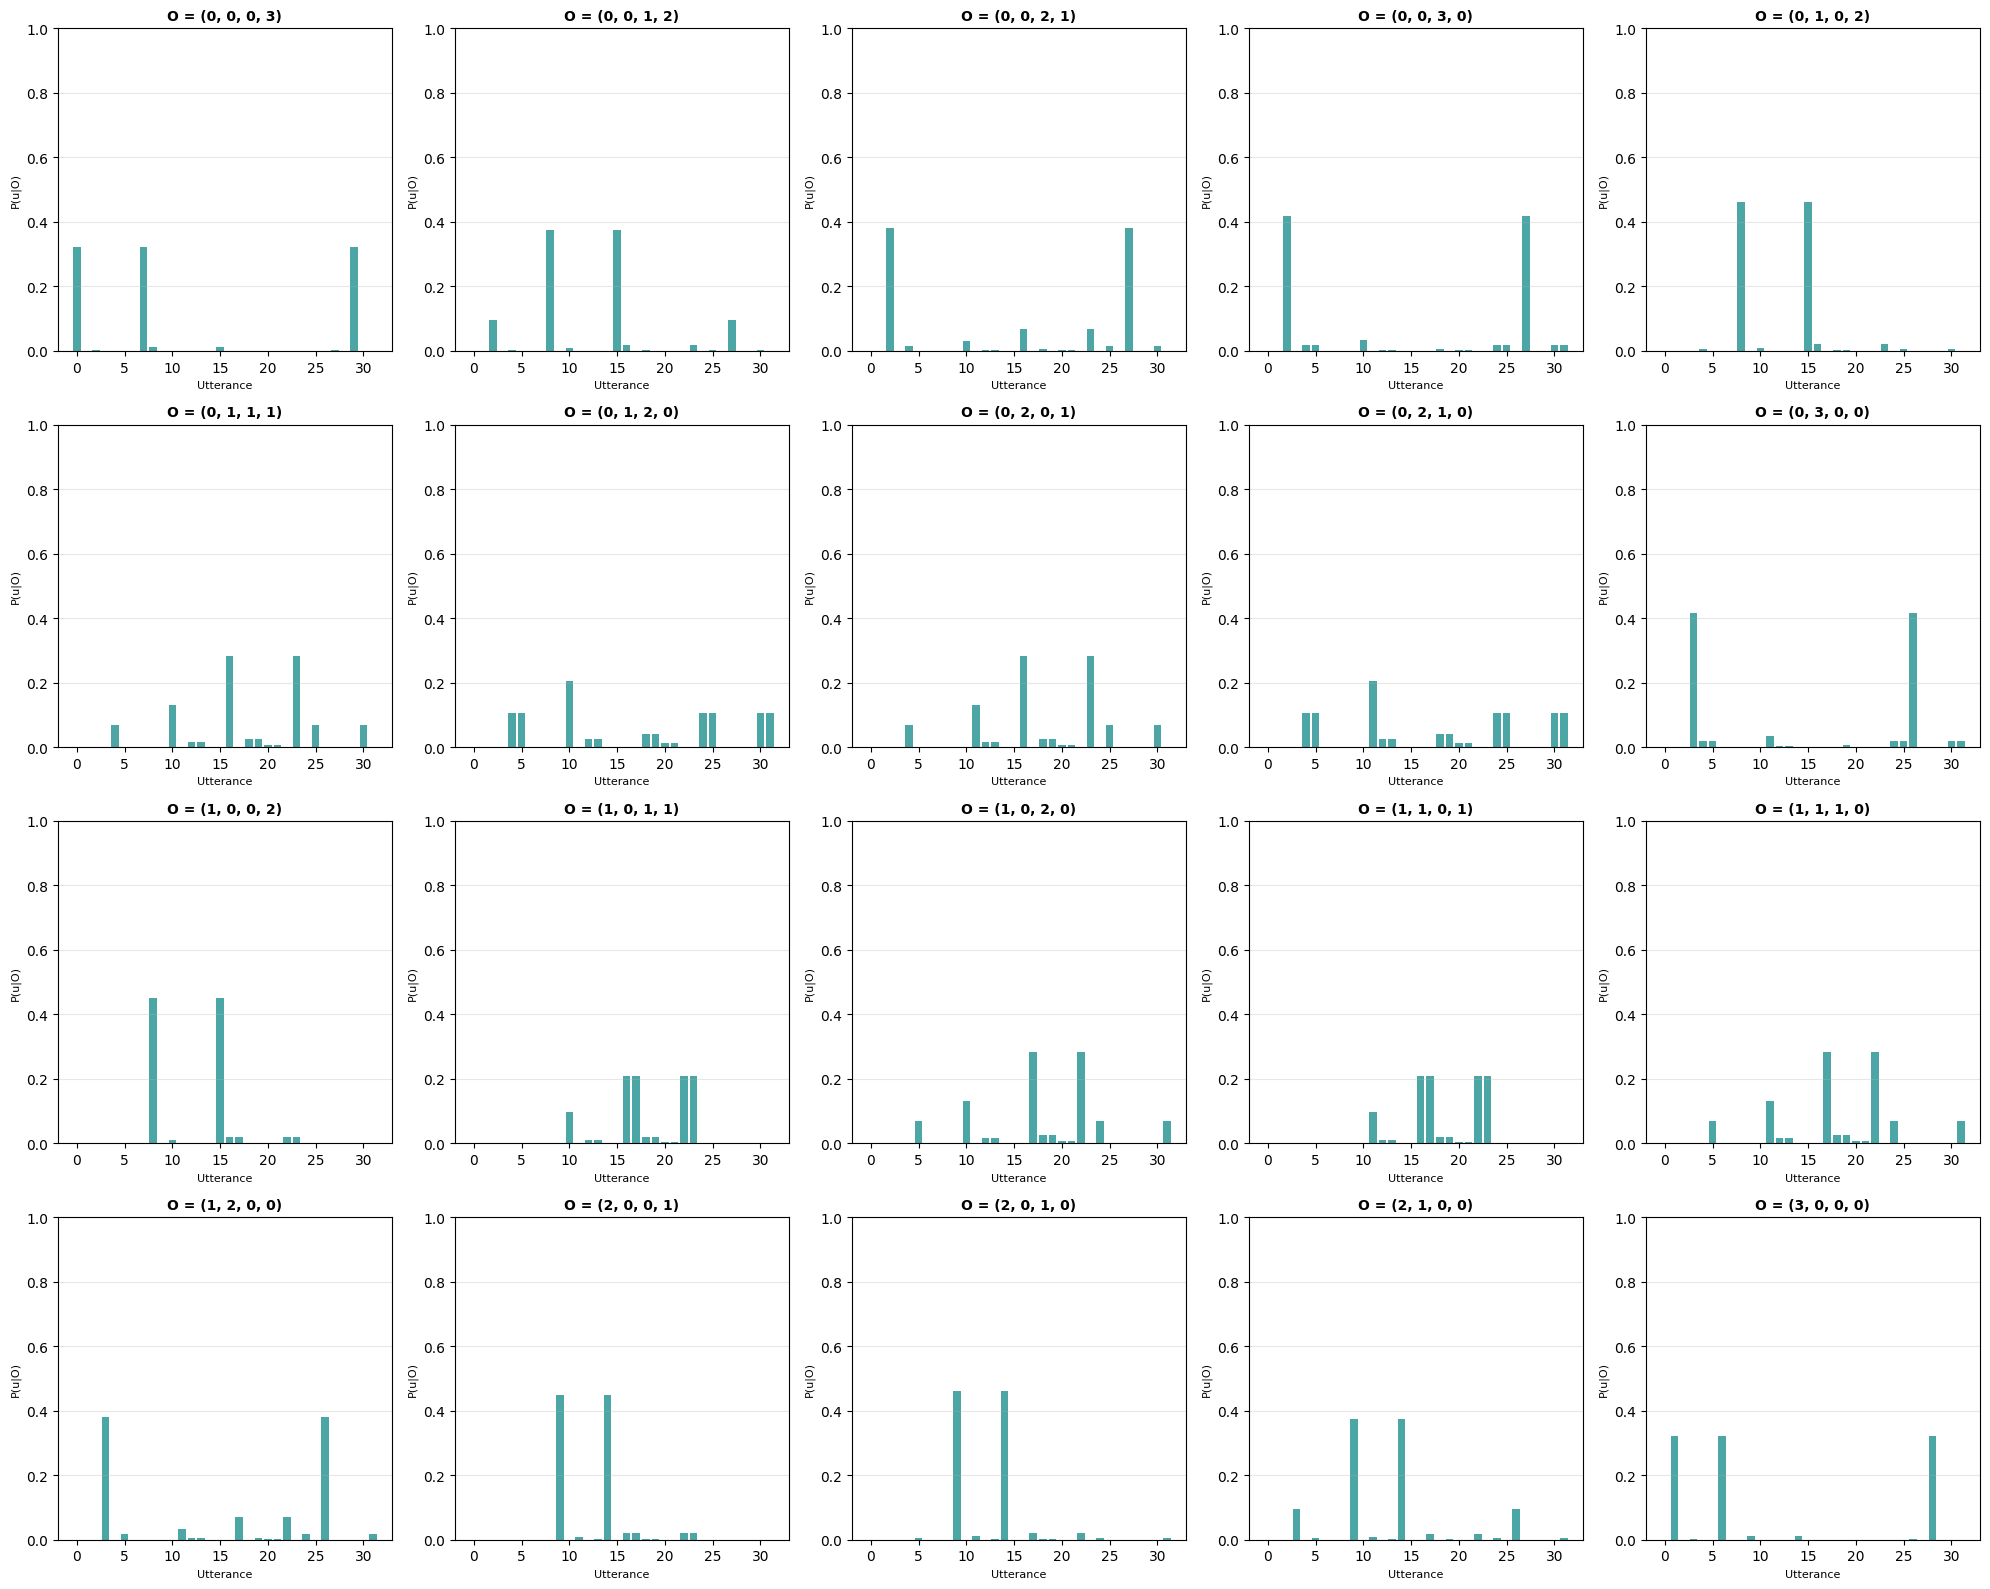

In [24]:
uniform_prior = jnp.ones(len(Theta)) / len(Theta)
alpha = 5.0

p_u_given_o_s1m_inf = jnp.array(S1_inf(uniform_prior, alpha))

# Select first 20 observations to visualize
observations = worldJAX.observations[:20]
n_utt = len(worldJAX.utterances)

create_bar_plots(p_u_given_o_s1m_inf, observations, n_utt)
#create_heat_map(p_u_given_o_s1m_inf, observations, utterances)

In [25]:
compare_two_matrix(p_u_given_o_s1inform, p_u_given_o_s1m_inf)

Total num of entries: 640
Entry with differences: 254,  39.69%
Statistics of differences:
  biggest difference: 2.980232e-07
  smallest non-zero difference: 1.346052e-10
  average differences (non-zero ones): 3.678412e-08

BIGGEST DIFFERENCE at: observation 12, utterance 17
  The difference number: -2.980232e-07
  base version: 0.282184
  memo version: 0.282185



##### Test B: comprehensive P(theta|u)

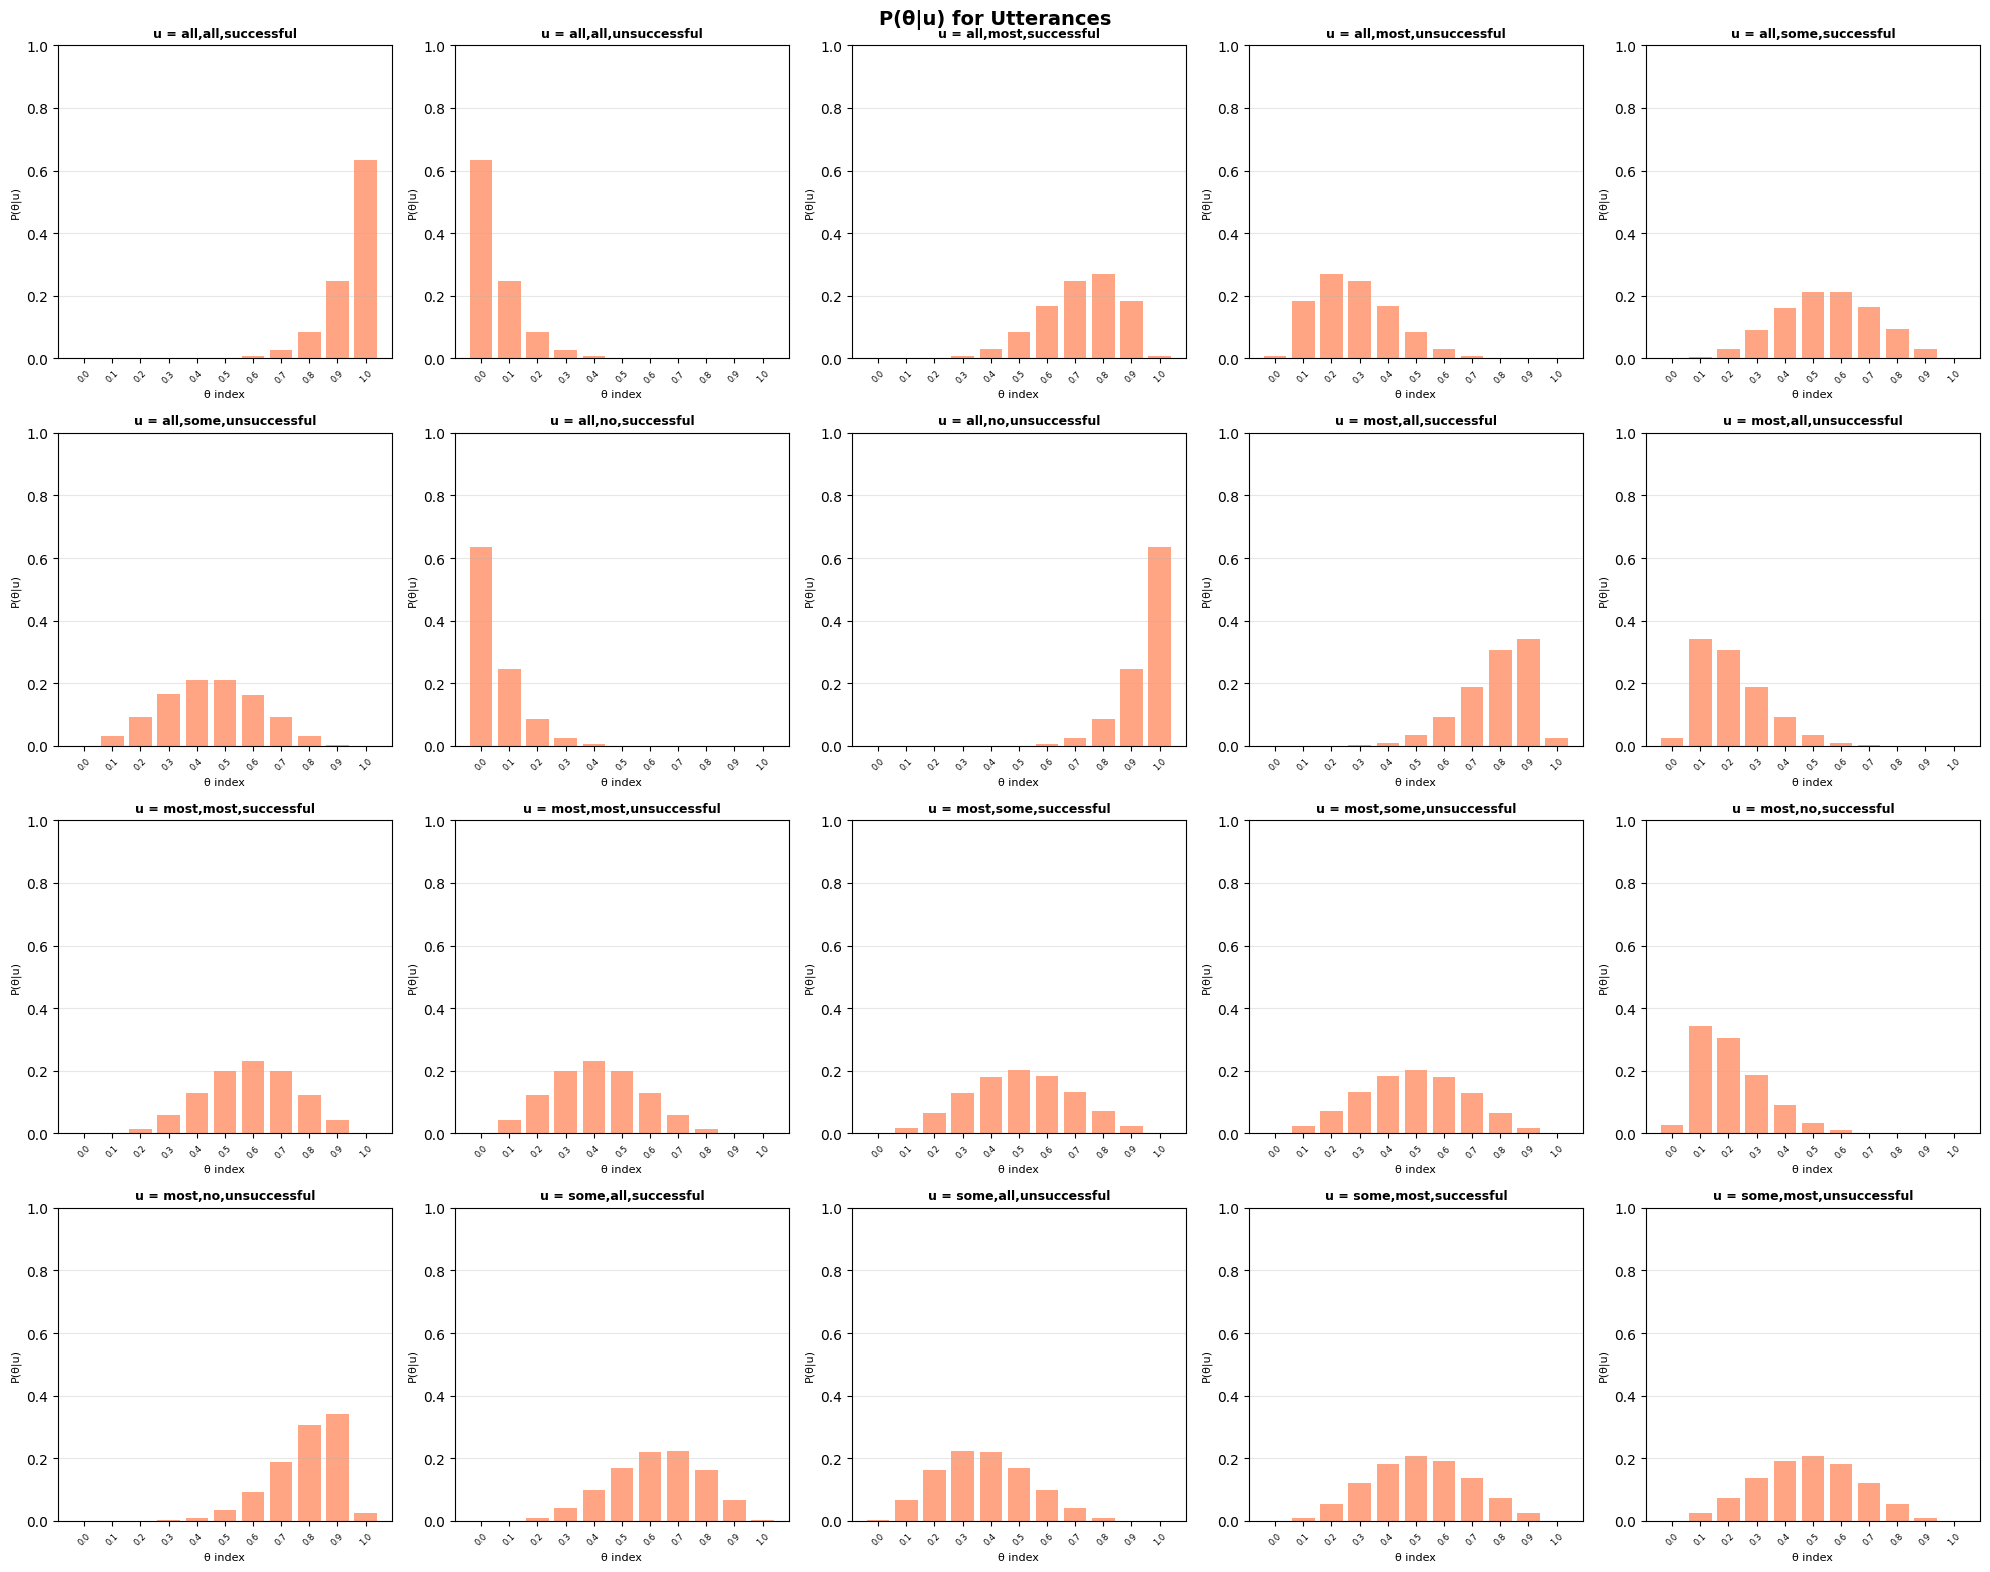

In [26]:
p_theta_given_u_l1m = L1_cred(uniform_prior, alpha) 

create_bar_l(p_theta_given_u_l1m, worldJAX.theta_values, worldJAX.utterances)

In [27]:
compare_two_matrix(p_theta_given_u_l1, p_theta_given_u_l1m)

Total num of entries: 352
Entry with differences: 277,  78.69%
Statistics of differences:
  biggest difference: 4.172325e-07
  smallest non-zero difference: 1.164153e-10
  average differences (non-zero ones): 4.495643e-08

BIGGEST DIFFERENCE at: observation 0, utterance 10
  The difference number: -4.172325e-07
  base version: 0.635201
  memo version: 0.635201



##### Test C: interaction simulation

### 【memo (Per+)

##### Test A: comprehensive P(u|O)

In [28]:
@memo
def L0_expected_theta[_u: U](prior: ..., theta_values: ...):
    """
    Compute E_L0[θ | u] = Σ_θ θ · P_L0(θ | u)
    """
    listener: knows(_u)
    listener: thinks[
        world: chooses(theta in Theta, wpp=array_index(prior, theta)),
        world: chooses(obs in Obs, wpp=get_obs_prob(obs, theta)),
        world: chooses(u in U, wpp=get_utt_prob(u, obs))
    ]
    listener: observes [world.u] is _u
    
    # Return expected value of theta (NOT probability of each theta!)
    return listener[E[array_index(theta_values, world.theta)]]

"""
Persuasive S1 speakers based on E_L0[θ | u]
"""

@memo
def S1_pers_up[_obs: Obs, _u: U](prior: ...,theta_value:..., alpha):
    """
    Persuade-up speaker: wants listener to infer HIGH theta
    Utility = E_L0[θ | u] = Σ_θ θ · P_L0(θ | u)
    """
    speaker: knows(_obs, _u)
    speaker: chooses(
        u in U,
        wpp=is_utt_true_for_obs(u, _obs) * exp(
            alpha * log(L0_expected_theta[u](prior, theta_value) + 1e-10)
        )
    )
    return Pr[speaker.u == _u]

@memo  
def S1_pers_down[_obs: Obs, _u: U](prior: ..., alpha, theta_values: ...):
    """
    Persuade-down speaker: wants listener to infer LOW theta
    Utility = 1 - E_L0[θ | u] = E_L0[1 - θ | u]
    """
    speaker: knows(_obs, _u)
    speaker: chooses(
        u in U,
        wpp=is_utt_true_for_obs(u, _obs) * exp(
            alpha * log(1.0 - L0_expected_theta[u](prior, theta_values) + 1e-10)
        )
    )
    return Pr[speaker.u == _u]

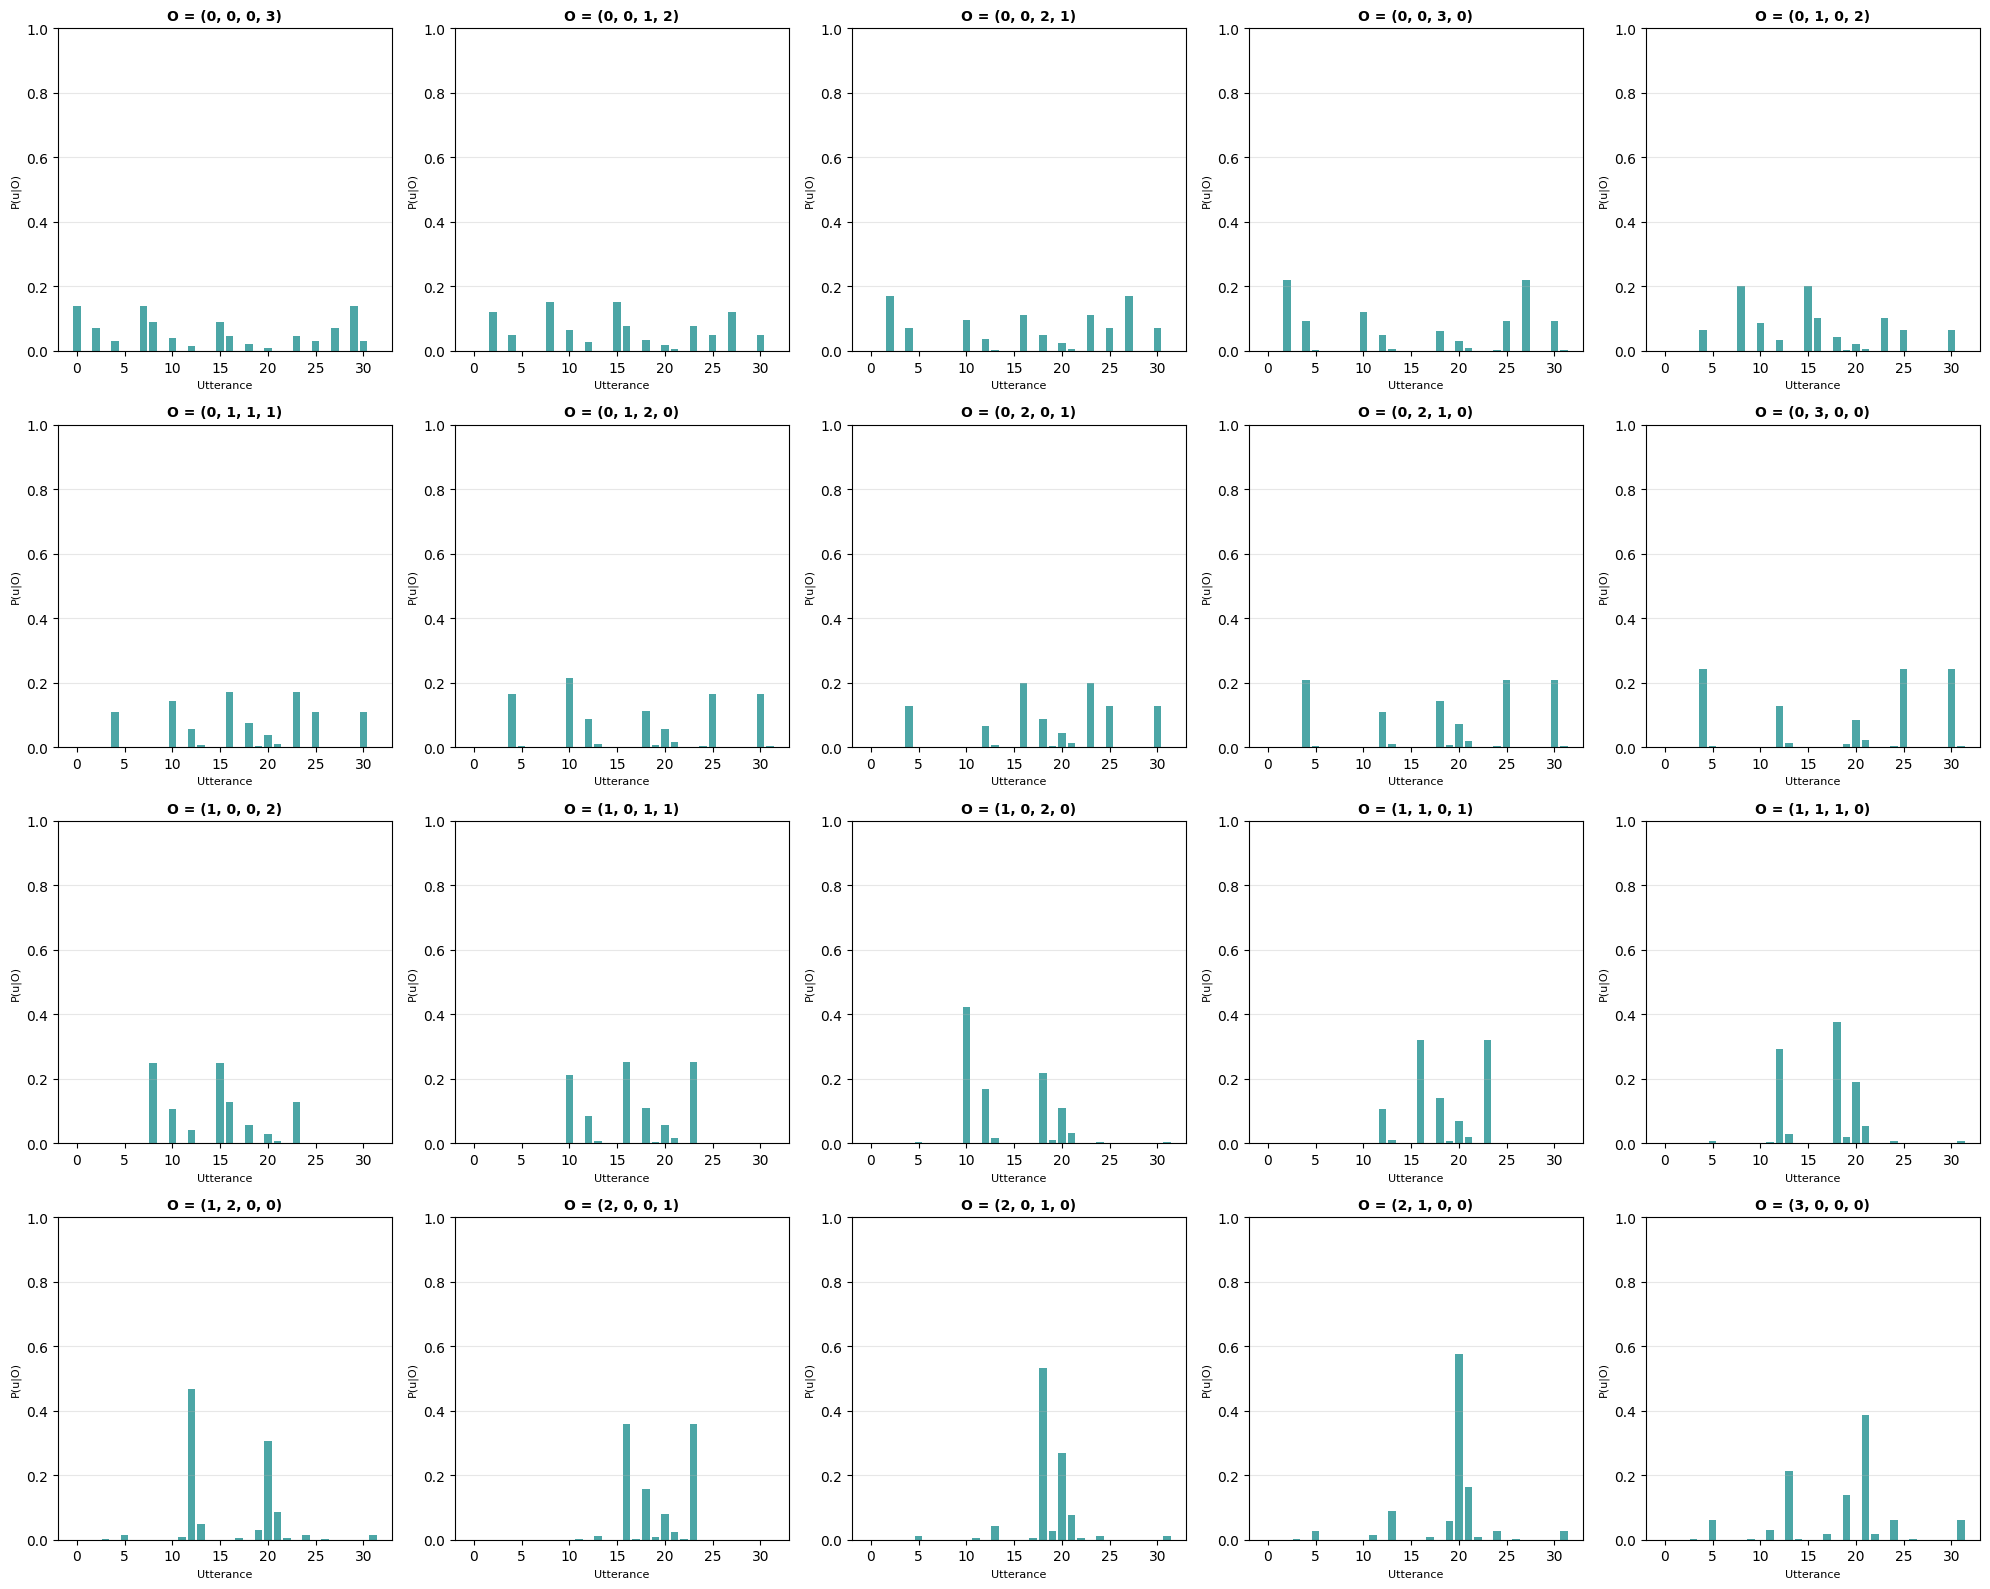

In [29]:
uniform_prior = jnp.ones(len(Theta)) / len(Theta)
alpha = 5.0

p_u_given_o_s1m_perU = jnp.array(S1_pers_up(uniform_prior, worldJAX.theta_values, alpha))
create_bar_plots(p_u_given_o_s1m_perU, observations, n_utt)

In [30]:
compare_two_matrix(p_u_given_o_s1pu, p_u_given_o_s1m_perU)

Total num of entries: 640
Entry with differences: 257,  40.16%
Statistics of differences:
  biggest difference: 5.364418e-07
  smallest non-zero difference: 1.600711e-10
  average differences (non-zero ones): 5.947192e-08

BIGGEST DIFFERENCE at: observation 18, utterance 20
  The difference number: 5.364418e-07
  base version: 0.575287
  memo version: 0.575286



##### Test B: comprehensive P(theta|u)

In [31]:
Psi = jnp.arange(3) 
Psi_dist = jnp.array([1/3, 1/3, 1/3])  # Example psi values
uniform_prior = jnp.ones(len(Theta)) / len(Theta)
alpha_values = jnp.array([5.0])  # Actual alpha values
Alpha = jnp.arange(len(alpha_values))  # Indices: 0, 1, 2

@memo
def L1_vig[_u: U, _theta: Theta, _alpha: Alpha, _psi: Psi](prior: ..., alpha_dist:..., alpha_values:..., psi_dist: ..., theta_values: ...):
    listener: knows(_u, _theta, _alpha, _psi)
    listener: thinks[
        world: chooses(theta in Theta, wpp=array_index(prior, theta)),
        world: chooses(obs in Obs, wpp=get_obs_prob(obs, theta)),
        world: given(stype in Psi, wpp=array_index(psi_dist, stype)),
        speaker: knows(world.obs, world.stype),
        speaker: chooses(alp in Alpha, wpp=array_index(alpha_dist, alp)),
        speaker: chooses(
            u in U,
            wpp=is_utt_true_for_obs(u, world.obs) * exp(
                array_index(alpha_values, alp) * log(
                    (world.stype == 0) * L0_obs[u, world.obs](prior) +
                    (world.stype == 1) * L0_expected_theta[u](prior, theta_values) +
                    (world.stype == 2) * (1.0 - L0_expected_theta[u](prior, theta_values))
                    + 1e-10
                )
            )
        )
    ]
    listener: observes [speaker.u] is _u
    return listener[Pr[world.theta == _theta, speaker.alp == _alpha, world.stype == _psi]]

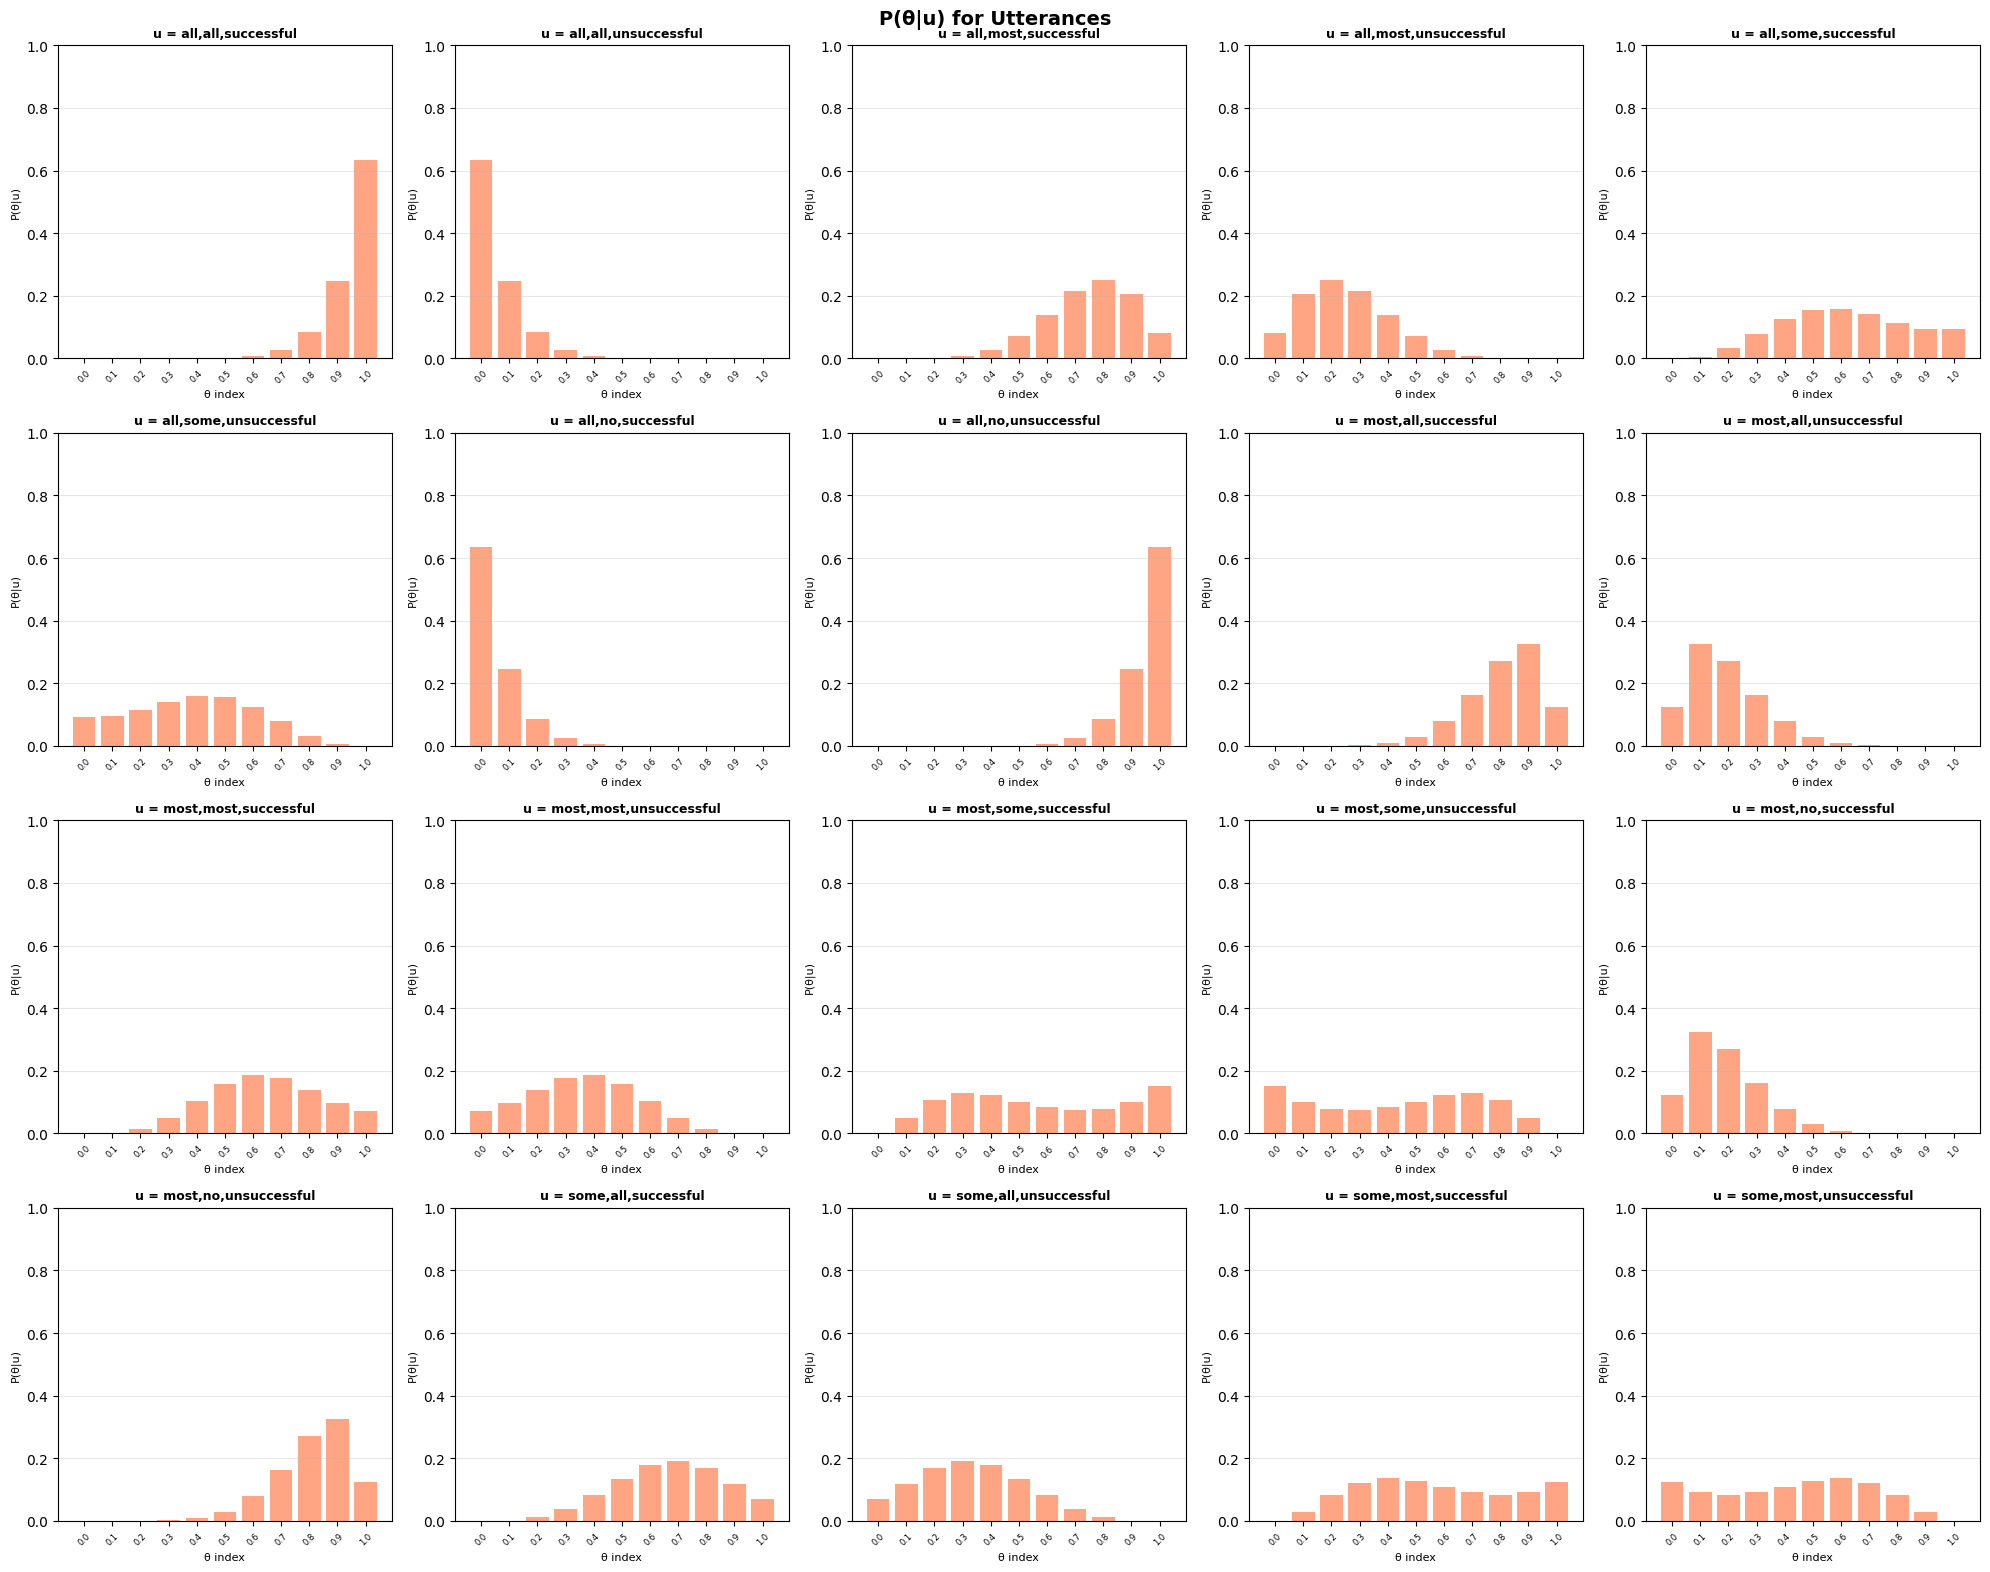

In [ ]:
def marginalize_L1_vig(L1_vig_memo):
    p_theta_given_u = jnp.sum(L1_vig_memo, axis=(-1, -2))
    return p_theta_given_u
L1_vig_memo = L1_vig(uniform_prior, jnp.array([1.0]), alpha_values, Psi_dist, worldJAX.theta_values)
L1_clean = marginalize_L1_vig(L1_vig_memo)
create_bar_l(L1_clean, worldJAX.theta_values, worldJAX.utterances)

In [33]:
compare_two_matrix(p_theta_given_u_l1_preU, L1_clean)

Total num of entries: 352
Entry with differences: 280,  79.55%
Statistics of differences:
  biggest difference: 4.768372e-07
  smallest non-zero difference: 1.746230e-10
  average differences (non-zero ones): 6.110916e-08

BIGGEST DIFFERENCE at: observation 0, utterance 10
  The difference number: -4.768372e-07
  base version: 0.635201
  memo version: 0.635201



## 3. S2 & L2

### 【base (Info)

In [34]:
world_s2l2 = World(
    n=3,
    m=3,
    theta_values=np.linspace(0, 1, 11)
)

# Create S2 speaker (Cooperative & Informative)
speaker_s2 = create_speaker(
    world=world_s2l2,
    level=2,
    omega="coop",
    psi="inf",
    update_internal=True,
    alpha=5.0,
    beta=1.0
)

# Create L2 listener
listener_l2 = create_listener(
    world=world_s2l2,
    level=2,
    omega="coop",
    update_internal=True,
    alpha=5.0
)

#### Test A: comprehensive P(u|O)

S2 P(u|O) shape: (20, 32)
Row sums (first 5): [1. 1. 1. 1. 1.]


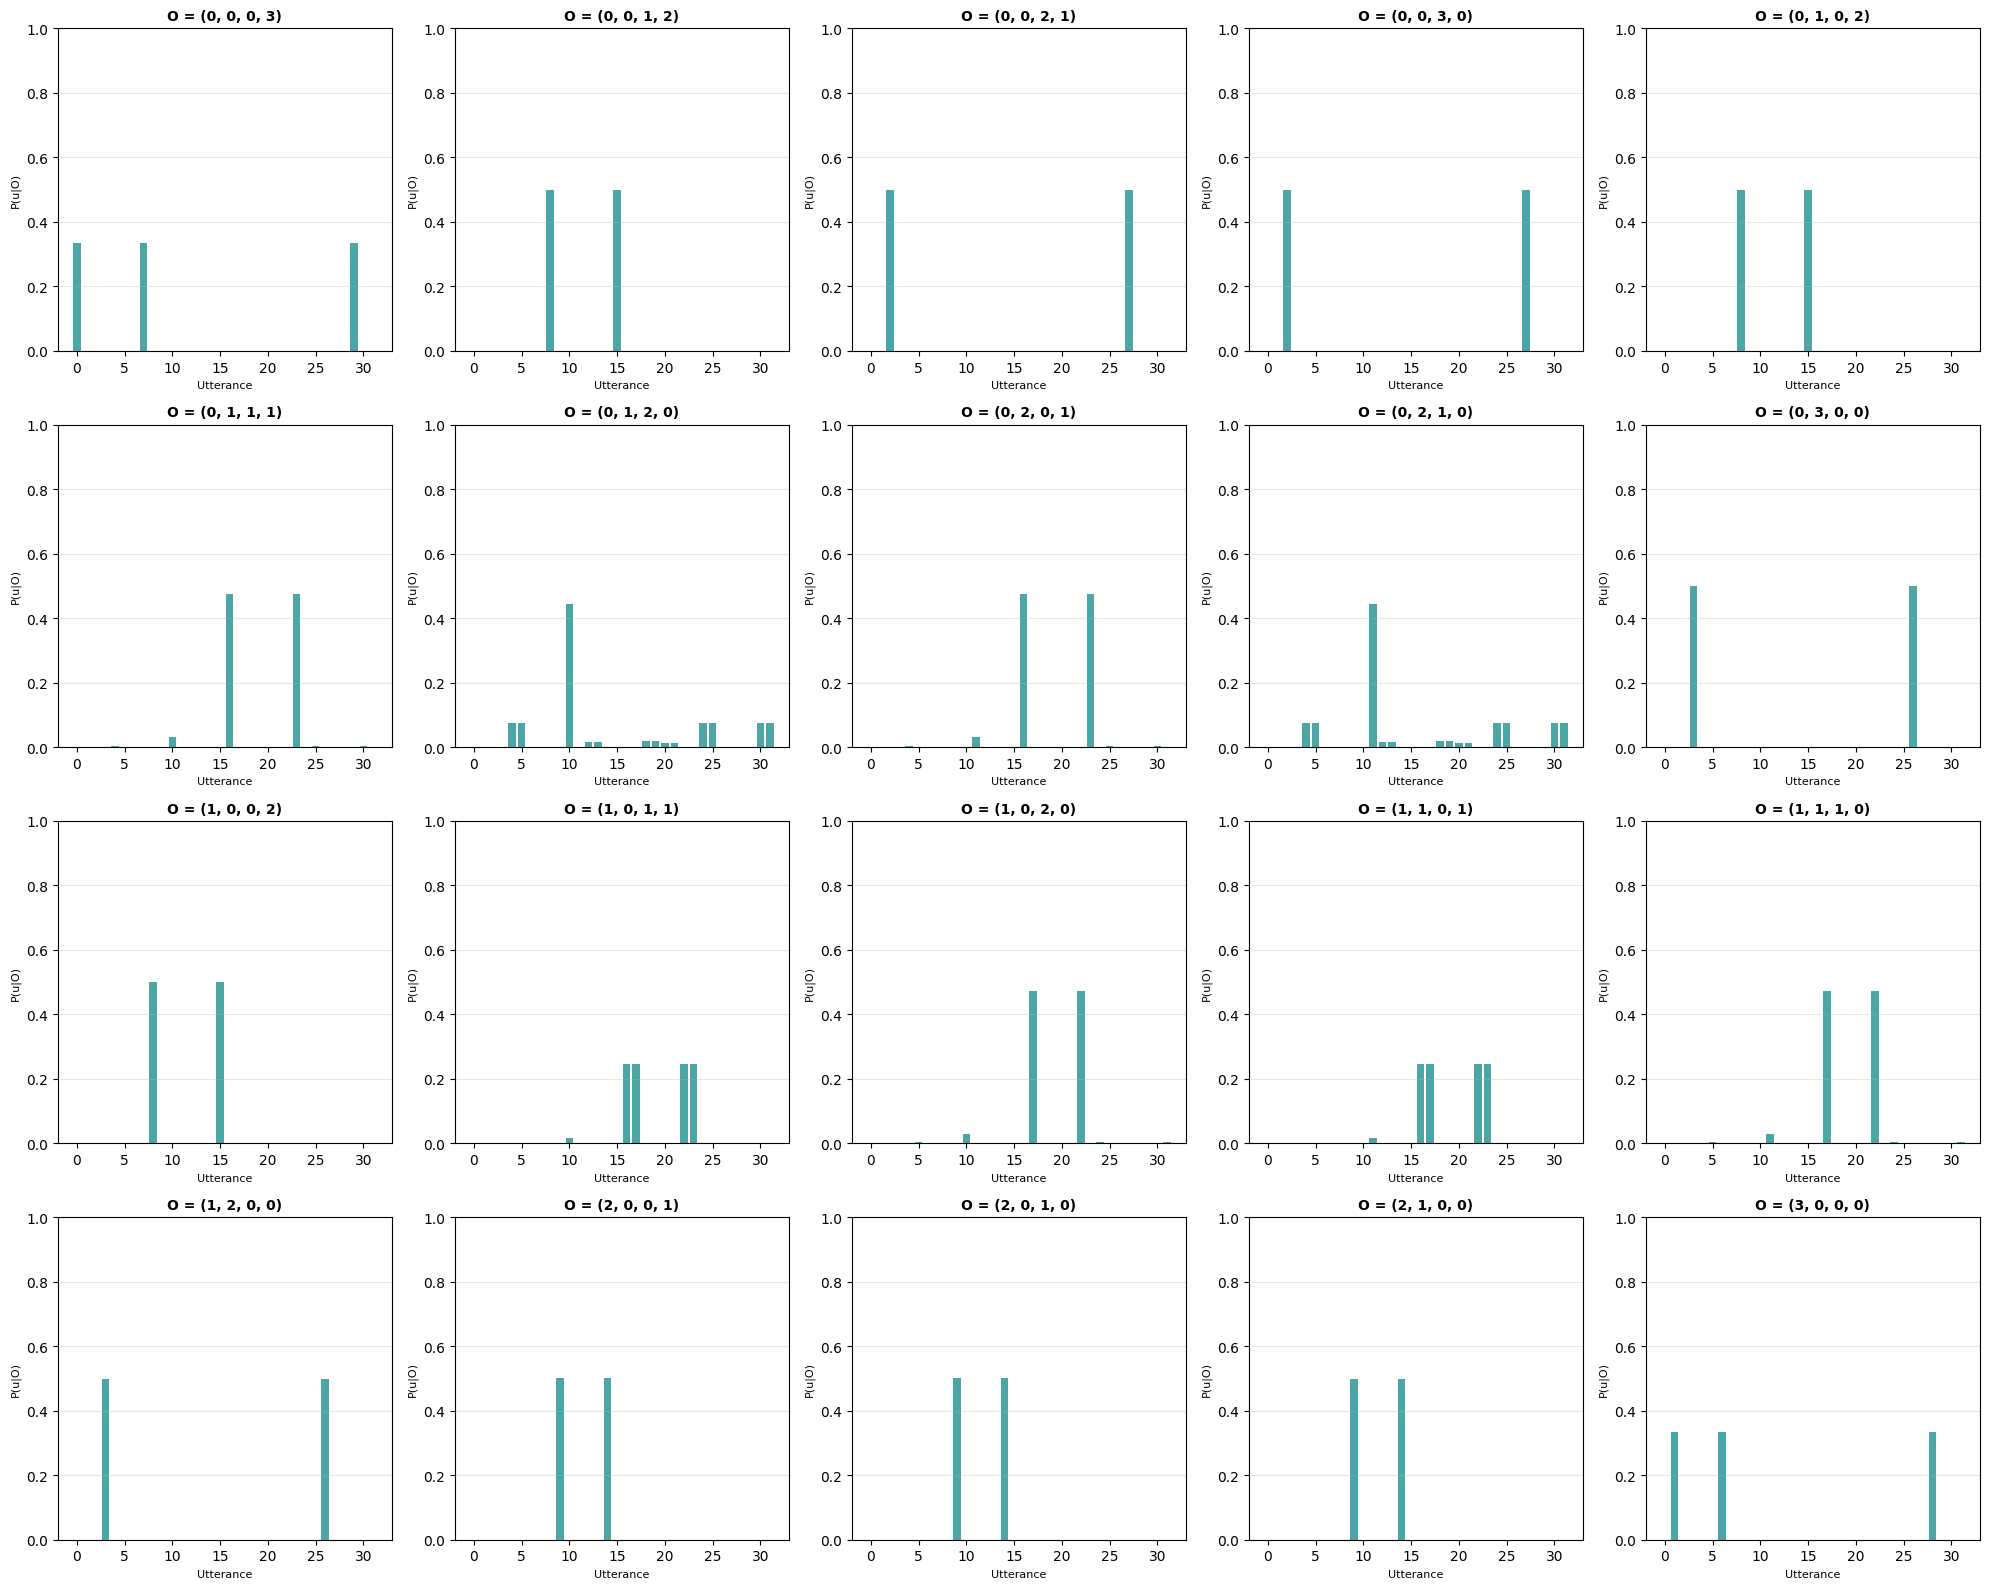

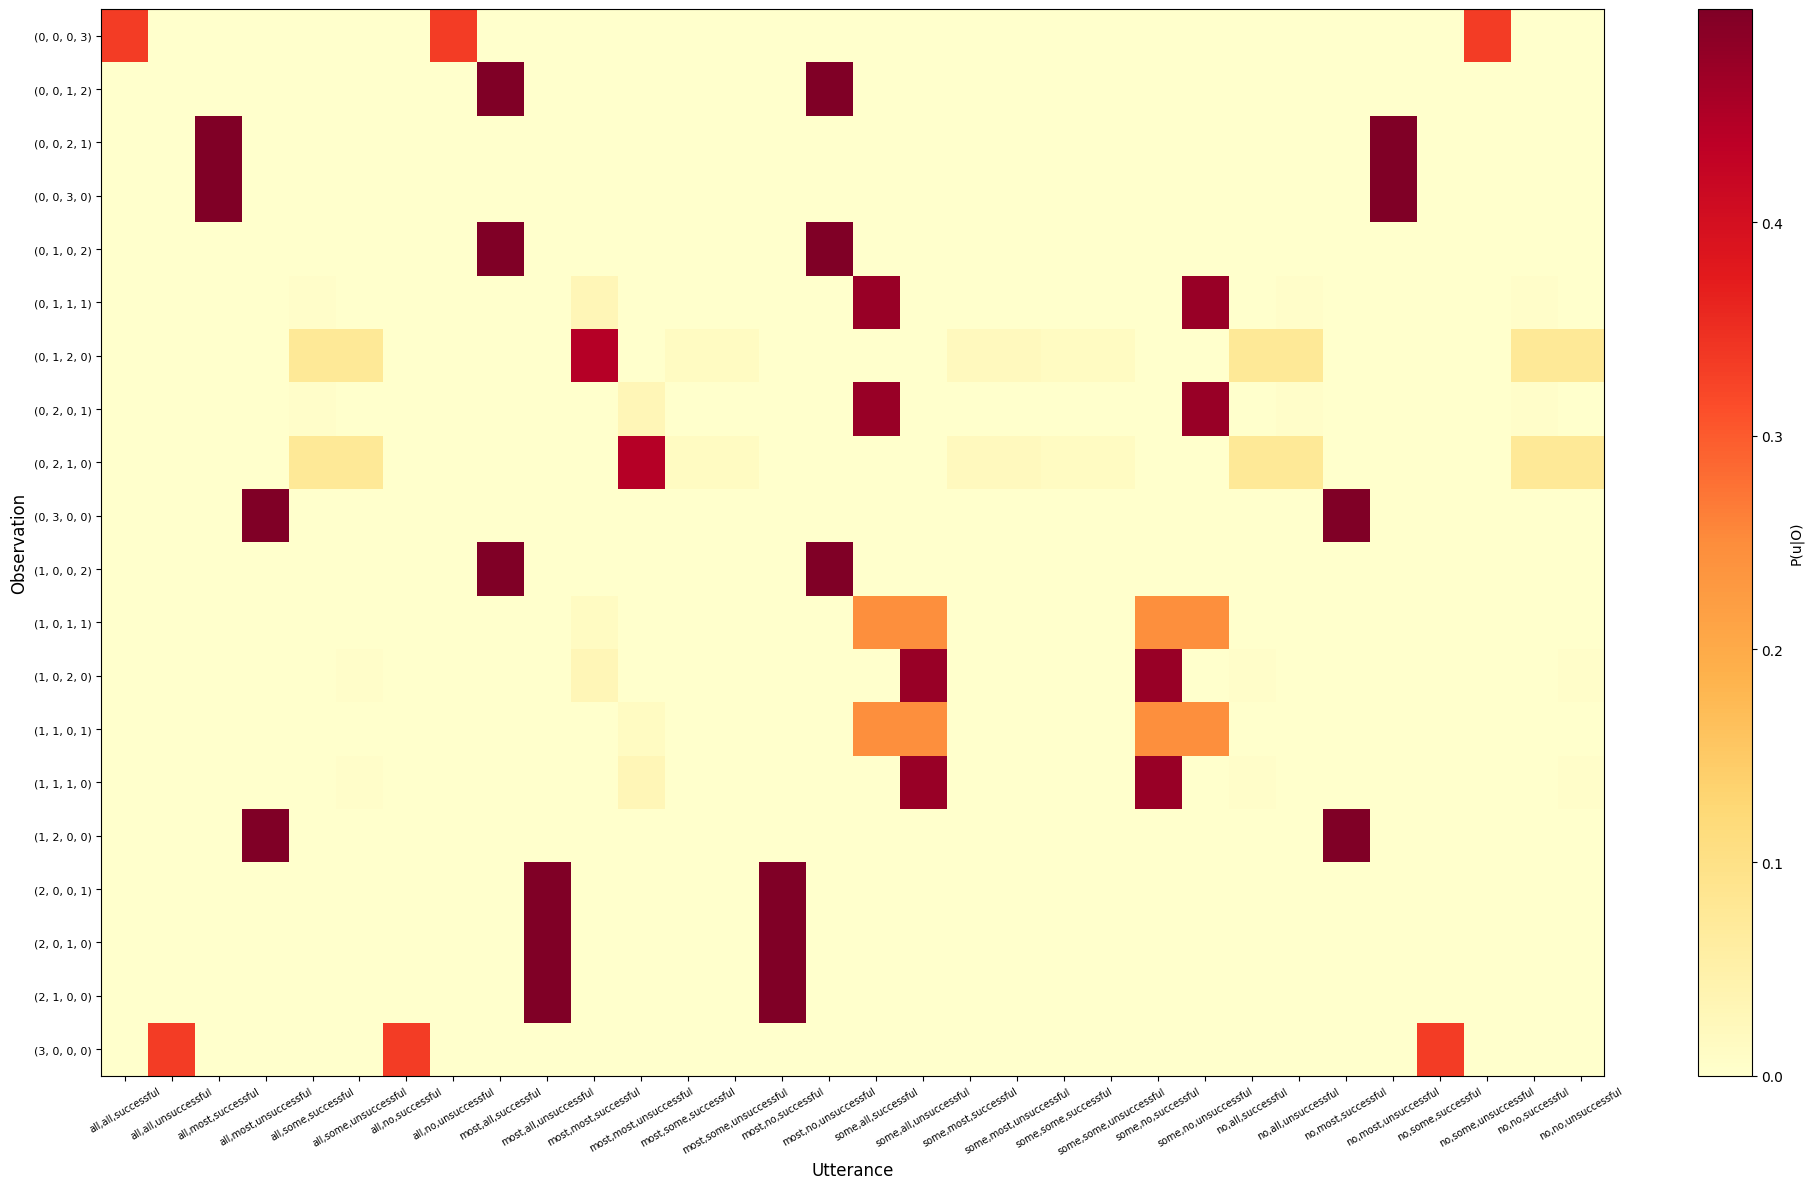

In [35]:
# Get S2's utterance distribution
p_u_given_o_s2 = np.exp(speaker_s2.utterance_log_prob_obs.T.values)

print(f"S2 P(u|O) shape: {p_u_given_o_s2.shape}")
print(f"Row sums (first 5): {np.sum(p_u_given_o_s2, axis=1)[:5]}")

# Visualize first 20 observations
observations = world_s2l2.observations[:20]
utterances = world_s2l2.utterances
n_utt = len(world_s2l2.utterances)

create_bar_plots(p_u_given_o_s2, observations, n_utt)
create_heat_map(p_u_given_o_s2, observations, utterances)


#### Test B: comprehensive P(theta|u)

L2 P(theta|u) shape: (32, 11)
Row sums (first 5): [1. 1. 1. 1. 1.]


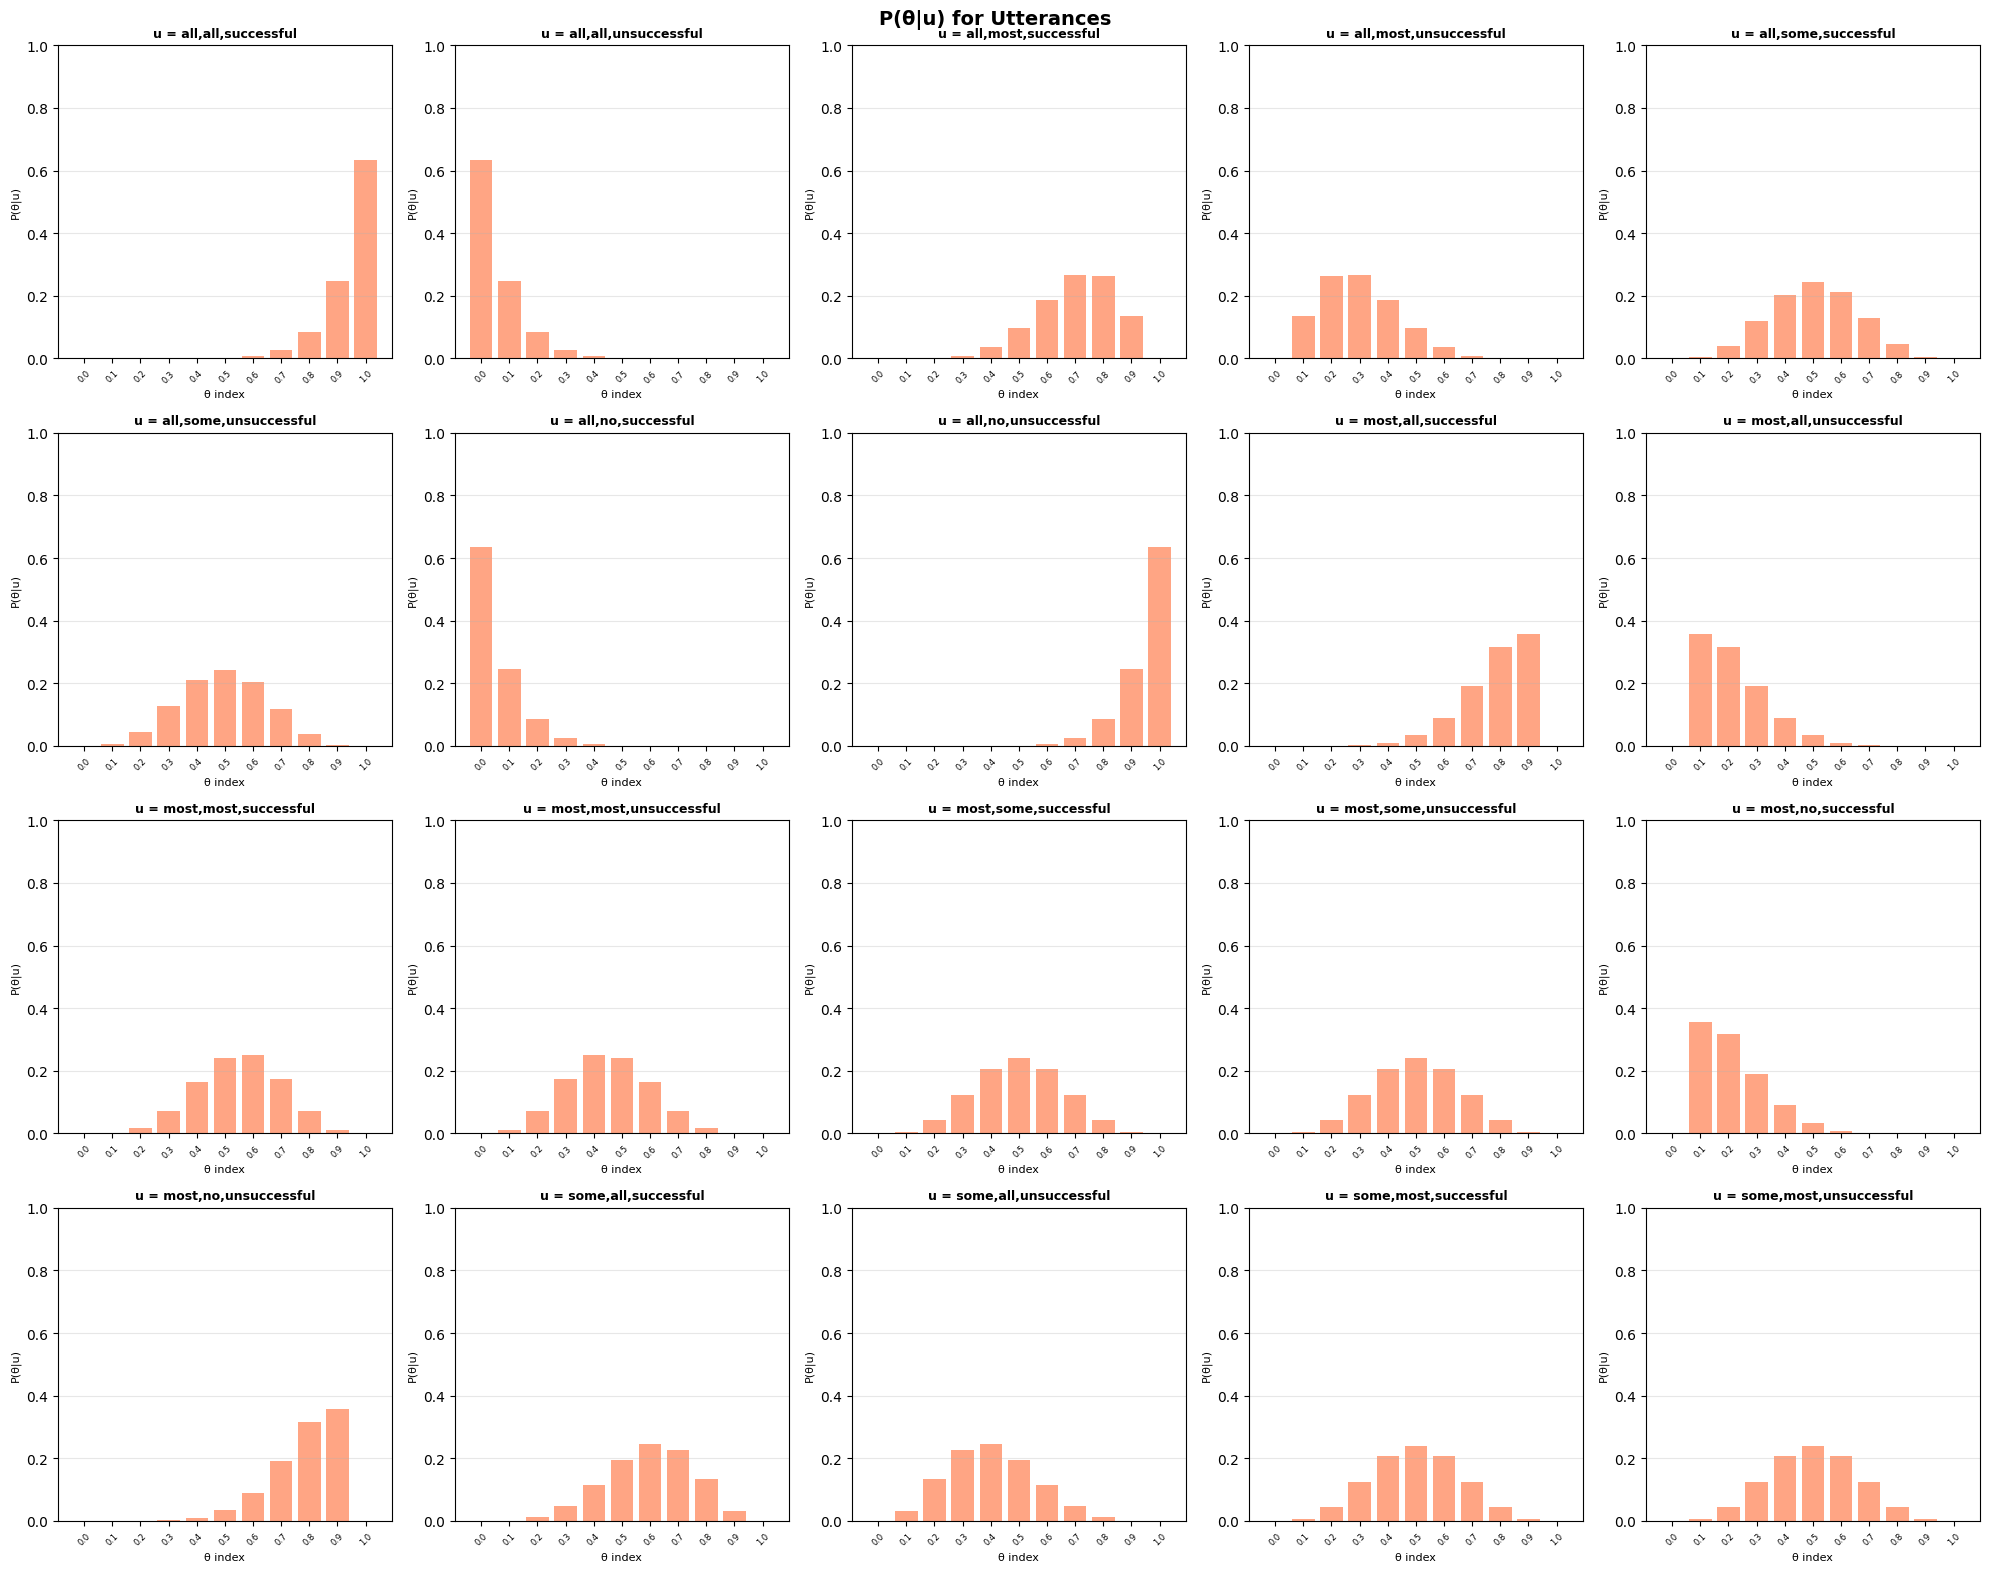

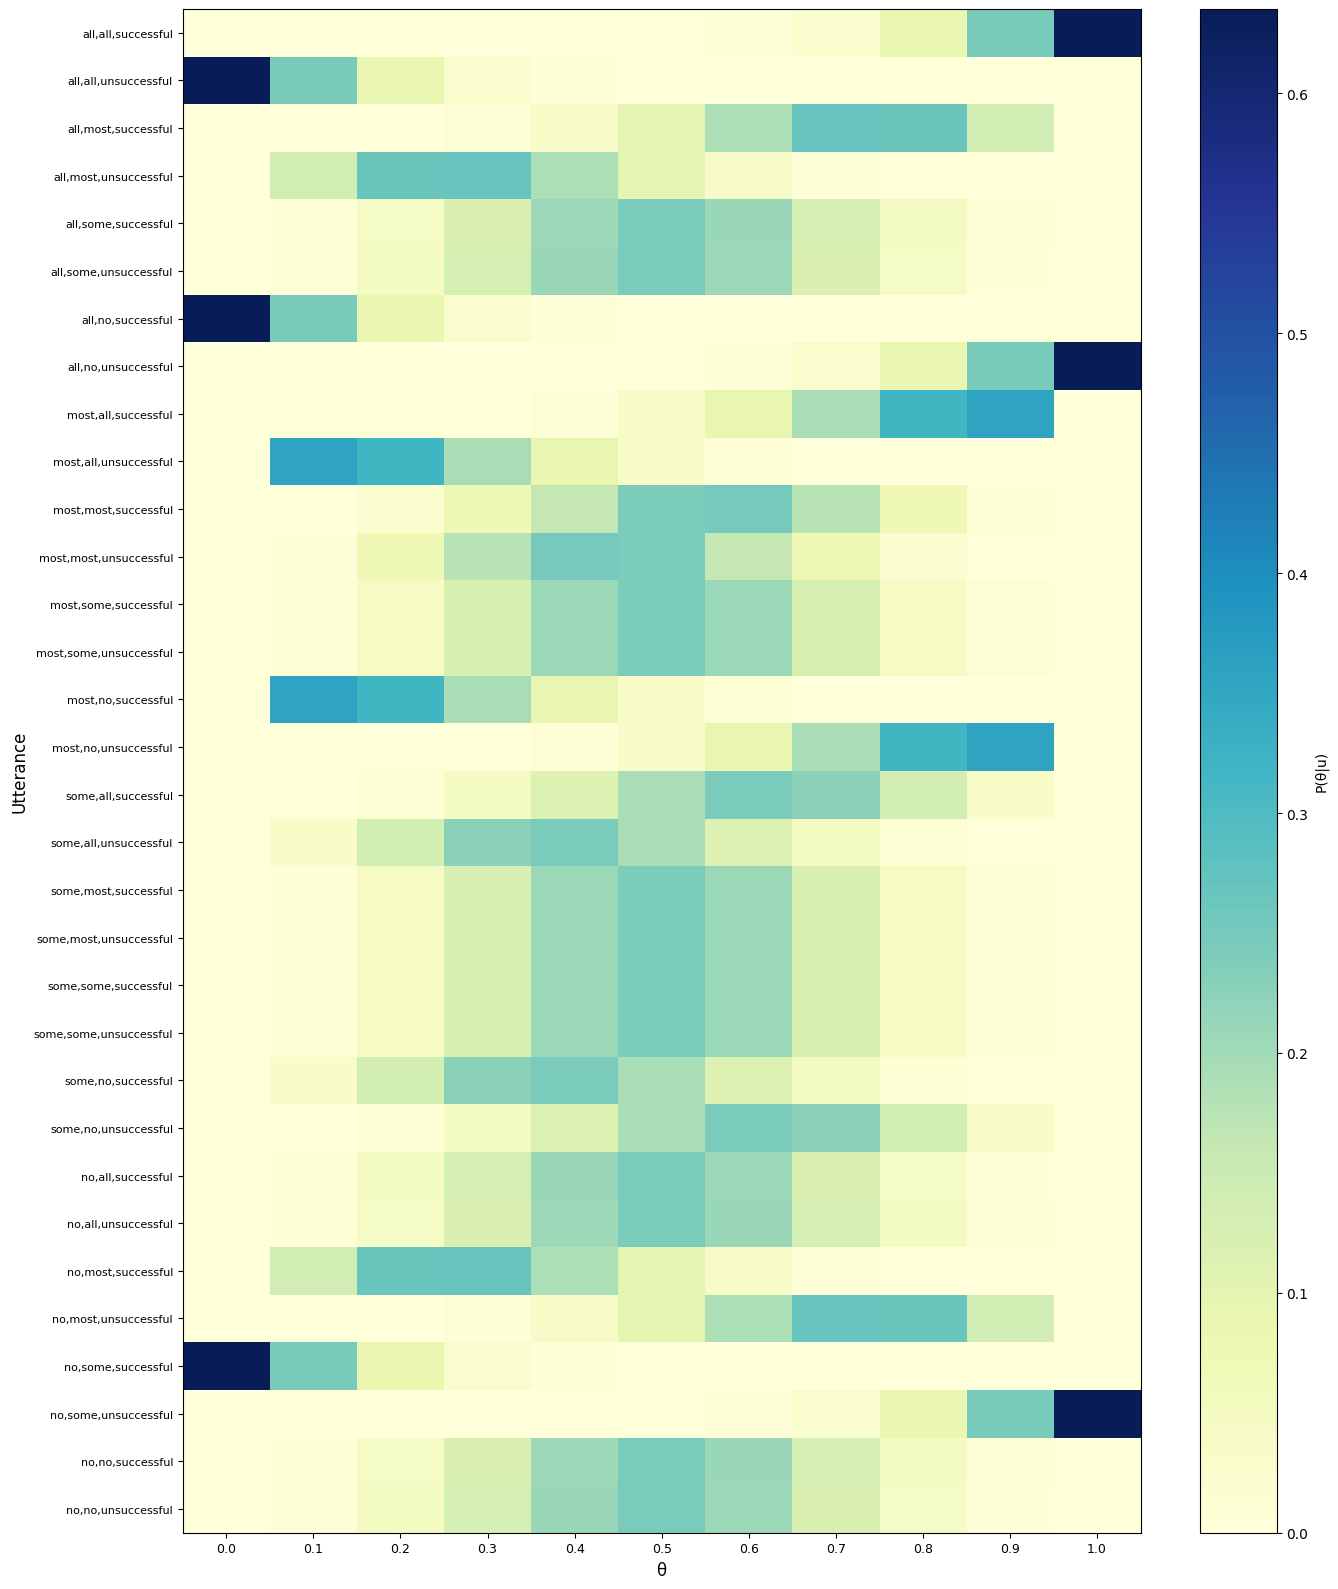

In [36]:
joint_log_post = listener_l2.theta_psi_alpha_log_post_utterance.values

from scipy.special import logsumexp
theta_log_post_u = logsumexp(joint_log_post, axis=(2, 3))  # Shape: (n_utterances, n_theta)

# Normalize to get proper probabilities
theta_log_post_u_normalized = theta_log_post_u - logsumexp(theta_log_post_u, axis=1, keepdims=True)
p_theta_given_u_l2 = np.exp(theta_log_post_u_normalized)

print(f"L2 P(theta|u) shape: {p_theta_given_u_l2.shape}")
print(f"Row sums (first 5): {np.sum(p_theta_given_u_l2, axis=1)[:5]}")

create_bar_l(p_theta_given_u_l2, theta_values, utterances)
create_heat_l(p_theta_given_u_l2, theta_values, utterances)

#### Test C: interaction simulation

=== Round 1 ===
S2 E[theta]: 0.7264, error: 0.0264; L2 E[theta]: 0.6995, error: 0.0005
=== Round 2 ===
S2 E[theta]: 0.6500, error: 0.0500; L2 E[theta]: 0.6526, error: 0.0474
=== Round 3 ===
S2 E[theta]: 0.7239, error: 0.0239; L2 E[theta]: 0.7211, error: 0.0211
=== Round 4 ===
S2 E[theta]: 0.7368, error: 0.0368; L2 E[theta]: 0.7357, error: 0.0357
=== Round 5 ===
S2 E[theta]: 0.7856, error: 0.0856; L2 E[theta]: 0.7890, error: 0.0890
=== Round 6 ===
S2 E[theta]: 0.7511, error: 0.0511; L2 E[theta]: 0.7432, error: 0.0432
=== Round 7 ===
S2 E[theta]: 0.7707, error: 0.0707; L2 E[theta]: 0.7635, error: 0.0635
=== Round 8 ===
S2 E[theta]: 0.7939, error: 0.0939; L2 E[theta]: 0.7927, error: 0.0927
=== Round 9 ===
S2 E[theta]: 0.7851, error: 0.0851; L2 E[theta]: 0.7851, error: 0.0851
=== Round 10 ===
S2 E[theta]: 0.7529, error: 0.0529; L2 E[theta]: 0.7588, error: 0.0588


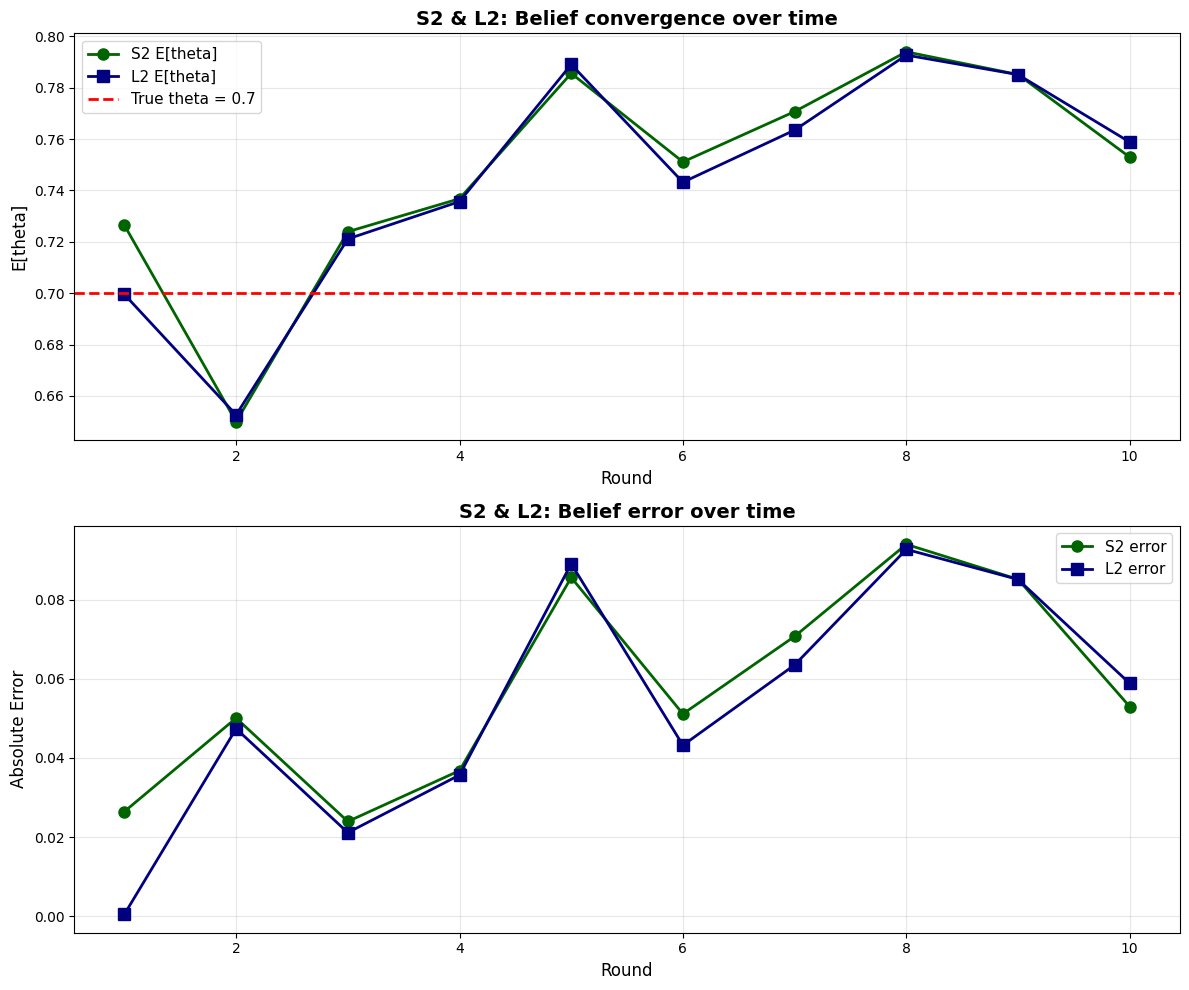


Summary Statistics
Final S2 E[theta]: 0.7529 (error: 0.0529)
Final L2 E[theta]: 0.7588 (error: 0.0588)
S2 error reduction: 0.0264 -> 0.0529
L2 error reduction: 0.0005 -> 0.0588


In [37]:
speaker_s2_sim = create_speaker(
    world=world_s2l2,
    level=2,
    omega="coop",
    psi="inf",
    update_internal=True,
    alpha=5.0,
    beta=1.0
)

listener_l2_sim = create_listener(
    world=world_s2l2,
    level=2,
    omega="coop",
    update_internal=True,
    alpha=5.0
)
observations = world_s2l2.observations
utterances = world_s2l2.utterances
n_obs = len(observations)
n_utt = len(utterances)

# Set true theta
true_theta = 0.7
np.random.seed(42)

# Track beliefs over time
n_rounds = 10
speaker_expectations = []
listener_expectations = []
speaker_errors = []
listener_errors = []

for round_idx in range(n_rounds):
    print(f"=== Round {round_idx + 1} ===")
    
    # Generate observation from true theta
    theta_idx = np.argmin(np.abs(world_s2l2.theta_values - true_theta))
    obs_probs = np.exp(world_s2l2.obs_log_likelihood_theta.iloc[:, theta_idx].values)
    obs_idx = np.random.choice(len(world_s2l2.possible_outcomes), p=obs_probs)
    obs = world_s2l2.possible_outcomes[obs_idx]
    #print(f"Observation: {obs}")
    
    # S2 produces utterance (correct method name: update_and_speak)
    utterance = speaker_s2_sim.update_and_speak(obs)
    #print(f"S2 says: '{utterance}'")
    
    # L2 listens and updates
    listener_l2_sim.listen_and_update(utterance)
    
    # Get current beliefs
    speaker_belief = speaker_s2_sim.current_belief_theta
    listener_belief = listener_l2_sim.current_belief_theta
    
    # Calculate expectations
    speaker_exp = speaker_belief @ world_s2l2.theta_values
    listener_exp = listener_belief @ world_s2l2.theta_values
    
    speaker_expectations.append(speaker_exp)
    listener_expectations.append(listener_exp)
    
    # Calculate errors
    speaker_err = np.abs(speaker_exp - true_theta)
    listener_err = np.abs(listener_exp - true_theta)
    
    speaker_errors.append(speaker_err)
    listener_errors.append(listener_err)
    
    print(f"S2 E[theta]: {speaker_exp:.4f}, error: {speaker_err:.4f}; L2 E[theta]: {listener_exp:.4f}, error: {listener_err:.4f}")

# Visualize learning curves
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Belief expectations over time
ax1 = axes[0]
rounds = range(1, n_rounds + 1)
ax1.plot(rounds, speaker_expectations, 'o-', label='S2 E[theta]', color='darkgreen', linewidth=2, markersize=8)
ax1.plot(rounds, listener_expectations, 's-', label='L2 E[theta]', color='navy', linewidth=2, markersize=8)
ax1.axhline(y=true_theta, color='red', linestyle='--', linewidth=2, label=f'True theta = {true_theta}')
ax1.set_xlabel('Round', fontsize=12)
ax1.set_ylabel('E[theta]', fontsize=12)
ax1.set_title('S2 & L2: Belief convergence over time', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Errors over time
ax2 = axes[1]
ax2.plot(rounds, speaker_errors, 'o-', label='S2 error', color='darkgreen', linewidth=2, markersize=8)
ax2.plot(rounds, listener_errors, 's-', label='L2 error', color='navy', linewidth=2, markersize=8)
ax2.set_xlabel('Round', fontsize=12)
ax2.set_ylabel('Absolute Error', fontsize=12)
ax2.set_title('S2 & L2: Belief error over time', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("Summary Statistics")
print(f"Final S2 E[theta]: {speaker_expectations[-1]:.4f} (error: {speaker_errors[-1]:.4f})")
print(f"Final L2 E[theta]: {listener_expectations[-1]:.4f} (error: {listener_errors[-1]:.4f})")
print(f"S2 error reduction: {speaker_errors[0]:.4f} -> {speaker_errors[-1]:.4f}")
print(f"L2 error reduction: {listener_errors[0]:.4f} -> {listener_errors[-1]:.4f}")


### 【memo (info)

In [38]:
@memo
def L1_cred_obs[_u: U, _obs: Obs](prior: ..., alpha):
    listener: knows(_u, _obs)
    listener: thinks[
        world: chooses(theta in Theta, wpp=array_index(prior, theta)),
        world: chooses(obs in Obs, wpp=get_obs_prob(obs, theta)),
        speaker: knows(world.obs),
        speaker: chooses(
            u in U,
            wpp=is_utt_true_for_obs(u, world.obs) * exp(alpha * log(L0_obs[u, world.obs](prior) + 1e-10))
        )
    ]
    listener: observes[speaker.u] is _u
    return listener[Pr[world.obs == _obs]]

@memo
def S2_inf[_obs: Obs, _u: U](prior: ..., alpha):
    speaker: knows(_obs, _u)
    speaker: chooses(
        u in U, 
        wpp=is_utt_true_for_obs(u, _obs) * exp(alpha * log(L1_cred_obs[u, _obs](prior, alpha) + 1e-10))
    )
    return Pr[speaker.u == _u]

#### Test A: comprehensive P(u|O)

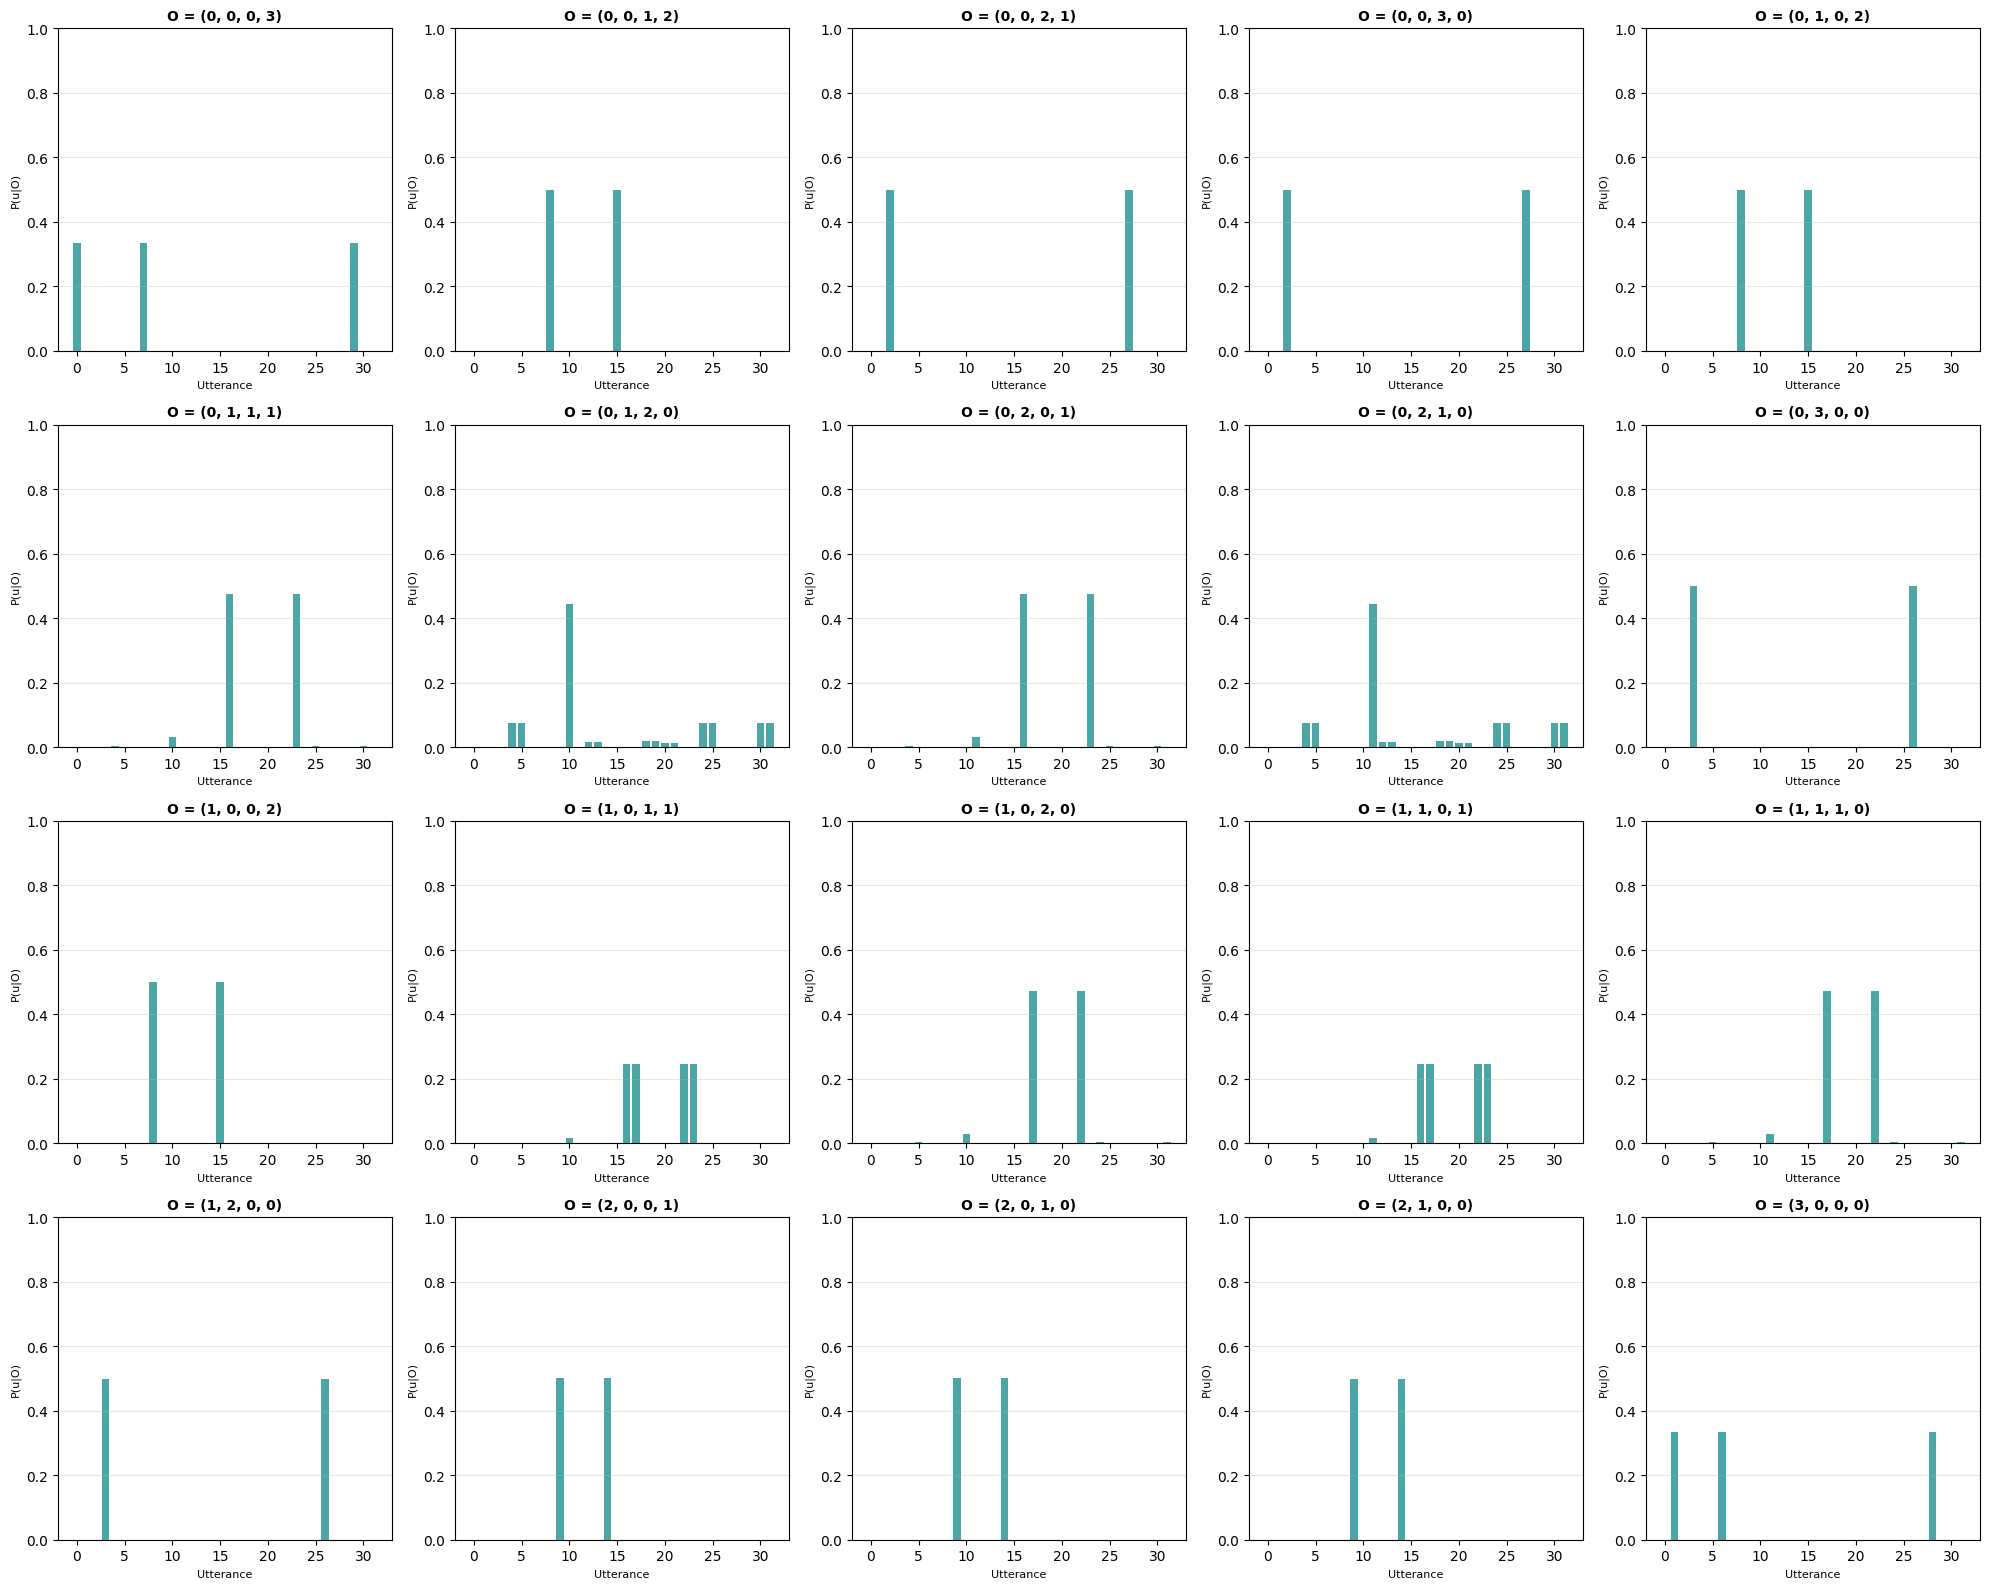

In [39]:
uniform_prior = jnp.ones(len(Theta)) / len(Theta)
alpha = 5.0

p_u_given_o_s2m = S2_inf(uniform_prior, alpha)

create_bar_plots(p_u_given_o_s2m, worldJAX.observations, len(worldJAX.utterances))

In [40]:
compare_two_matrix(p_u_given_o_s2, p_u_given_o_s2m)

Total num of entries: 640
Entry with differences: 122,  19.06%
Statistics of differences:
  biggest difference: 1.072884e-06
  smallest non-zero difference: 2.328306e-10
  average differences (non-zero ones): 7.349524e-08

BIGGEST DIFFERENCE at: observation 13, utterance 16
  The difference number: -1.072884e-06
  base version: 0.245230
  memo version: 0.245231

